## Pre-processing

- Load pelvis marker signals (300 Hz)
- Keep only the first 60 seconds
- Trim the first 5 seconds → retain exactly 55 seconds
- Then → interpolate → filter → downsample → z-score
- Save trimmed + processed signals

In [17]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, butter, filtfilt, resample_poly, medfilt
import re  # for extracting pair info from filenames

# --- Configuration ---
AXIS = "Y"  # vertical axis
DATA_DIR = Path.cwd()
SAMPLING_RATE = 300   # original mocap sampling rate (Hz)
TARGET_RATE = 10      # downsampled target rate (Hz)
MAX_LAG_SEC = 3.0     # check up to ±3 s lag
MAX_LAG = int(TARGET_RATE * MAX_LAG_SEC)

# --- Preprocessing parameters ---
CUTOFF_HZ = 4.0       # corrected low-pass cutoff for anti-aliasing
WINDOW_SEC = 5.0
STEP_SEC = 0.5
window_size = int(WINDOW_SEC * TARGET_RATE)
step_size = int(STEP_SEC * TARGET_RATE)

# --- Trim logic ---
CUT_FIRST_SEC = 60     # keep first 60 seconds (300 Hz)
TRIM_FIRST_SEC = 5     # then trim first 5 seconds
CUT_SAMPLES = int(CUT_FIRST_SEC * SAMPLING_RATE)
TRIM_SAMPLES = int(TRIM_FIRST_SEC * SAMPLING_RATE)

# --- Pelvis markers ---
PELVIS_MARKERS = {
    "Lead": ["Lead_Hip_Left", "Lead_Hip_Right"],
    "Follow": ["Follow_Hip_Left", "Follow_Hip_Right"],
}

# --- Output folder ---
PREPROC_DIR = DATA_DIR / "preprocessed_signals_10HZ"
PREPROC_DIR.mkdir(exist_ok=True)

# ============================================================
# Helper functions
# ============================================================

def find_table_start(tsv_path):
    """Locate where the MoCap numerical table begins."""
    with open(tsv_path, "r", encoding="utf-8", errors="replace") as f:
        for i, line in enumerate(f):
            if line.startswith("Frame\tTime"):
                return i
    raise ValueError(f"Couldn't find header in {tsv_path}")


def parse_filename(filename):
    """Extract pair ID (e.g., L1F1) and condition from filename."""
    match = re.search(r"L\d+F\d+", filename)
    pair = match.group(0) if match else "Unknown"
    condition_match = re.search(r"(open|closed|solo|together|apart)", filename, re.IGNORECASE)
    condition = condition_match.group(0).lower() if condition_match else "unknown"
    return pair, condition


# ============================================================
# Corrected Full Preprocessing Pipeline
# ============================================================

def preprocess_signal(sig, orig_rate=300, target_rate=10, cutoff=4.0):
    """
    Clean and downsample mocap signals safely:
    - Interpolate missing values
    - Median filter to remove spikes
    - Low-pass filter for anti-aliasing
    - Downsample
    - Standardize
    """
    # 1) Interpolate gaps (allow up to ~100 frames ≈ 333 ms)
    sig = pd.Series(sig).interpolate(limit_direction="both", limit=100).to_numpy()

    # 2) Remove spikes/jitter
    sig = medfilt(sig, kernel_size=5)

    # 3) Anti-alias low-pass filter BEFORE downsampling
    b, a = butter(4, cutoff / (orig_rate / 2), btype='low')
    sig_filt = filtfilt(b, a, sig)

    # 4) Downsample using polyphase filtering
    down_factor = int(orig_rate / target_rate)
    sig_down = resample_poly(sig_filt, up=1, down=down_factor)

    # 5) Standardize
    sig_z = (sig_down - np.mean(sig_down)) / np.std(sig_down)

    return sig_z


def crosscorr(x, y, max_lag):
    """Compute normalized cross-correlation with ±max_lag window."""
    x = x - np.mean(x)
    y = y - np.mean(y)
    corr_full = correlate(y, x, mode='full', method='auto')

    norm = np.sqrt(np.sum(x**2) * np.sum(y**2))
    corr_full = corr_full / norm

    lags = np.arange(-len(x) + 1, len(x))
    center = len(corr_full) // 2
    lag_idx = slice(center - max_lag, center + max_lag + 1)

    return lags[lag_idx], corr_full[lag_idx]


# ============================================================
# Main processing loop
# ============================================================

summary_records = []

for tsv_path in sorted(DATA_DIR.glob("*.tsv")):
    print(f"\nProcessing: {tsv_path.name}")

    pair, condition = parse_filename(tsv_path.name)

    # --- Load TSV ---
    try:
        skiprows = find_table_start(tsv_path)
        df = pd.read_csv(tsv_path, sep="\t", header=0, skiprows=skiprows, engine="python")
    except Exception as e:
        print(f"Skipping {tsv_path.name}: {e}")
        continue

    # --- Select pelvis markers ---
    lead_cols = [f"{m} {AXIS}" for m in PELVIS_MARKERS["Lead"] if f"{m} {AXIS}" in df.columns]
    follow_cols = [f"{m} {AXIS}" for m in PELVIS_MARKERS["Follow"] if f"{m} {AXIS}" in df.columns]

    if not lead_cols or not follow_cols:
        print("Missing pelvis columns, skipping.")
        continue

    # --- Compute pelvis center (average of L/R hips) ---
    lead_center = df[lead_cols].mean(axis=1)
    follow_center = df[follow_cols].mean(axis=1)

    # ============================================================
    #                   TRIM + PREPROCESS
    # ============================================================

    # 1) Keep only first 60 seconds (300 Hz)
    lead_center = lead_center.iloc[:CUT_SAMPLES]
    follow_center = follow_center.iloc[:CUT_SAMPLES]

    # 2) Trim first 5 seconds → retain clean 55 seconds
    lead_center = lead_center.iloc[TRIM_SAMPLES:].reset_index(drop=True)
    follow_center = follow_center.iloc[TRIM_SAMPLES:].reset_index(drop=True)

    # 3) Clean + Downsample to 10 Hz
    lead_proc = preprocess_signal(lead_center, orig_rate=SAMPLING_RATE,
                                  target_rate=TARGET_RATE, cutoff=CUTOFF_HZ)
    follow_proc = preprocess_signal(follow_center, orig_rate=SAMPLING_RATE,
                                    target_rate=TARGET_RATE, cutoff=CUTOFF_HZ)

    # 4) Time axis
    time = np.arange(len(lead_proc)) / TARGET_RATE

    # 5) Save results
    preproc_df = pd.DataFrame({
        "Time_s": time,
        "Lead_Y": lead_proc,
        "Follow_Y": follow_proc
    })

    out_name = f"{tsv_path.stem}_trimmed_preprocessed_10Hz.csv"
    preproc_path = PREPROC_DIR / out_name
    preproc_df.to_csv(preproc_path, index=False)

    print(f"Saved trimmed+preprocessed signals to: {preproc_path}")



Processing: mocap_L10F10_closed.tsv
Saved trimmed+preprocessed signals to: c:\Users\au605619\Downloads\MoCap_labeled_trial\preprocessed_signals_10HZ\mocap_L10F10_closed_trimmed_preprocessed_10Hz.csv

Processing: mocap_L10F10_open.tsv
Saved trimmed+preprocessed signals to: c:\Users\au605619\Downloads\MoCap_labeled_trial\preprocessed_signals_10HZ\mocap_L10F10_open_trimmed_preprocessed_10Hz.csv

Processing: mocap_L10F9_closed.tsv
Saved trimmed+preprocessed signals to: c:\Users\au605619\Downloads\MoCap_labeled_trial\preprocessed_signals_10HZ\mocap_L10F9_closed_trimmed_preprocessed_10Hz.csv

Processing: mocap_L10F9_open.tsv
Saved trimmed+preprocessed signals to: c:\Users\au605619\Downloads\MoCap_labeled_trial\preprocessed_signals_10HZ\mocap_L10F9_open_trimmed_preprocessed_10Hz.csv

Processing: mocap_L11F11_closed.tsv
Saved trimmed+preprocessed signals to: c:\Users\au605619\Downloads\MoCap_labeled_trial\preprocessed_signals_10HZ\mocap_L11F11_closed_trimmed_preprocessed_10Hz.csv

Processing:

In [18]:
# laod one file
# Load the CSV files
L1F1_closed_10Hz = pd.read_csv('preprocessed_signals_10HZ/mocap_L1F1_closed_trimmed_preprocessed_10Hz.csv')

In [19]:
print(L1F1_closed_10Hz)

     Time_s    Lead_Y  Follow_Y
0       0.0 -1.211289 -0.090268
1       0.1 -1.914018 -0.589711
2       0.2 -1.218304 -0.036042
3       0.3 -1.278035  0.129520
4       0.4 -1.392193  0.414145
..      ...       ...       ...
545    54.5  0.950636  0.545509
546    54.6  0.776135  0.311854
547    54.7  0.731418  0.055232
548    54.8  0.669776 -0.066288
549    54.9  0.729201 -0.369763

[550 rows x 3 columns]


In [20]:
# Get sampling interval and rate
dt = np.median(np.diff(L1F1_closed_10Hz["Time_s"]))   # typical time step
fs = 1.0 / dt                   # sampling frequency in Hz
print("Sampling interval dt:", dt, "seconds")
print("Sampling rate fs:", fs, "Hz")

Sampling interval dt: 0.10000000000000142 seconds
Sampling rate fs: 9.999999999999858 Hz


## Windowed cross corr

Positive lag	 - Follow lags behind Lead  
Negative lag	- Follow leads ahead of Lead


Processing windowed cross-corr: mocap_L10F10_closed_trimmed_preprocessed.csv


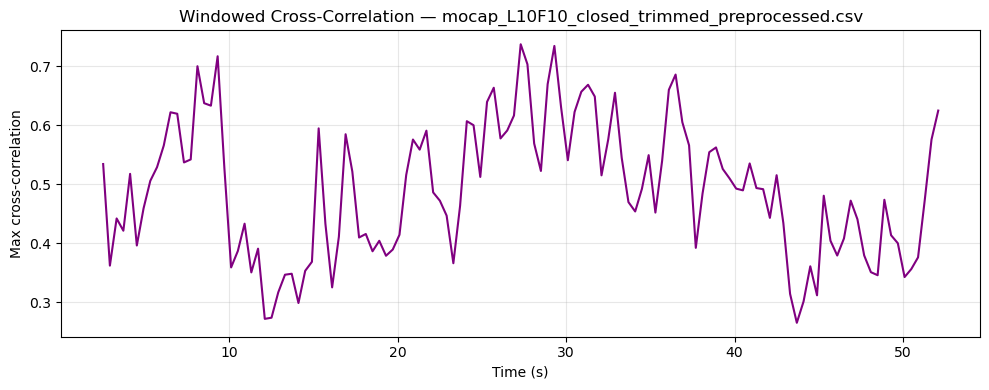

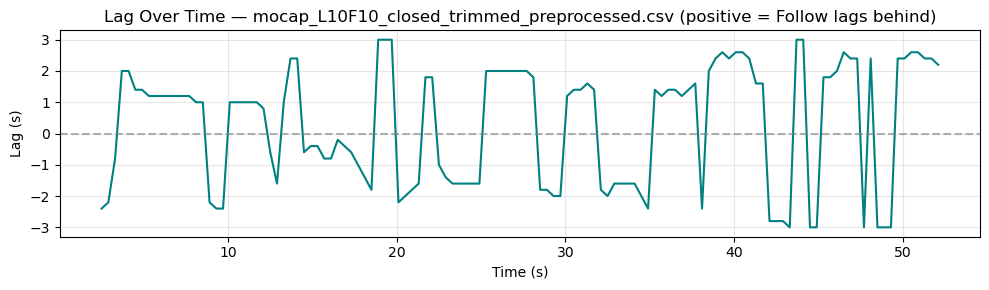


Processing windowed cross-corr: mocap_L10F10_open_trimmed_preprocessed.csv


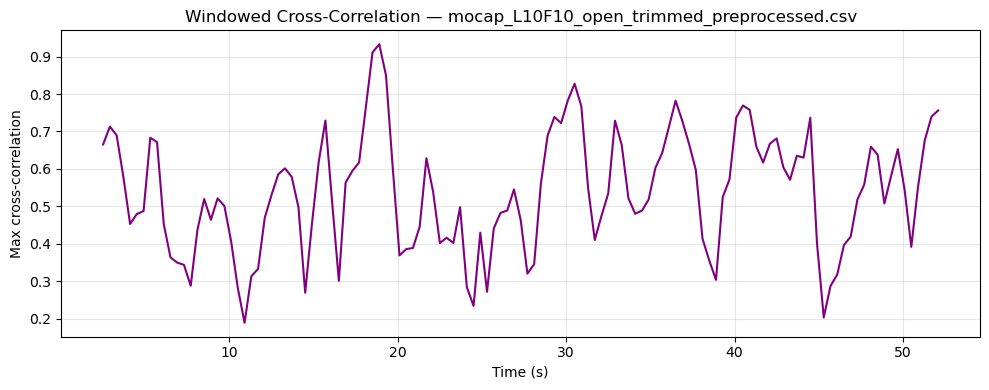

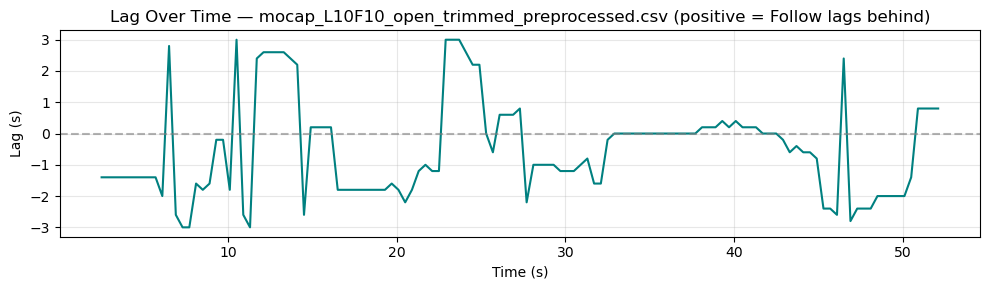


Processing windowed cross-corr: mocap_L10F9_closed_trimmed_preprocessed.csv


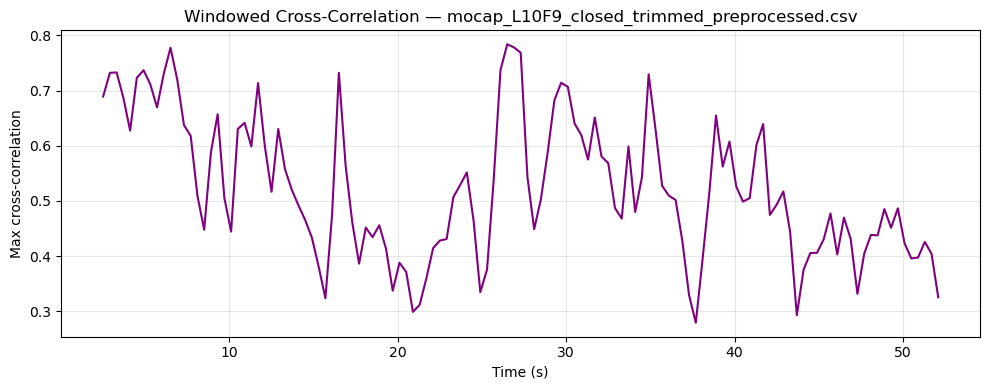

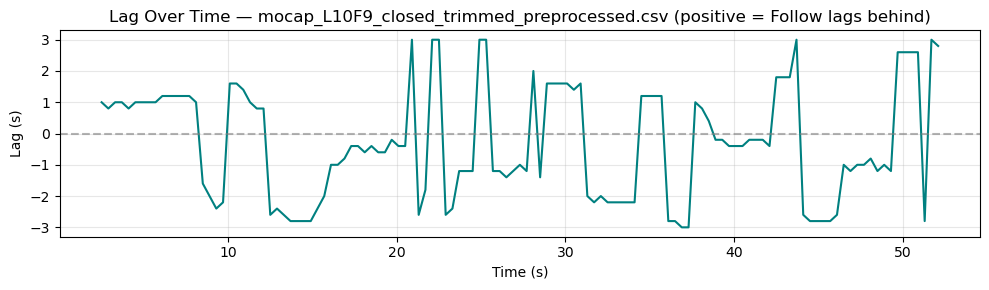


Processing windowed cross-corr: mocap_L10F9_open_trimmed_preprocessed.csv


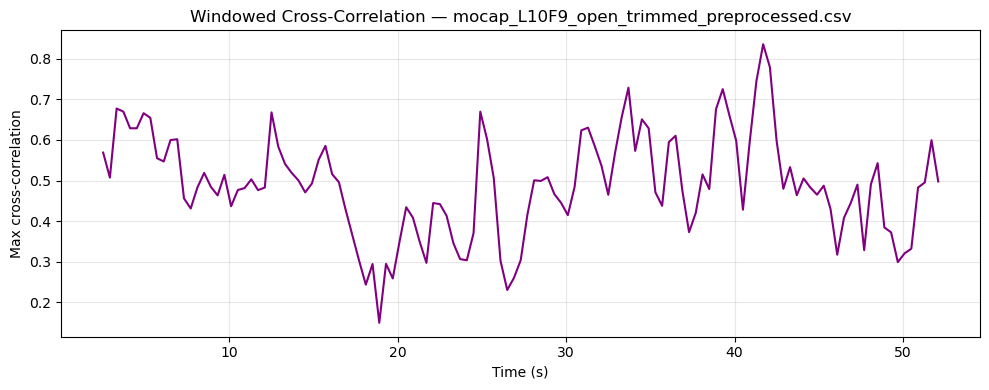

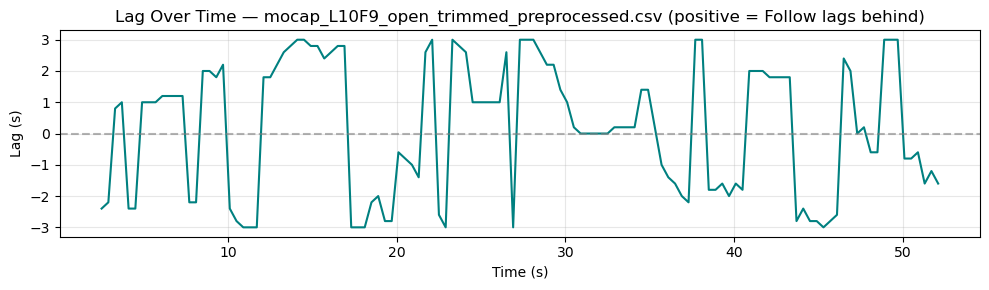


Processing windowed cross-corr: mocap_L11F11_closed_trimmed_preprocessed.csv


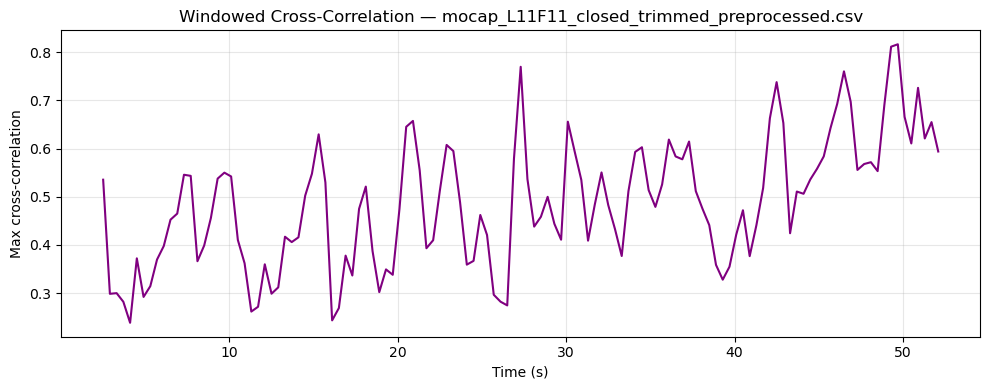

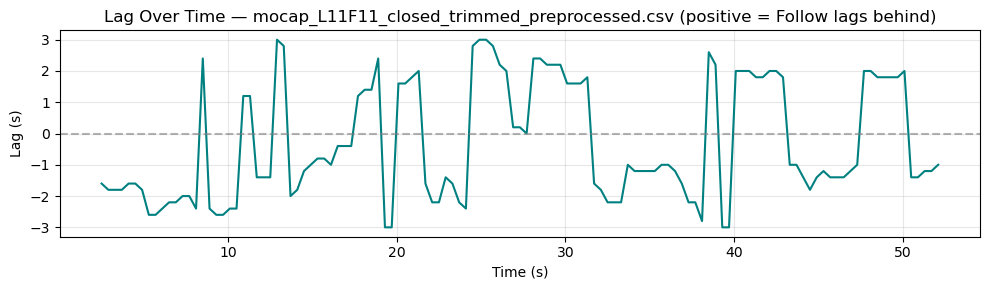


Processing windowed cross-corr: mocap_L11F11_open_trimmed_preprocessed.csv


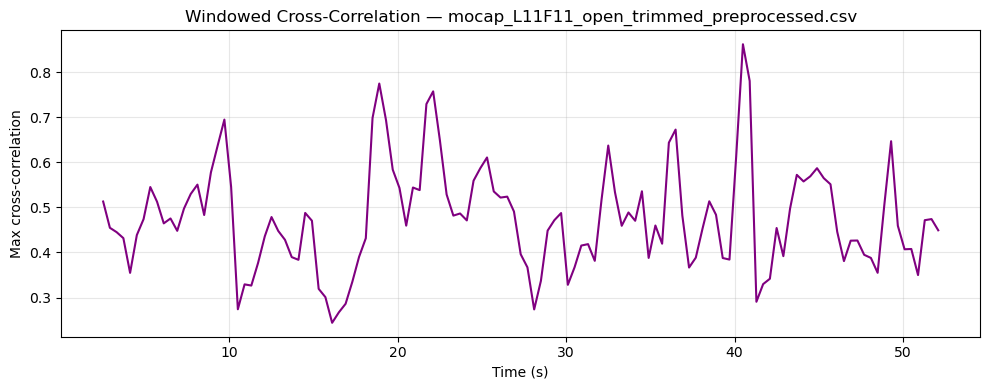

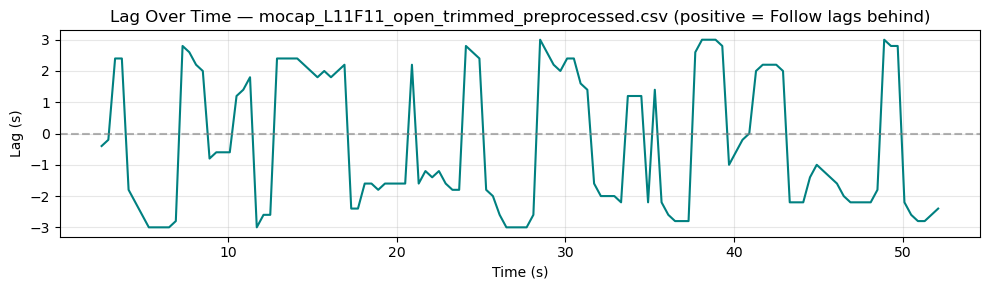


Processing windowed cross-corr: mocap_L11F12_closed_trimmed_preprocessed.csv


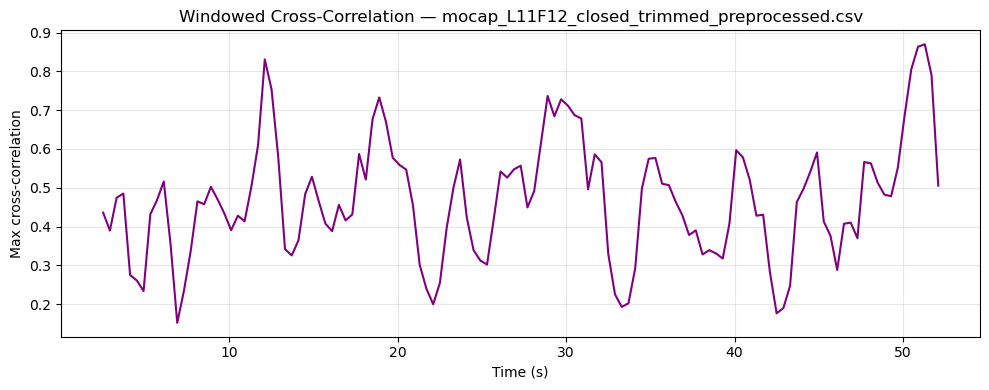

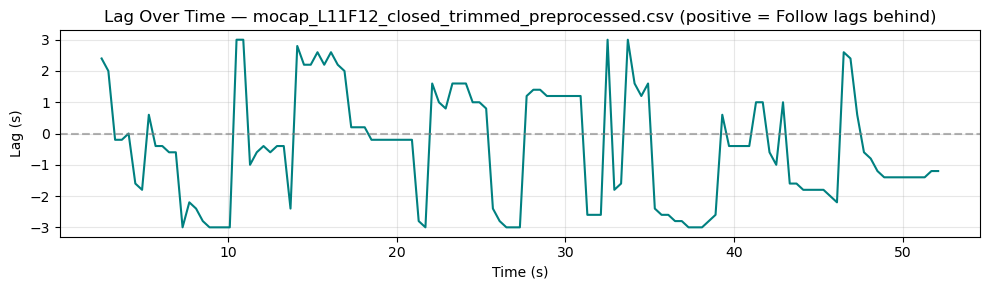


Processing windowed cross-corr: mocap_L11F12_open_trimmed_preprocessed.csv


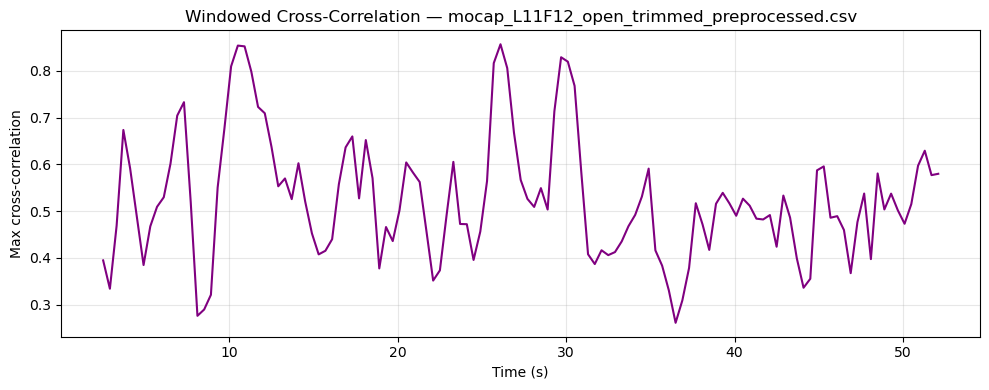

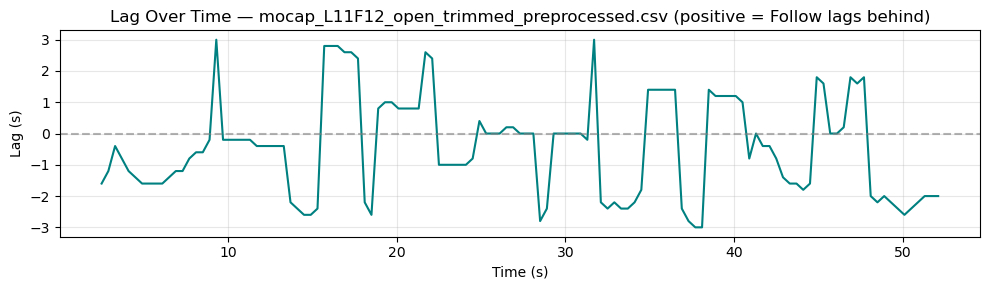


Processing windowed cross-corr: mocap_L12F11_closed_trimmed_preprocessed.csv


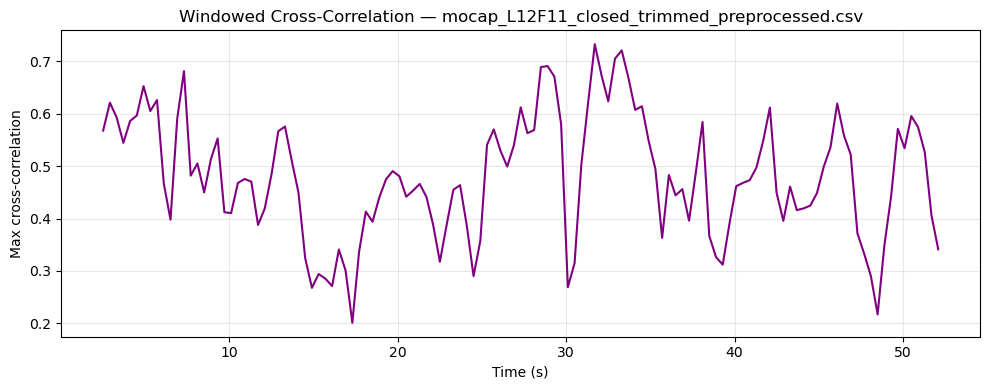

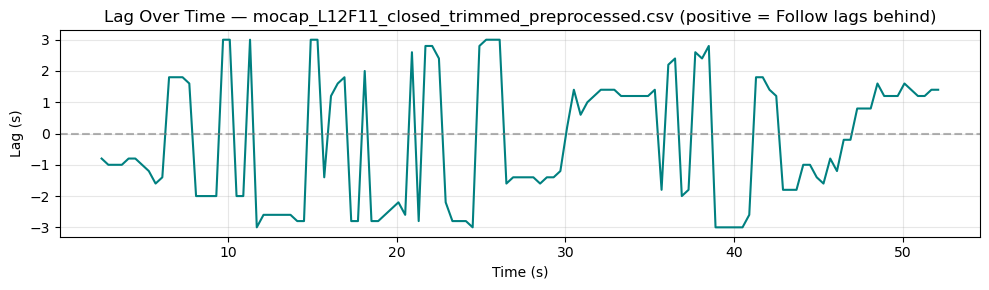


Processing windowed cross-corr: mocap_L12F11_open_trimmed_preprocessed.csv


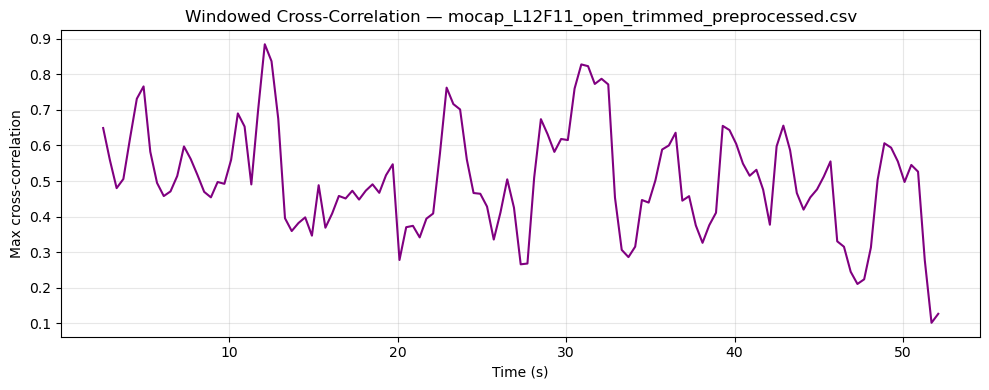

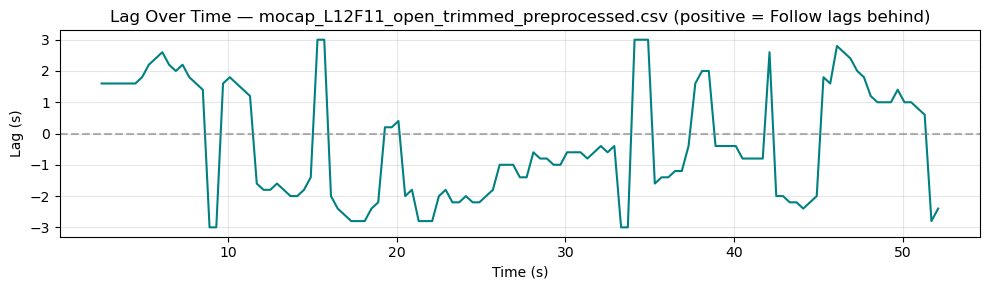


Processing windowed cross-corr: mocap_L12F12_closed_trimmed_preprocessed.csv


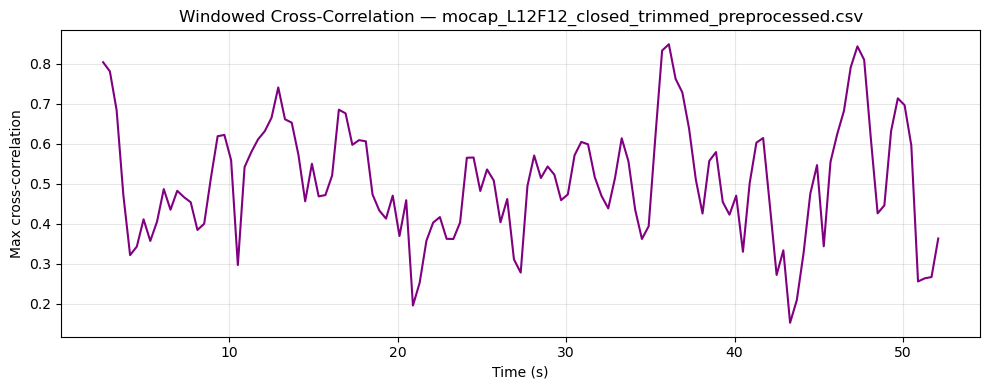

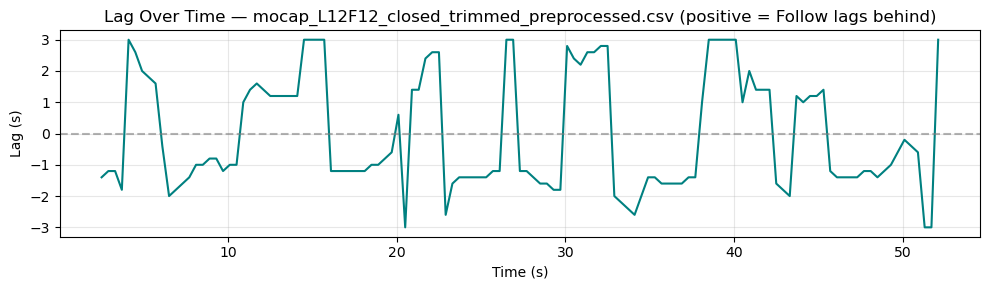


Processing windowed cross-corr: mocap_L12F12_open_trimmed_preprocessed.csv


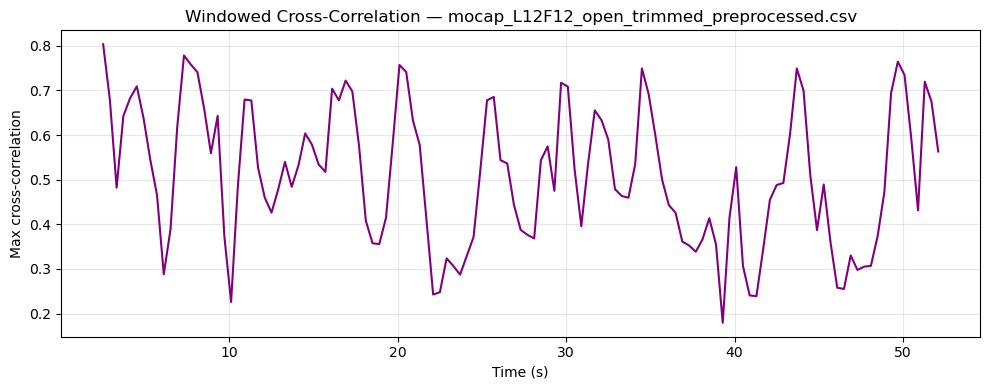

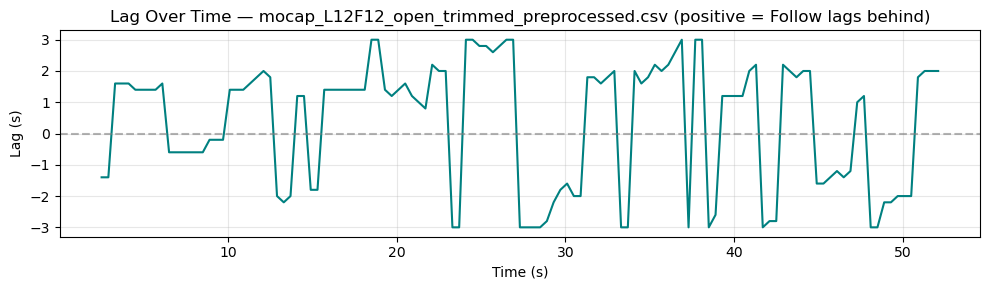


Processing windowed cross-corr: mocap_L1F1_closed_trimmed_preprocessed.csv


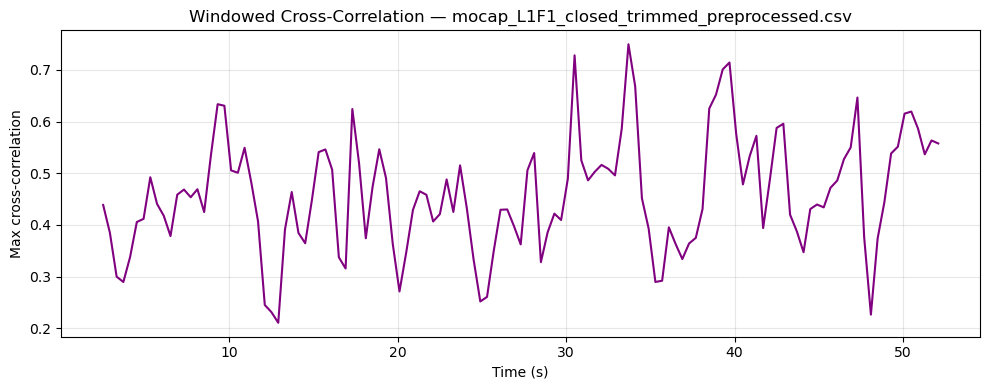

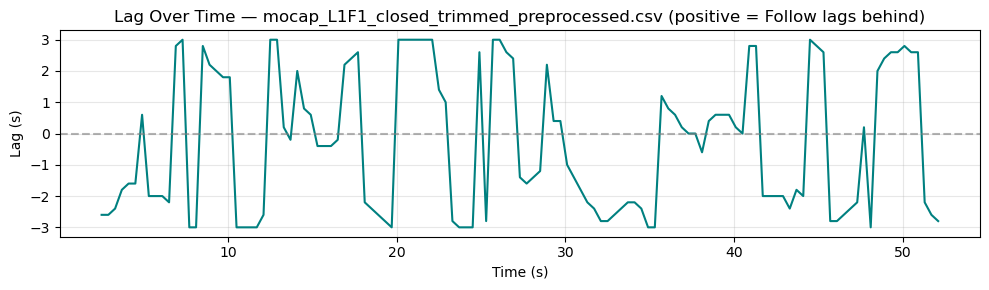


Processing windowed cross-corr: mocap_L1F1_open_trimmed_preprocessed.csv


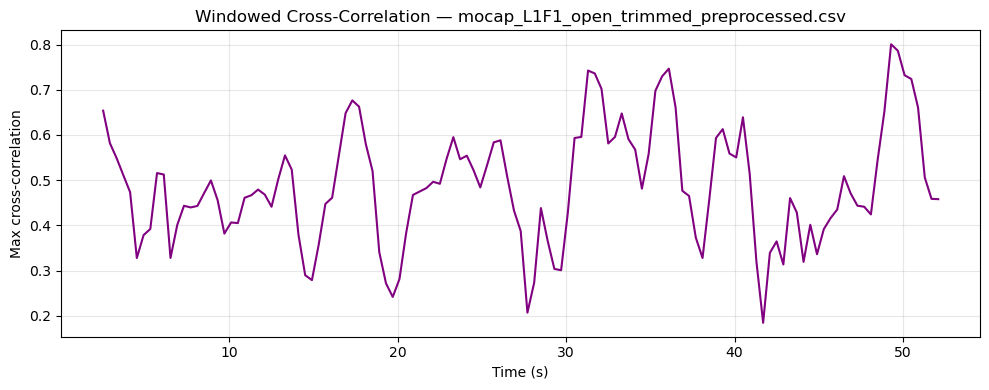

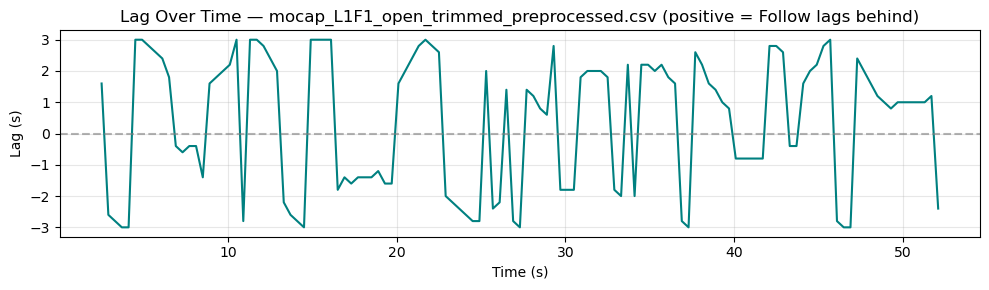


Processing windowed cross-corr: mocap_L1F2_closed_trimmed_preprocessed.csv


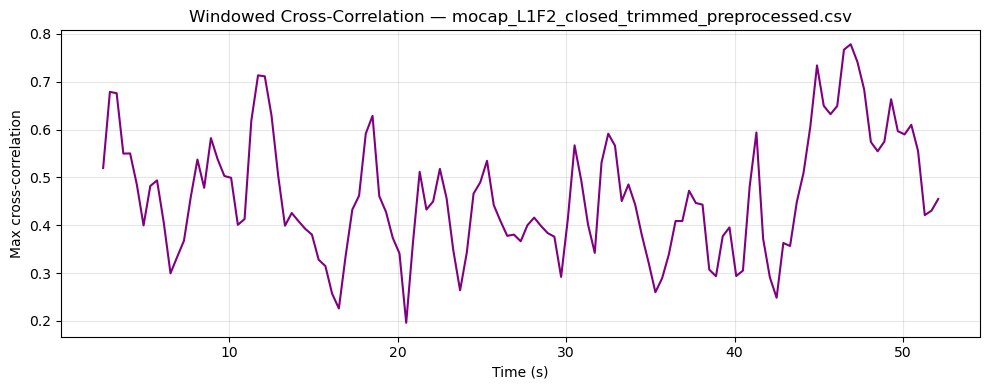

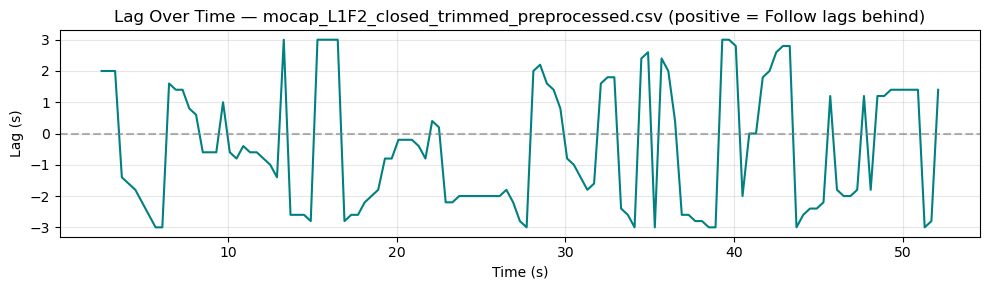


Processing windowed cross-corr: mocap_L1F2_open_trimmed_preprocessed.csv


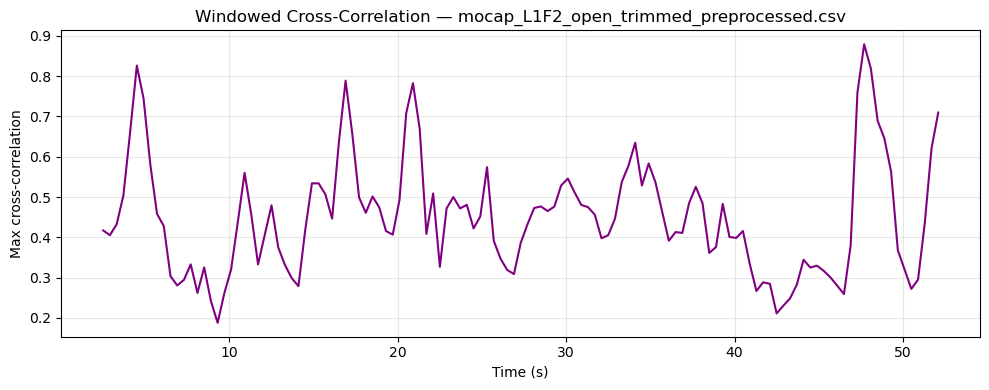

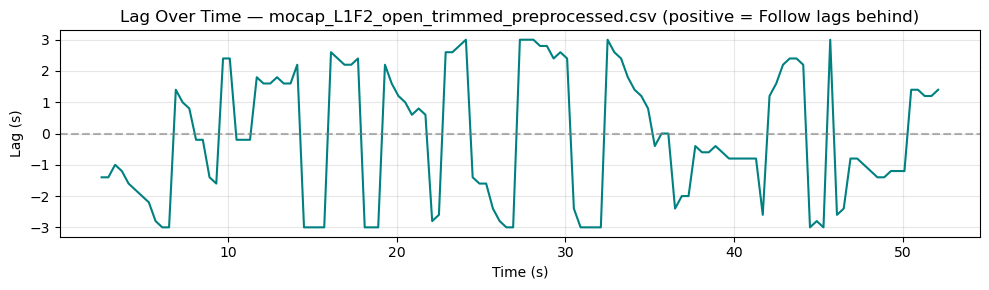


Processing windowed cross-corr: mocap_L2F2_closed_trimmed_preprocessed.csv


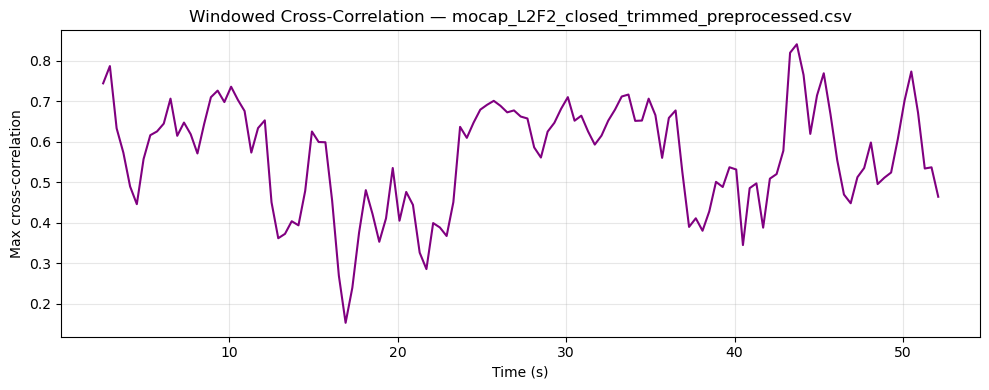

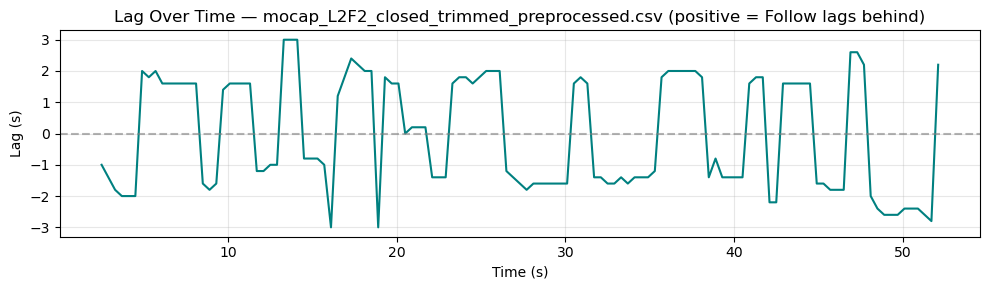


Processing windowed cross-corr: mocap_L2F2_open_trimmed_preprocessed.csv


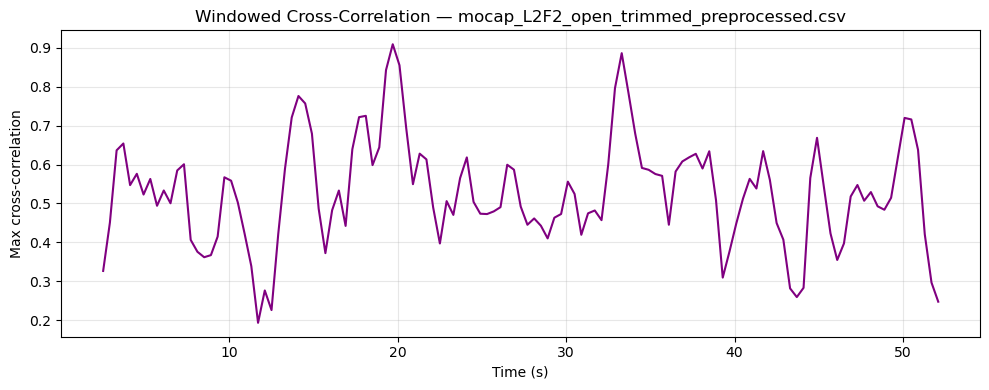

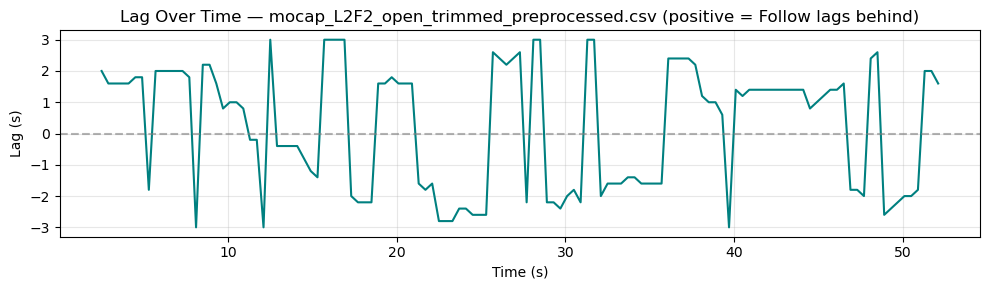


Processing windowed cross-corr: mocap_L3F3_closed_trimmed_preprocessed.csv


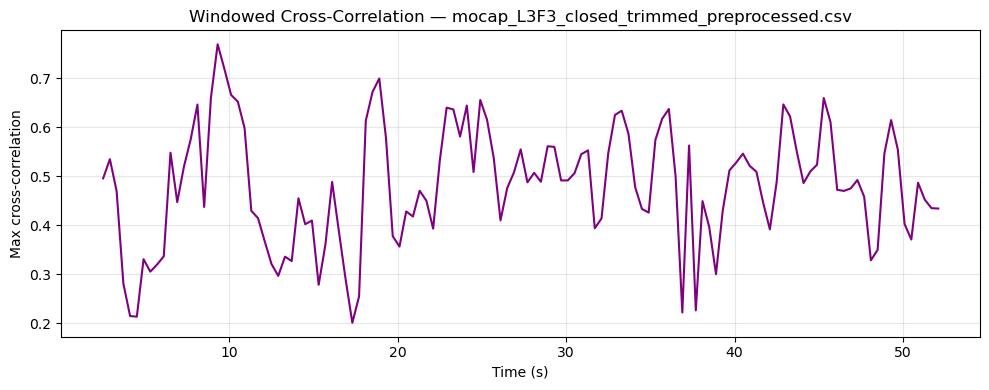

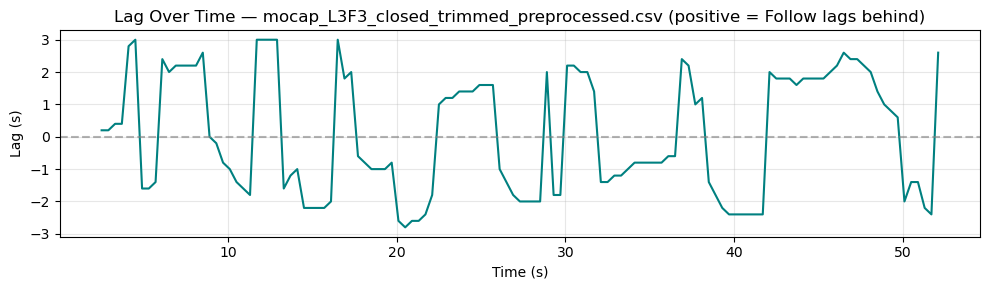


Processing windowed cross-corr: mocap_L3F3_open_trimmed_preprocessed.csv


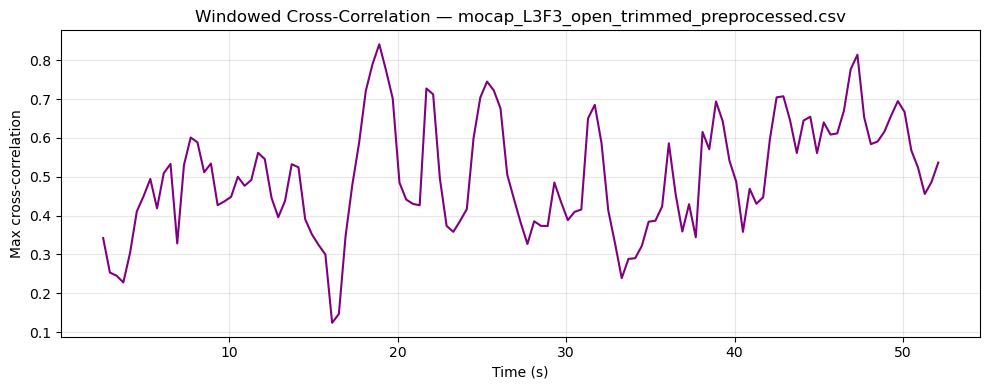

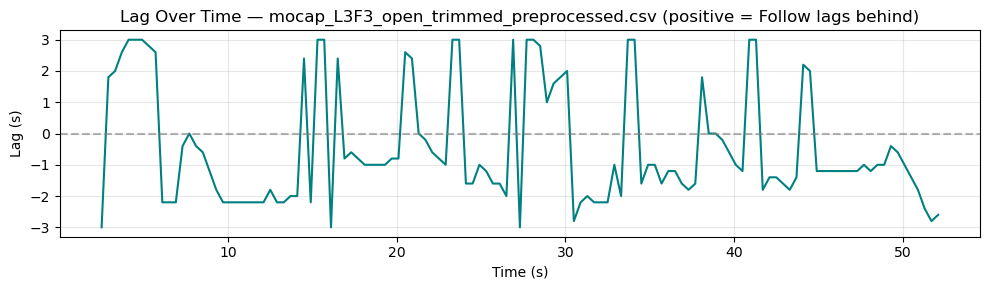


Processing windowed cross-corr: mocap_L3F4_closed_trimmed_preprocessed.csv


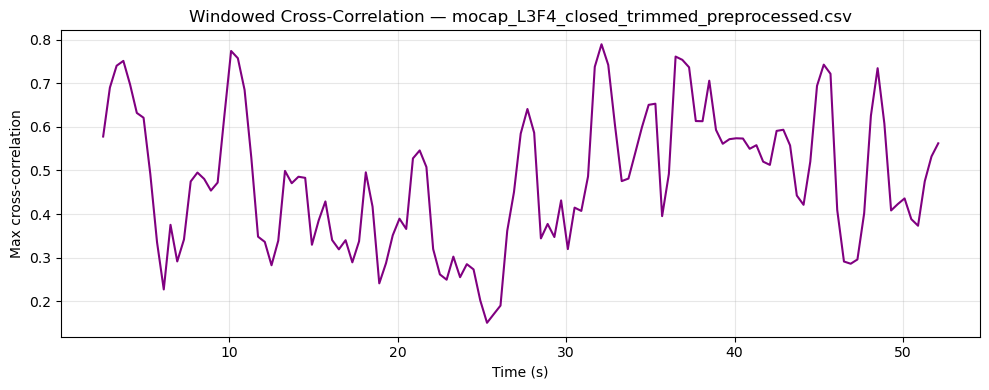

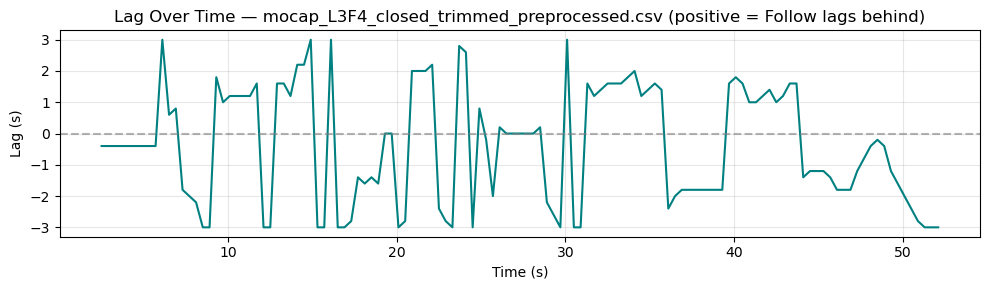


Processing windowed cross-corr: mocap_L3F4_open_trimmed_preprocessed.csv


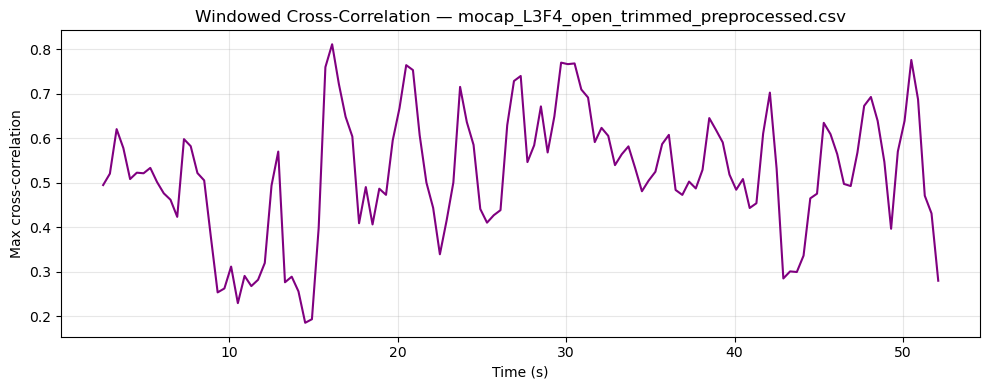

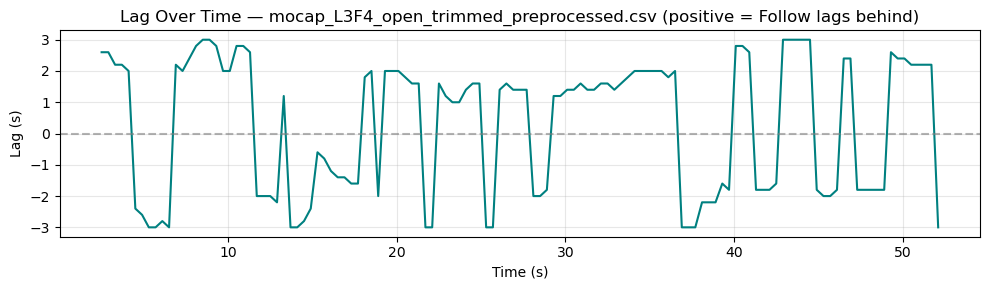


Processing windowed cross-corr: mocap_L4F3_closed_trimmed_preprocessed.csv


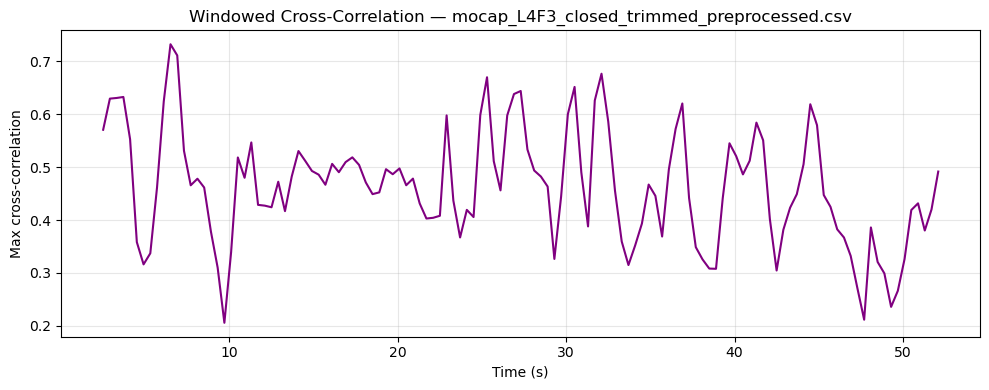

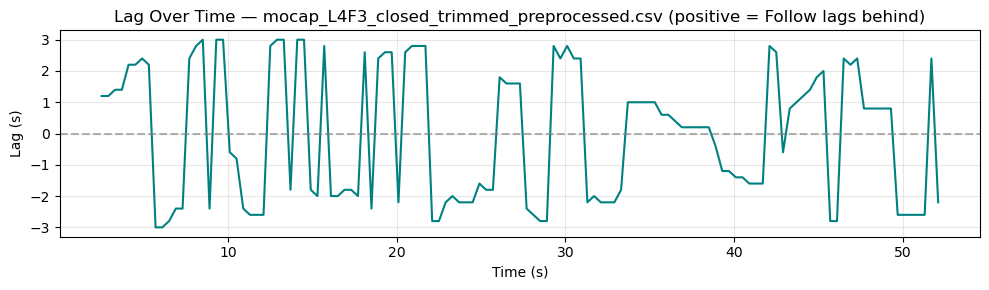


Processing windowed cross-corr: mocap_L4F3_open_trimmed_preprocessed.csv


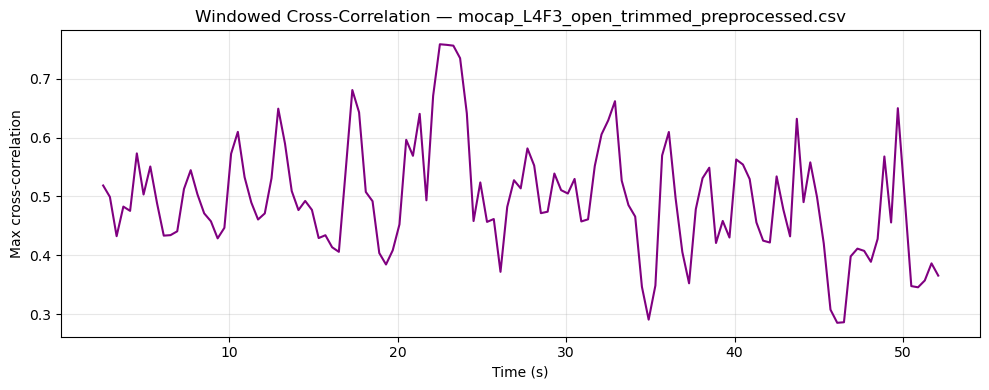

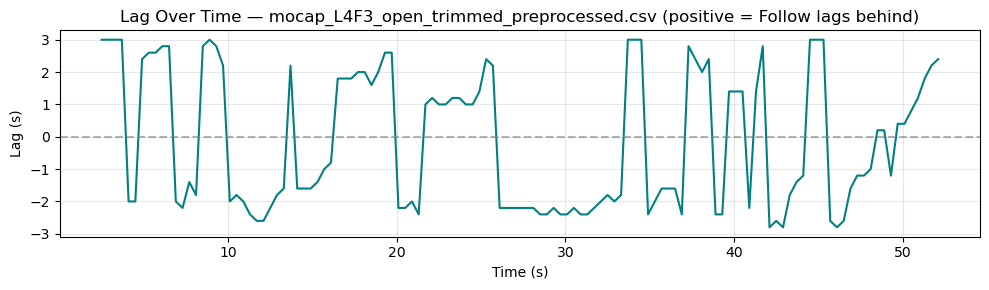


Processing windowed cross-corr: mocap_L4F4_closed_trimmed_preprocessed.csv


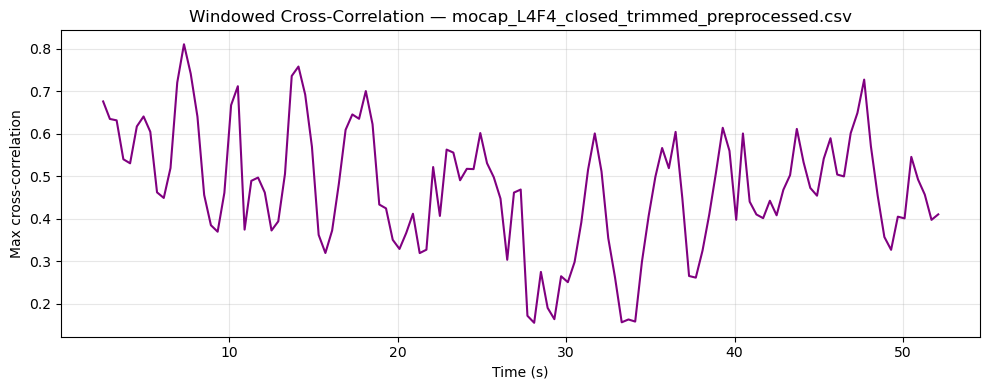

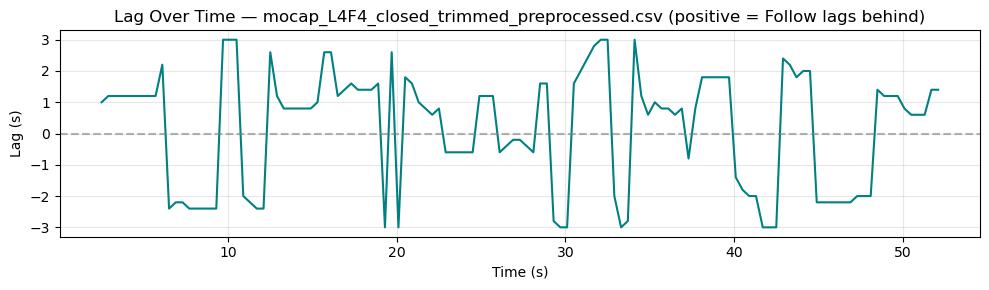


Processing windowed cross-corr: mocap_L4F4_open_trimmed_preprocessed.csv


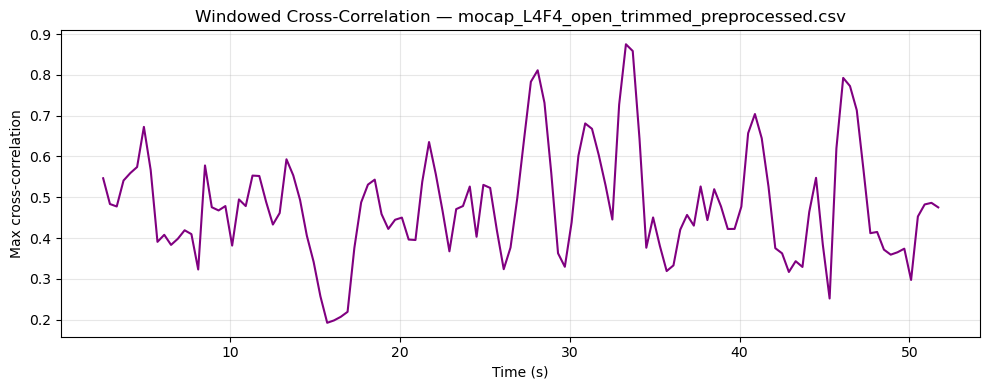

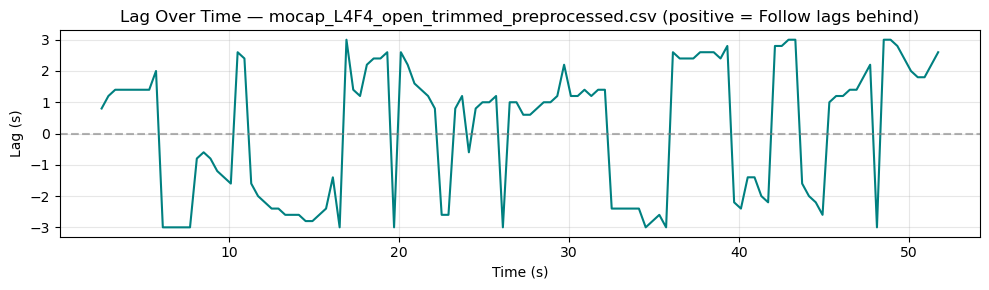


Processing windowed cross-corr: mocap_L5F5_closed_trimmed_preprocessed.csv


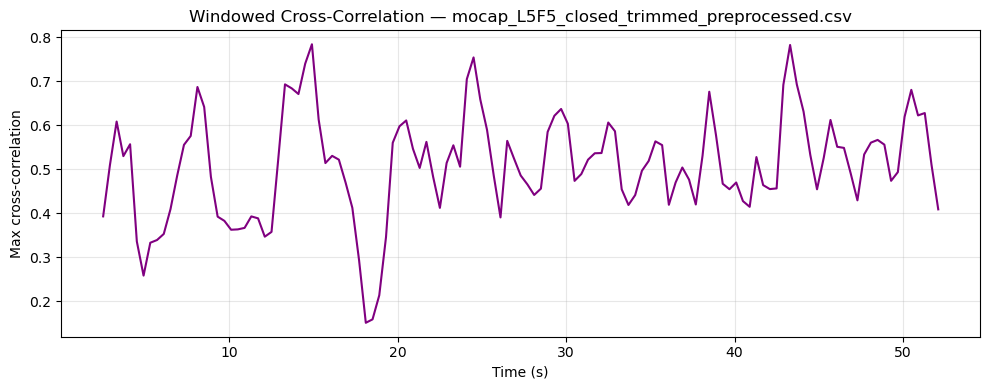

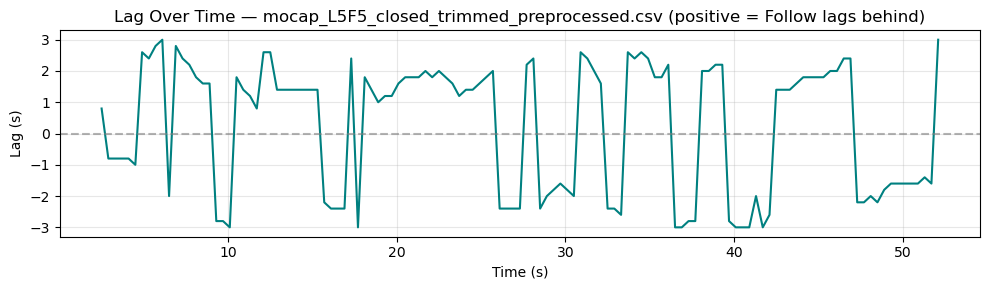


Processing windowed cross-corr: mocap_L5F5_free_trimmed_preprocessed.csv


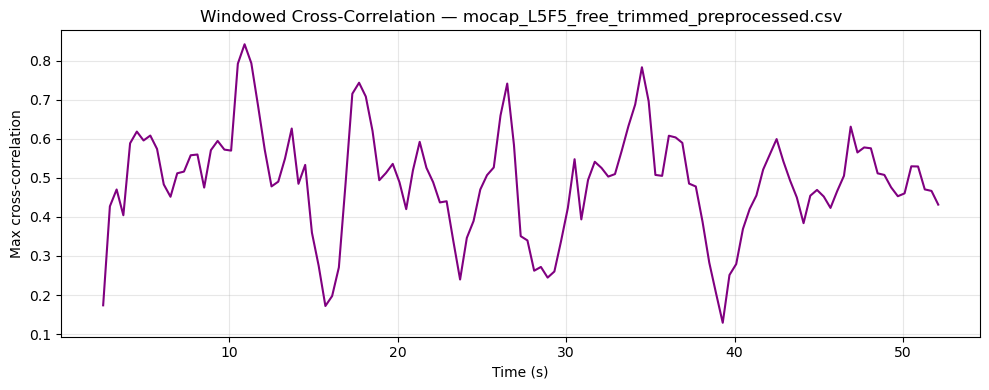

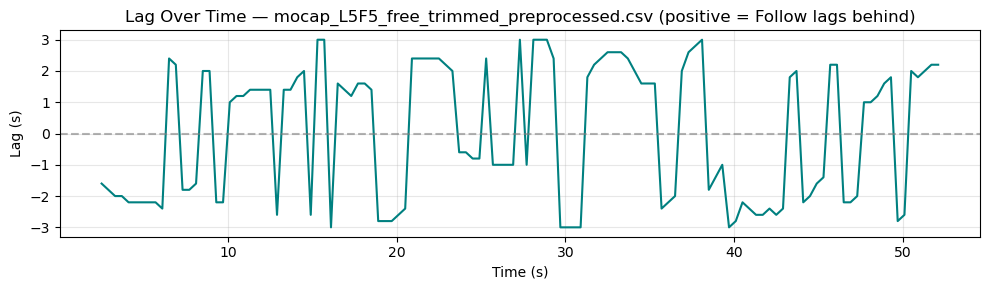


Processing windowed cross-corr: mocap_L5F5_open_trimmed_preprocessed.csv


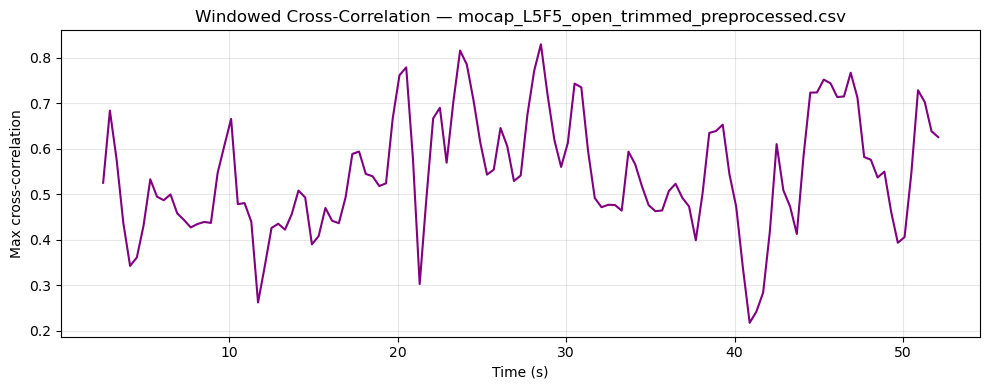

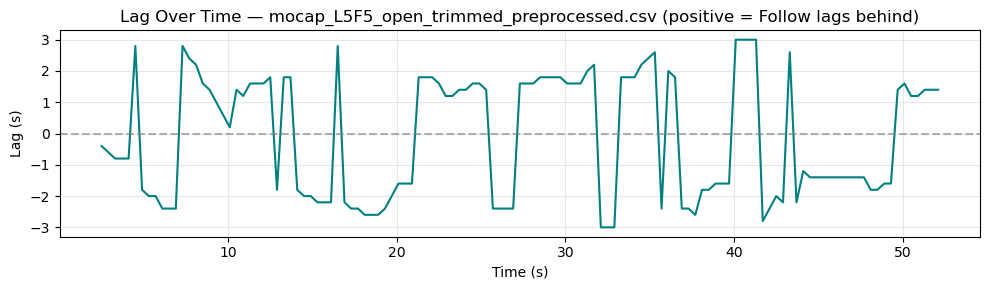


Processing windowed cross-corr: mocap_L6F6_closed_trimmed_preprocessed.csv


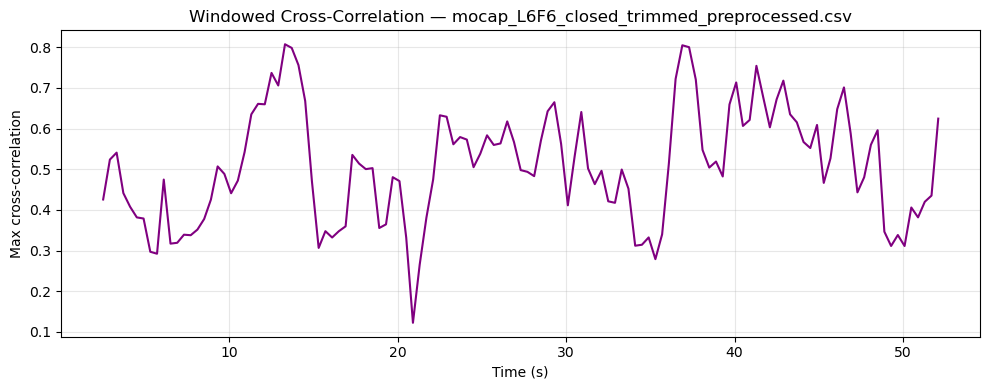

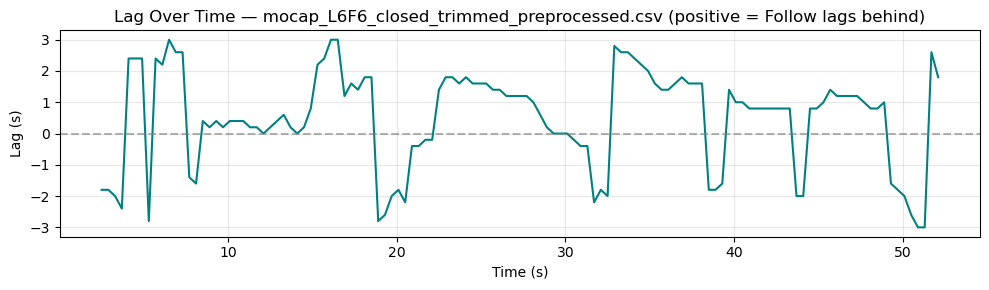


Processing windowed cross-corr: mocap_L6F6_open_trimmed_preprocessed.csv


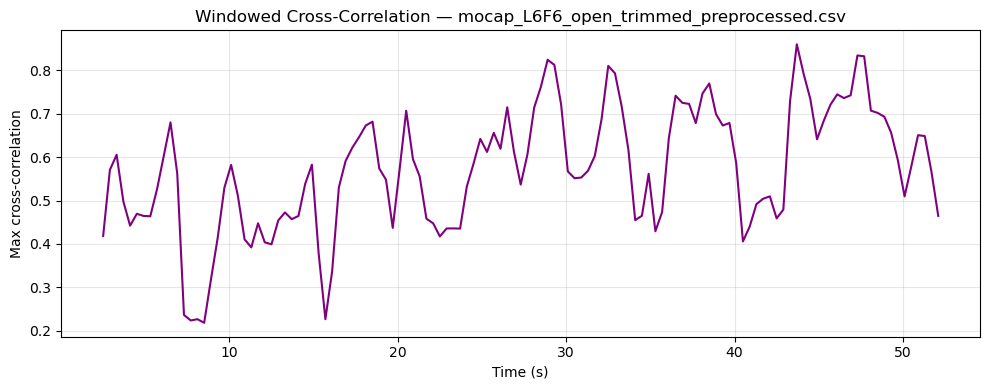

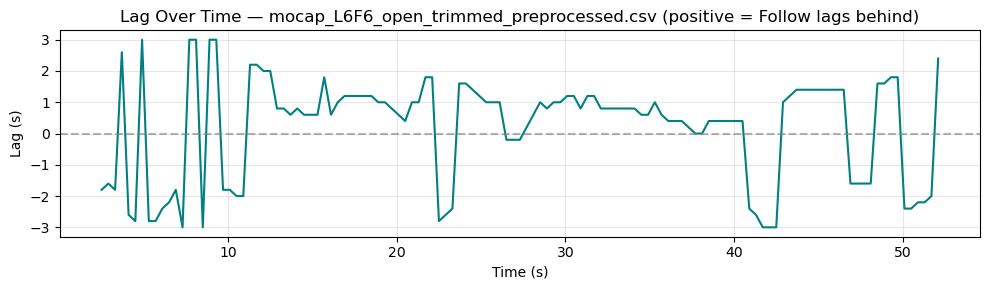


Processing windowed cross-corr: mocap_L7F7_closed_trimmed_preprocessed.csv


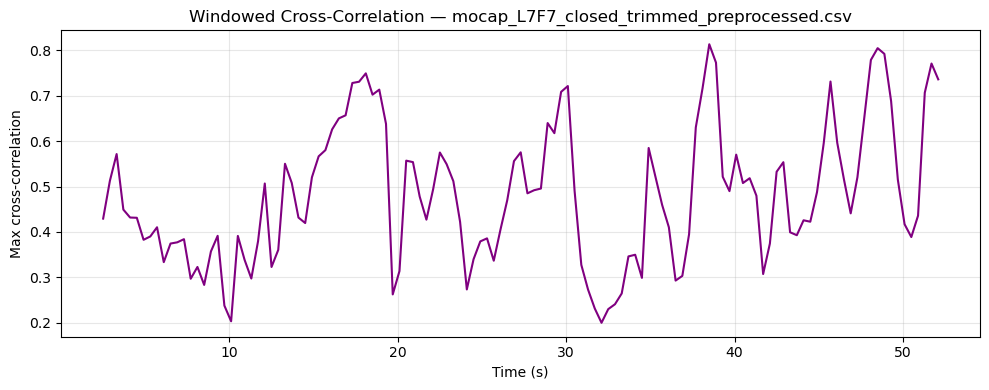

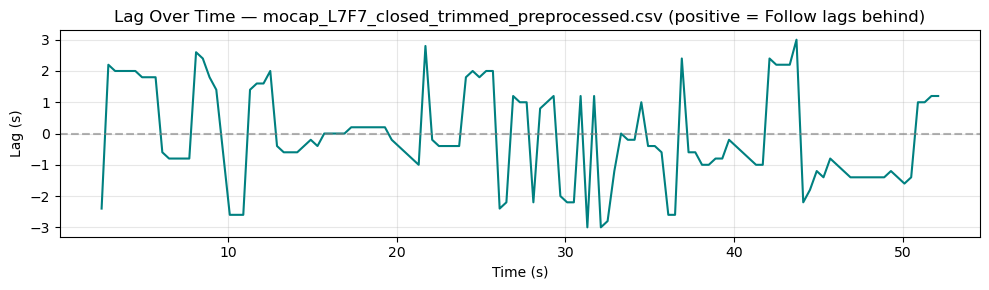


Processing windowed cross-corr: mocap_L7F7_open_trimmed_preprocessed.csv


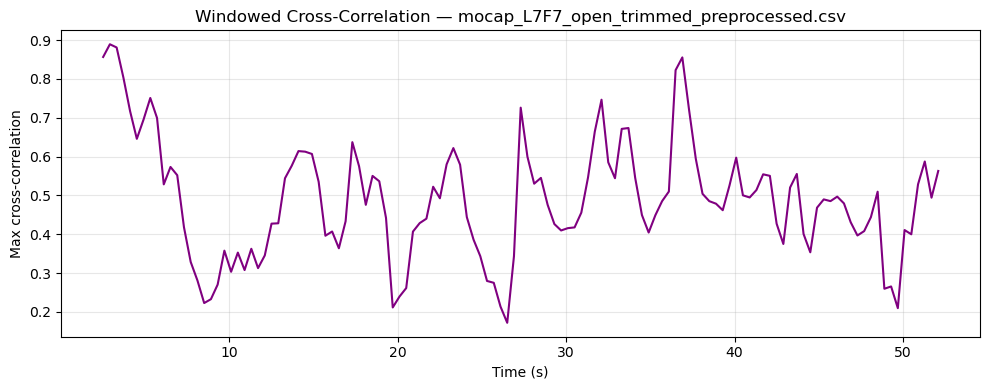

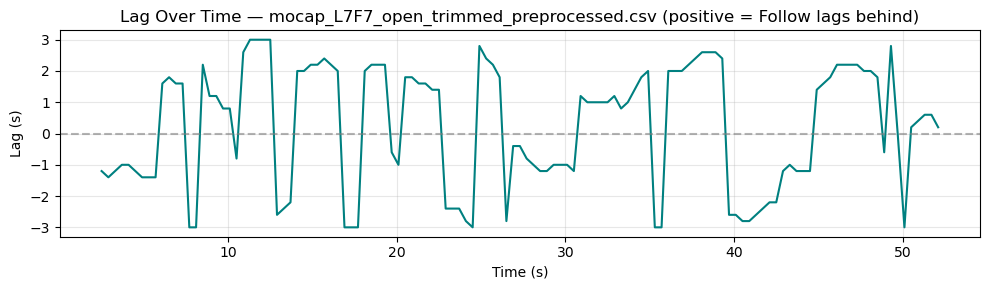


Processing windowed cross-corr: mocap_L7F8_closed_trimmed_preprocessed.csv


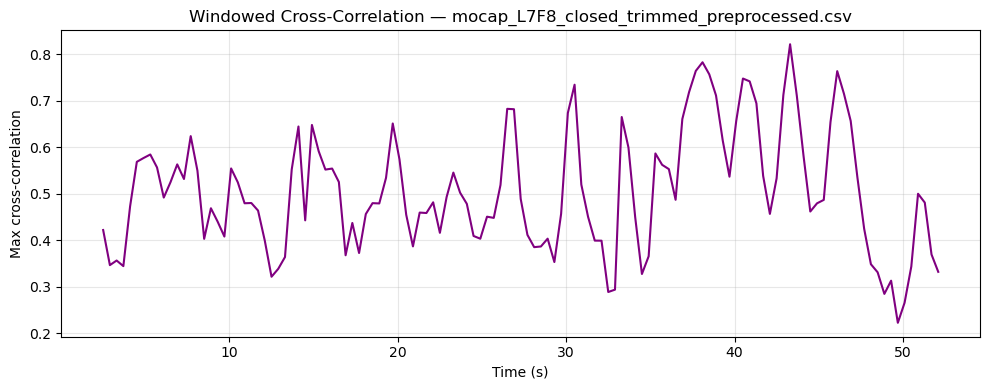

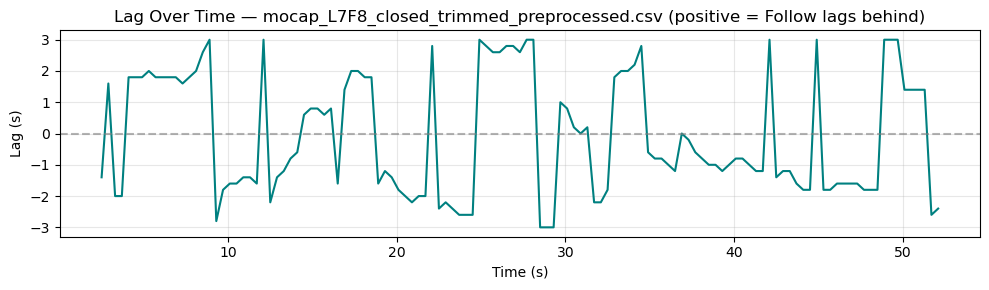


Processing windowed cross-corr: mocap_L7F8_open_trimmed_preprocessed.csv


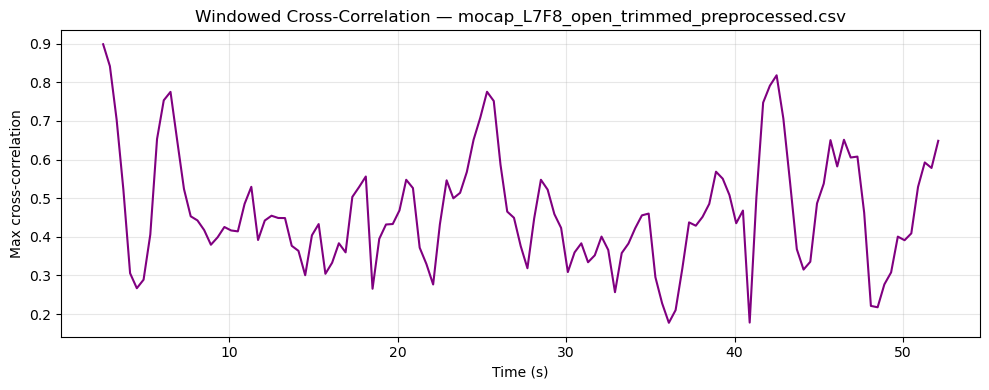

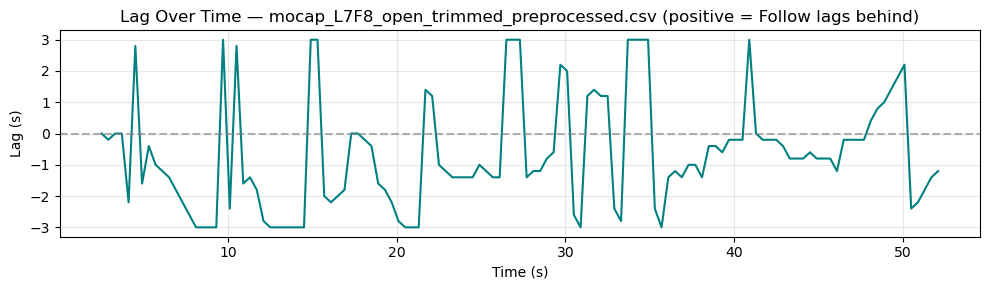


Processing windowed cross-corr: mocap_L8F7_closed_trimmed_preprocessed.csv


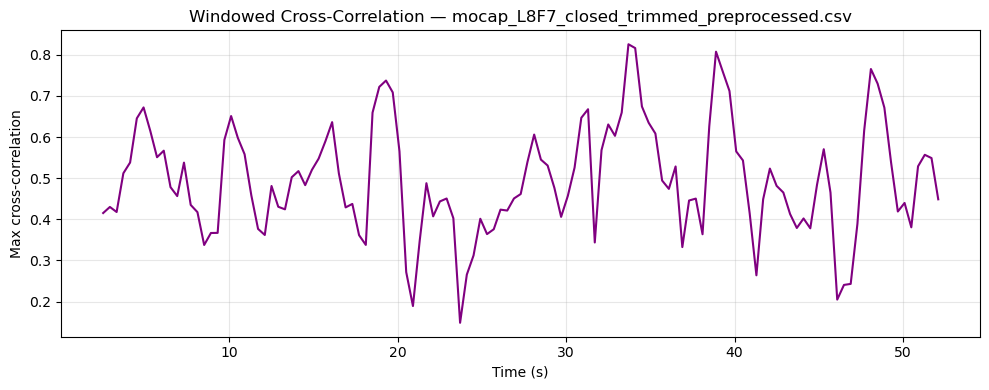

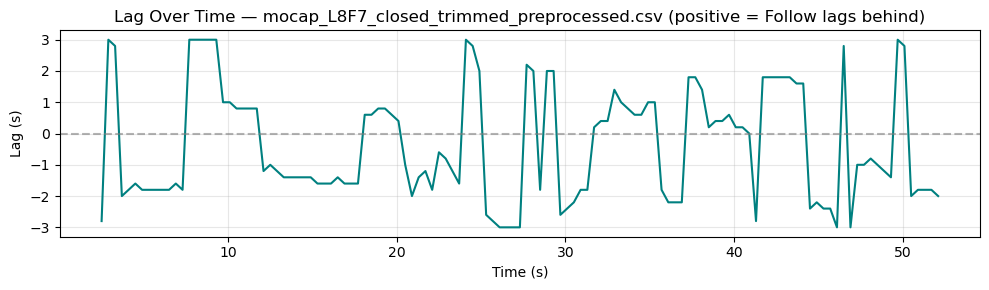


Processing windowed cross-corr: mocap_L8F7_open_trimmed_preprocessed.csv


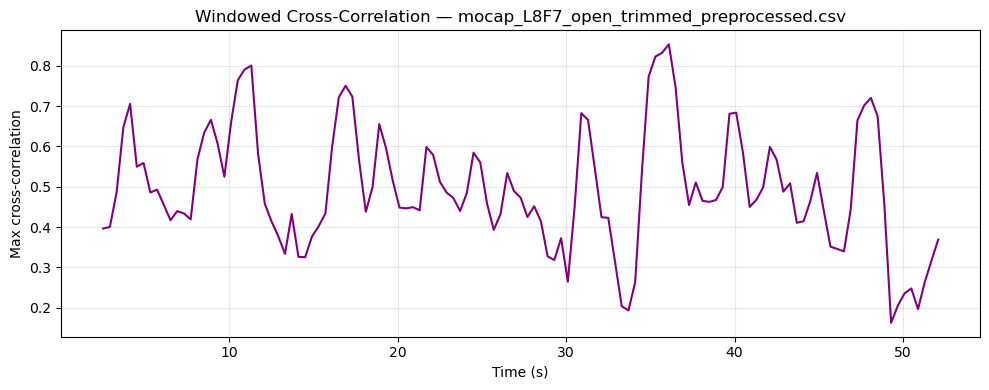

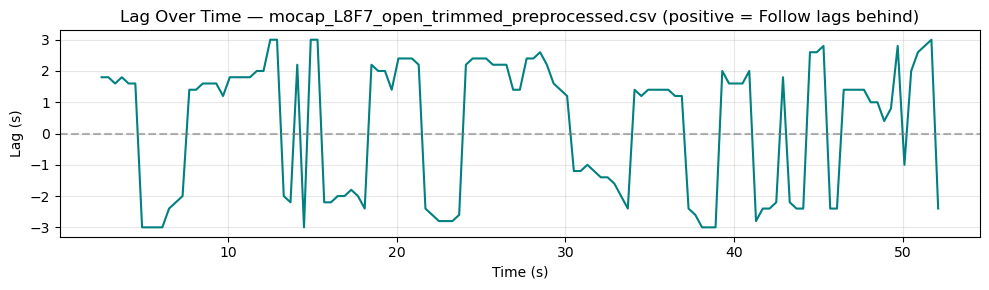


Processing windowed cross-corr: mocap_L8F8_closed_trimmed_preprocessed.csv


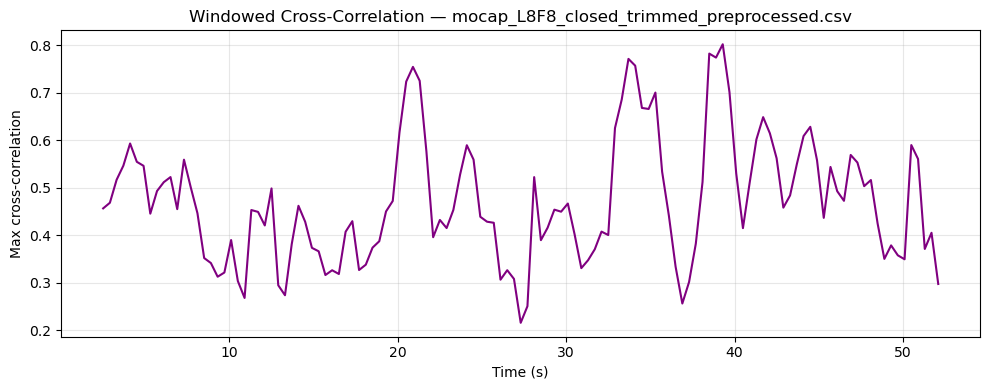

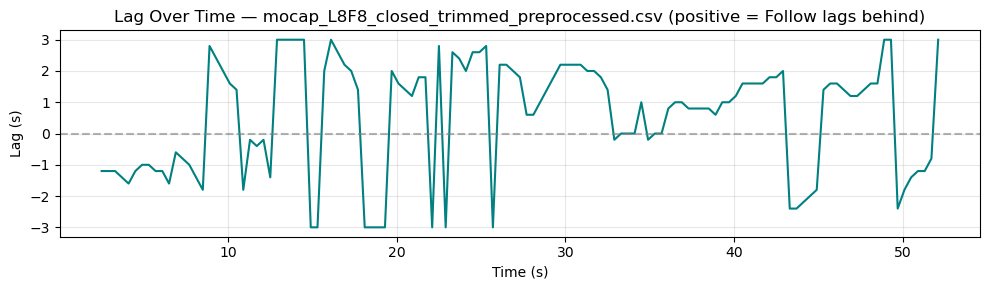


Processing windowed cross-corr: mocap_L8F8_open_trimmed_preprocessed.csv


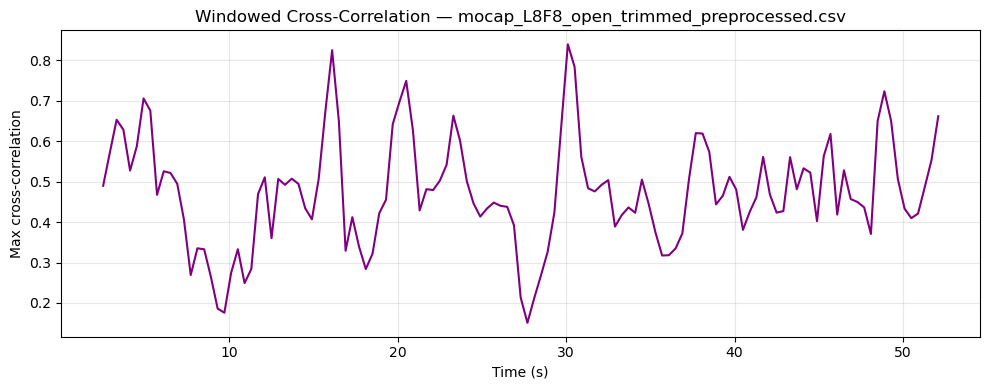

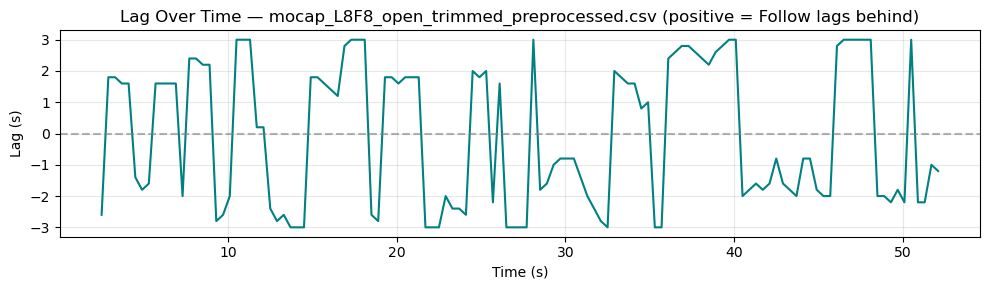


Processing windowed cross-corr: mocap_L9F10_closed_trimmed_preprocessed.csv


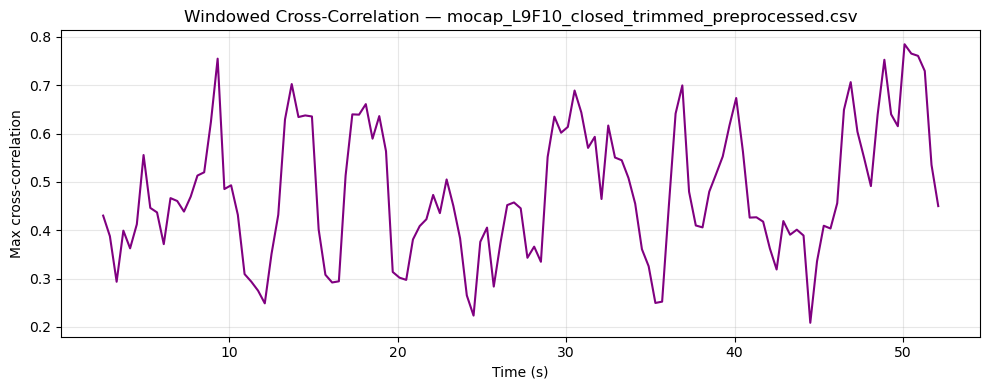

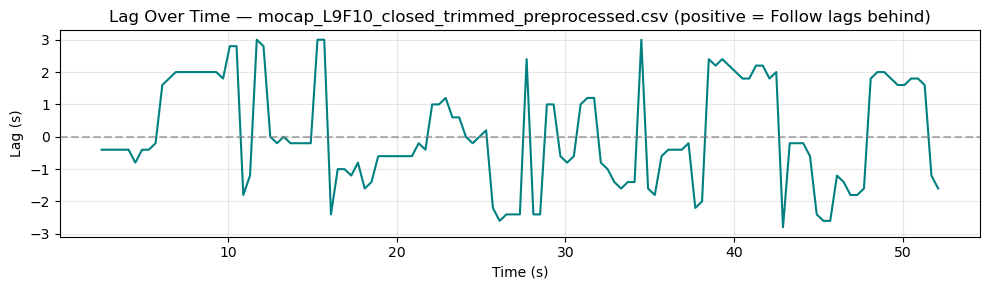


Processing windowed cross-corr: mocap_L9F10_open_trimmed_preprocessed.csv


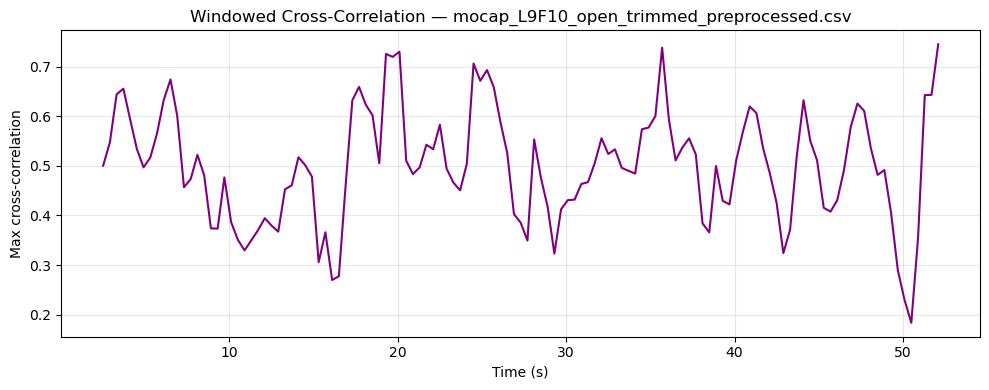

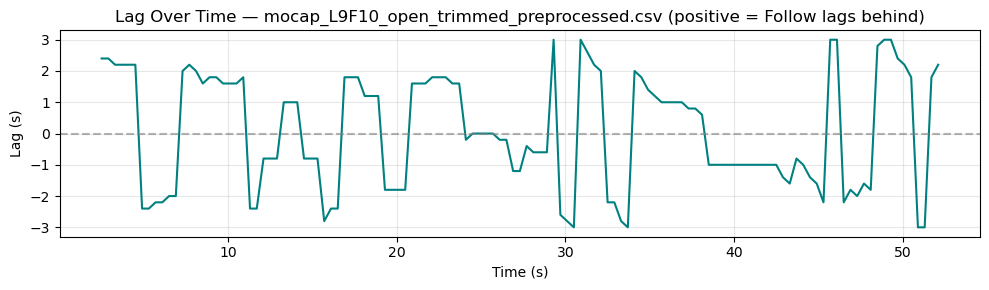


Processing windowed cross-corr: mocap_L9F9_closed_trimmed_preprocessed.csv


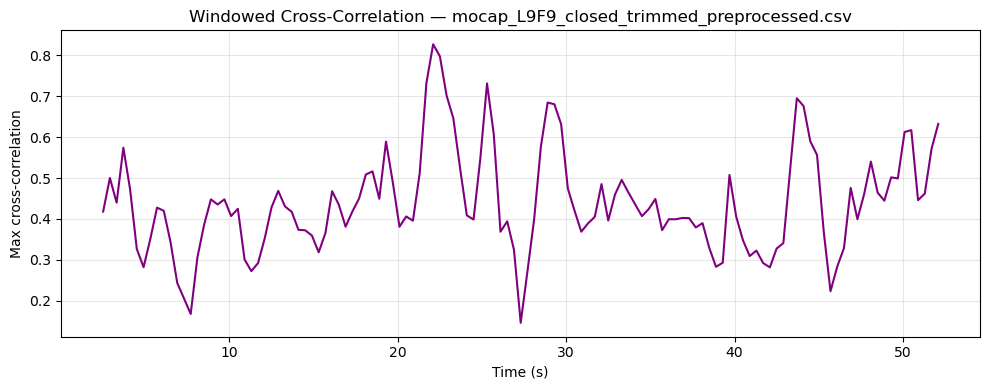

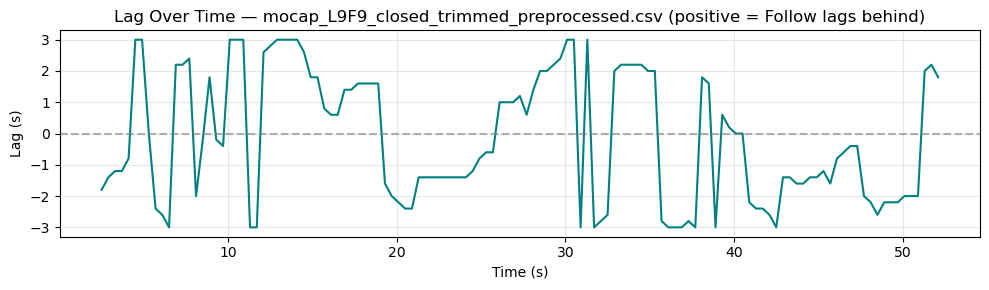


Processing windowed cross-corr: mocap_L9F9_open_trimmed_preprocessed.csv


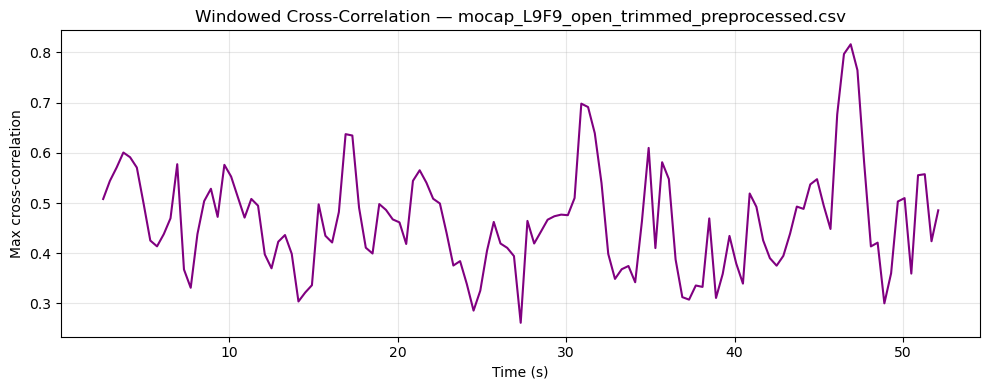

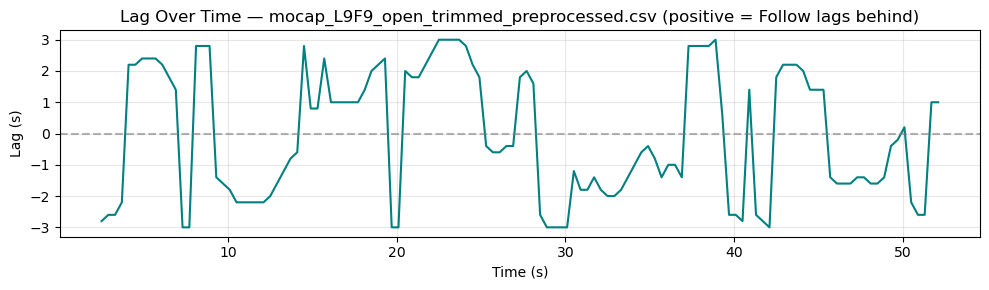


Saved windowed cross-correlation summary to:
c:\Users\au605619\Downloads\MoCap_labeled_trial\preprocessed_signals\windowed_crosscorr_summary.csv
                                            file  mean_windowed_corr  \
0   mocap_L10F10_closed_trimmed_preprocessed.csv            0.490608   
1     mocap_L10F10_open_trimmed_preprocessed.csv            0.537291   
2    mocap_L10F9_closed_trimmed_preprocessed.csv            0.523293   
3      mocap_L10F9_open_trimmed_preprocessed.csv            0.489302   
4   mocap_L11F11_closed_trimmed_preprocessed.csv            0.485979   
5     mocap_L11F11_open_trimmed_preprocessed.csv            0.476534   
6   mocap_L11F12_closed_trimmed_preprocessed.csv            0.467741   
7     mocap_L11F12_open_trimmed_preprocessed.csv            0.525467   
8   mocap_L12F11_closed_trimmed_preprocessed.csv            0.479679   
9     mocap_L12F11_open_trimmed_preprocessed.csv            0.502683   
10  mocap_L12F12_closed_trimmed_preprocessed.csv            0.

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# ============================================================
# CONFIGURATION
# ============================================================

DATA_DIR = Path.cwd() / "preprocessed_signals"   
TARGET_RATE = 5                                   # Hz
MAX_LAG_SEC = 3.0                                  # ±3 seconds lag
MAX_LAG = int(TARGET_RATE * MAX_LAG_SEC)

WINDOW_SEC = 5.0        # window length
STEP_SEC = 0.5          # sliding step

WINDOW = int(WINDOW_SEC * TARGET_RATE)
STEP = int(STEP_SEC * TARGET_RATE)

OUTPUT_SUMMARY = DATA_DIR / "windowed_crosscorr_summary.csv"

# ============================================================
# HELPER: normalized cross-correlation
# ============================================================

def crosscorr(x, y, max_lag):
    x = x - np.mean(x)
    y = y - np.mean(y)
    c_full = correlate(y, x, mode='full', method='auto')

    norm = np.sqrt(np.sum(x**2) * np.sum(y**2))
    c_full = c_full / norm

    lags = np.arange(-len(x) + 1, len(x))
    center = len(c_full) // 2
    idx = slice(center - max_lag, center + max_lag + 1)
    return lags[idx], c_full[idx]

# ============================================================
# MAIN WINDOWED ANALYSIS
# ============================================================

records = []

for csv_file in sorted(DATA_DIR.glob("*_trimmed_preprocessed.csv")):
    print(f"\nProcessing windowed cross-corr: {csv_file.name}")

    df = pd.read_csv(csv_file)

    time = df["Time_s"].to_numpy()
    lead = df["Lead_Y"].to_numpy()
    follow = df["Follow_Y"].to_numpy()

    corr_windows = []

    # Sliding window loop
    for start in range(0, len(lead) - WINDOW, STEP):
        end = start + WINDOW

        lead_seg = lead[start:end]
        follow_seg = follow[start:end]

        lags, corr_vals = crosscorr(lead_seg, follow_seg, MAX_LAG)

        max_corr = np.max(corr_vals)
        lag_at_max = lags[np.argmax(corr_vals)] / TARGET_RATE

        corr_windows.append({
            "time_center": (start + end) / 2 / TARGET_RATE,
            "corr_max": max_corr,
            "lag_sec": lag_at_max
        })

    wcdf = pd.DataFrame(corr_windows)

    # -------------------------------
    # Plot 1: windowed synchrony
    # -------------------------------
    plt.figure(figsize=(10, 4))
    plt.plot(wcdf["time_center"], wcdf["corr_max"], color="purple")
    plt.xlabel("Time (s)")
    plt.ylabel("Max cross-correlation")
    plt.title(f"Windowed Cross-Correlation — {csv_file.name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Plot 2: lag over time
    # -------------------------------
    plt.figure(figsize=(10, 3))
    plt.plot(wcdf["time_center"], wcdf["lag_sec"], color="teal")
    plt.axhline(0, color="gray", linestyle="--", alpha=0.6)
    plt.xlabel("Time (s)")
    plt.ylabel("Lag (s)")
    plt.title(f"Lag Over Time — {csv_file.name} (positive = Follow lags behind)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Store summary
    # -------------------------------
    records.append({
        "file": csv_file.name,
        "mean_windowed_corr": wcdf["corr_max"].mean(),
        "sd_windowed_corr": wcdf["corr_max"].std(),
        "max_windowed_corr": wcdf["corr_max"].max(),
        "mean_lag_sec": wcdf["lag_sec"].mean()
    })

# ============================================================
# SAVE SUMMARY CSV
# ============================================================

summary_df = pd.DataFrame(records)
summary_df.to_csv(OUTPUT_SUMMARY, index=False)

print("\nSaved windowed cross-correlation summary to:")
print(OUTPUT_SUMMARY)
print(summary_df)


# Parameter estimation and Windowed CRQA

## Prameter estimation

The signals are already pre-processed:  
- interpolated
- low-pass filtered
- downsampled to 10Hz
- z-scored
- trimmed

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cross_recurrence as crp  

# ============================================================
# CONFIGURATION
# ============================================================
data_folder = "preprocessed_signals_10Hz"
save_root = "CRQA_Parameter_Estimation_10Hz"
os.makedirs(save_root, exist_ok=True)

fs = 10.0  # Hz (downsampled rate of preprocessed signals)
target_rec = (1.0, 5.0)  # Target recurrence rate range (%)
results = []

# ============================================================
# UTILITIES
# ============================================================
def save_plot(fig, path):
    fig.savefig(path, dpi=300, bbox_inches='tight')
    plt.close(fig)

def first_local_minimum(y):
    y = np.asarray(y)
    for i in range(1, len(y) - 1):
        if y[i] < y[i - 1] and y[i] < y[i + 1]:
            return i
    return None

def hist_mutual_information(x, y, n_bins=32):
    H, _, _ = np.histogram2d(x, y, bins=n_bins)
    Pxy = H / np.sum(H)
    Px = np.sum(Pxy, axis=1, keepdims=True)
    Py = np.sum(Pxy, axis=0, keepdims=True)
    with np.errstate(divide="ignore", invalid="ignore"):
        log_term = np.log(Pxy / (Px @ Py))
    log_term[~np.isfinite(log_term)] = 0.0
    return float(np.sum(Pxy * log_term))

def auto_mutual_information(x, max_lag=50, n_bins=32):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    lags = np.arange(1, max_lag + 1)
    amis = []
    for τ in lags:
        x1 = x[:-τ]
        x2 = x[τ:]
        amis.append(hist_mutual_information(x1, x2, n_bins=n_bins))
    return lags, np.array(amis)

def ami_first_minimum(x, max_lag=50, n_bins=32):
    lags, ami = auto_mutual_information(x, max_lag=max_lag, n_bins=n_bins)
    idx = first_local_minimum(ami)
    τ = int(lags[idx]) if idx is not None else int(lags[np.argmin(ami)])
    return τ, lags, ami

def time_delay_embed(x, m, τ):
    x = np.asarray(x, dtype=float)
    N = len(x) - (m - 1) * τ
    if N <= 0:
        raise ValueError("Time series too short for requested m, τ.")
    return np.column_stack([x[i:i + N] for i in range(0, m * τ, τ)])

def fnn_rate(x, τ, m_max=10, Rtol=15.0, Atol=2.0, frac=1.0, seed=0):
    rng = np.random.default_rng(seed)
    stdx = np.std(x)
    m_vals = np.arange(1, m_max + 1)
    fnn = []

    for m in m_vals:
        Xm = time_delay_embed(x, m, τ)
        Xm1 = time_delay_embed(x, m + 1, τ)
        N = Xm1.shape[0]
        Xm = Xm[:N]

        if frac < 1.0:
            idx = rng.choice(N, size=max(100, int(frac * N)), replace=False)
            Xm_s, Xm1_s = Xm[idx], Xm1[idx]
        else:
            Xm_s, Xm1_s = Xm, Xm1

        fnn_count = 0
        for i in range(len(Xm_s)):
            xi = Xm_s[i]
            d2 = np.sum((Xm - xi) ** 2, axis=1)
            d2[i] = np.inf
            nn = np.argmin(d2)
            dist_m = np.sqrt(d2[nn])
            dist_m1 = np.sqrt(np.sum((Xm1_s[i] - Xm1[nn]) ** 2))

            ratio_flag = (dist_m > 0) and ((dist_m1 - dist_m) / dist_m > Rtol)
            abs_flag = (np.abs(Xm1_s[i, -1] - Xm1[nn, -1]) > Atol * stdx)

            if ratio_flag or abs_flag:
                fnn_count += 1
        fnn.append(100.0 * fnn_count / len(Xm_s))

    return m_vals, np.array(fnn)

def find_threshold_fast(data1, data2, dimension, delay1, delay2, norm,
                        target_rec=(1.0, 5.0), num_candidates=100):
    DM = crp.distance_matrix(data1, data2, dimension, delay1, delay2, norm)
    dists = DM.flatten()
    thresholds = np.linspace(np.min(dists), np.max(dists), num_candidates)
    results = [(th, np.sum(DM <= th) / DM.size * 100) for th in thresholds]

    valid = [(th, rec) for th, rec in results if target_rec[0] <= rec <= target_rec[1]]
    target_mid = np.mean(target_rec)

    if valid:
        best_th, _ = min(valid, key=lambda x: abs(x[1] - target_mid))
    else:
        best_th, _ = min(results, key=lambda x: abs(x[1] - target_mid))
    return best_th, results

# ============================================================
# MAIN LOOP
# ============================================================
files = sorted([f for f in os.listdir(data_folder) if f.endswith("_trimmed_preprocessed_10Hz.csv")])

for file_name in files:
    parts = file_name.replace(".csv", "").split("_")
    pair_id = parts[1]
    condition = parts[2]

    print(f"\n=== Processing {pair_id} ({condition}) ===")

    file_path = os.path.join(data_folder, file_name)
    plot_dir = os.path.join(save_root, pair_id, "plots")
    os.makedirs(plot_dir, exist_ok=True)

    # ----------------------------------------------------------
    # Load full trimmed preprocessed signal (NO cropping)
    # ----------------------------------------------------------
    df = pd.read_csv(file_path)
    lead = df["Lead_Y"].to_numpy()
    follow = df["Follow_Y"].to_numpy()

    # ============================================================
    # 1. AMI — Estimate τ
    # ============================================================
    τ_lead, lagsL, amiL = ami_first_minimum(lead, max_lag=25)
    τ_follow, lagsF, amiF = ami_first_minimum(follow, max_lag=25)

    for sig, lags, ami, τ_hat in [("Lead", lagsL, amiL, τ_lead), ("Follow", lagsF, amiF, τ_follow)]:
        fig, ax = plt.subplots()
        ax.plot(lags, ami, marker='o')
        ax.axvline(τ_hat, linestyle='--', color='r', label=f"τ̂={τ_hat} samples ≈ {τ_hat/fs:.2f}s")
        ax.set(title=f"AMI vs Lag — {sig} ({pair_id}, {condition})",
               xlabel="Lag τ (samples)", ylabel="AMI")
        ax.legend(); ax.grid(True)
        save_plot(fig, os.path.join(plot_dir, f"{pair_id}_{condition}_AMI_{sig}.png"))

    # ============================================================
    # 2. FNN — Estimate embedding dimension m
    # ============================================================
    fnn_params = dict(m_max=10, Rtol=20.0, Atol=3.0, frac=1.0)
    mL_vals, fnnL = fnn_rate(lead, τ_lead, **fnn_params)
    mF_vals, fnnF = fnn_rate(follow, τ_follow, **fnn_params)

    mL_suggest = next((m for m, p in zip(mL_vals, fnnL) if p < 5.0), None)
    mF_suggest = next((m for m, p in zip(mF_vals, fnnF) if p < 5.0), None)

    for sig, m_vals, fnn_pct, τ_hat, m_suggest in [
        ("Lead", mL_vals, fnnL, τ_lead, mL_suggest),
        ("Follow", mF_vals, fnnF, τ_follow, mF_suggest)
    ]:
        fig, ax = plt.subplots()
        ax.plot(m_vals, fnn_pct, marker='o')
        ax.axhline(5.0, linestyle='--', color='r')
        if m_suggest:
            ax.axvline(m_suggest, linestyle='--', color='g', label=f"m̂={m_suggest}")
        ax.set(title=f"FNN vs m — {sig} ({pair_id}, {condition}), τ={τ_hat}",
               xlabel="Embedding dimension m", ylabel="FNN (%)")
        ax.legend(); ax.grid(True)
        save_plot(fig, os.path.join(plot_dir, f"{pair_id}_{condition}_FNN_{sig}.png"))

    # ============================================================
    # 3. Optimize recurrence threshold ε
    # ============================================================
    if mL_suggest is None or mF_suggest is None:
        print(f"Skipping threshold estimation for {pair_id} ({condition}) — no valid m found.")
        continue

    dimension = min(mL_suggest, mF_suggest)
    best_th, th_results = find_threshold_fast(
        lead, follow,
        dimension=dimension,
        delay1=τ_lead,
        delay2=τ_follow,
        norm="euclidean",
        target_rec=target_rec
    )

    ths, recs = zip(*th_results)
    fig, ax = plt.subplots()
    ax.plot(ths, recs, '-o')
    ax.axhspan(*target_rec, color='red', alpha=0.2)
    ax.axvline(best_th, linestyle='--', color='k')
    ax.set(title=f"Threshold Optimization — {pair_id} ({condition})")
    ax.set(xlabel="Threshold (ε)", ylabel="Recurrence rate (%)")
    ax.grid(True)
    save_plot(fig, os.path.join(plot_dir, f"{pair_id}_{condition}_Threshold.png"))

    # ============================================================
    # 4. Store results
    # ============================================================
    results.append({
        "Pair": pair_id,
        "Condition": condition,
        "τ_lead (samples)": τ_lead,
        "τ_follow (samples)": τ_follow,
        "τ_lead (s)": τ_lead / fs,
        "τ_follow (s)": τ_follow / fs,
        "m_lead": mL_suggest,
        "m_follow": mF_suggest,
        "ε_best": best_th,
        "Embedding Dimension Used": dimension
    })

# ============================================================
# SAVE SUMMARY
# ============================================================
results_df = pd.DataFrame(results)
summary_path = os.path.join(save_root, "CRQA_Bounce_Parameter_Summary_10Hz.csv")
results_df.to_csv(summary_path, index=False)

print("\n======= CRQA PARAMETER SUMMARY (BOUNCE DATA) =======")
print(results_df.to_string(index=False))
print(f"\nAll plots and results saved in: {save_root}")



=== Processing L10F10 (closed) ===

=== Processing L10F10 (open) ===

=== Processing L10F9 (closed) ===

=== Processing L10F9 (open) ===

=== Processing L11F11 (closed) ===

=== Processing L11F11 (open) ===

=== Processing L11F12 (closed) ===

=== Processing L11F12 (open) ===

=== Processing L12F11 (closed) ===

=== Processing L12F11 (open) ===

=== Processing L12F12 (closed) ===

=== Processing L12F12 (open) ===

=== Processing L1F1 (closed) ===

=== Processing L1F1 (open) ===

=== Processing L1F2 (closed) ===

=== Processing L1F2 (open) ===

=== Processing L2F2 (closed) ===

=== Processing L2F2 (open) ===

=== Processing L3F3 (closed) ===

=== Processing L3F3 (open) ===

=== Processing L3F4 (closed) ===

=== Processing L3F4 (open) ===

=== Processing L4F3 (closed) ===

=== Processing L4F3 (open) ===

=== Processing L4F4 (closed) ===

=== Processing L4F4 (open) ===

=== Processing L5F5 (closed) ===

=== Processing L5F5 (free) ===

=== Processing L5F5 (open) ===

=== Processing L6F6 (

## Inspect data

In [22]:
# Load the CSV files
Parameters_CRQA_bounce_10Hz = pd.read_csv('CRQA_Parameter_Estimation_10Hz/CRQA_Bounce_Parameter_Summary_10Hz.csv')

In [23]:
print(Parameters_CRQA_bounce_10Hz)

      Pair Condition  τ_lead (samples)  τ_follow (samples)  τ_lead (s)  \
0   L10F10    closed                10                   7         1.0   
1   L10F10      open                 7                   8         0.7   
2    L10F9    closed                10                   7         1.0   
3    L10F9      open                 5                   9         0.5   
4   L11F11    closed                 8                   7         0.8   
5   L11F11      open                 9                  10         0.9   
6   L11F12    closed                 7                   9         0.7   
7   L11F12      open                 6                   9         0.6   
8   L12F11    closed                 5                   5         0.5   
9   L12F11      open                11                   8         1.1   
10  L12F12    closed                 7                   5         0.7   
11  L12F12      open                 9                  10         0.9   
12    L1F1    closed                 8

In [24]:
Parameters_CRQA_bounce_10Hz.describe()

τ_lead (samples)  τ_follow (samples)  τ_lead (s)  τ_follow (s)  \
count         43.000000           43.000000   43.000000     43.000000   
mean           8.302326            7.697674    0.830233      0.769767   
std            2.053277            1.725645    0.205328      0.172565   
min            5.000000            5.000000    0.500000      0.500000   
25%            7.000000            7.000000    0.700000      0.700000   
50%            8.000000            8.000000    0.800000      0.800000   
75%           10.000000            9.000000    1.000000      0.900000   
max           13.000000           12.000000    1.300000      1.200000   

          m_lead   m_follow     ε_best  Embedding Dimension Used  
count  43.000000  43.000000  43.000000                      43.0  
mean    3.023256   3.046512   0.641596                       3.0  
std     0.152499   0.213083   0.050267                       0.0  
min     3.000000   3.000000   0.544433                       3.0  
25%     3.000000   3.000000   0.611086                       3.0  
50%     3.000000   3.000000   0.633019                       3.0  
75%     3.000000   3.000000   0.667246                       3.0  
max     4.000000   4.000000   0.758711                       3.0

### Phase space diameter summary

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

# ============================================================
# CONFIGURATION
# ============================================================
data_folder = "preprocessed_signals"  
save_root = "CRQA_Parameter_Estimation"  
os.makedirs(save_root, exist_ok=True)

save_path = os.path.join(save_root, "Eps_GlobalRelative_to_PhaseSpace.csv")
plot_path = os.path.join(save_root, "Eps_Global_Percent_Distribution.png")

fs = 5.0  # sampling rate (Hz)
max_duration = 60.0  # seconds
max_samples = int(max_duration * fs)  # 300 samples

# Embedding parameters (same as CRQA)
m = 3
τ_lead = 5
τ_follow = 5

# global recurrence threshold from  parameter estimation
ε_global = 0.6

conditions = ["closed", "open"]

# ============================================================
# EMBEDDING FUNCTION
# ============================================================
def embed(x, m, τ):
    """Simple time-delay embedding."""
    N = len(x) - (m - 1) * τ
    if N <= 0:
        raise ValueError("Time series too short for embedding.")
    return np.column_stack([x[i:i + N] for i in range(0, m * τ, τ)])


# ============================================================
# MAIN LOOP
# ============================================================
results = []

files = sorted([f for f in os.listdir(data_folder) if f.endswith("_preprocessed.csv")])

for fname in files:
    filepath = os.path.join(data_folder, fname)
    print(f"Processing: {fname}")

    # Extract pair ID and condition from filename
    parts = fname.replace(".csv", "").split("_")
    pair_id = parts[1]
    condition = parts[2]

    # --- Load and trim to 60 s ---
    df = pd.read_csv(filepath)
    df = df.iloc[:max_samples]
    lead = df["Lead_Y"].to_numpy()
    follow = df["Follow_Y"].to_numpy()

    # --- Embed both signals ---
    try:
        X_lead = embed(lead, m, τ_lead)
        X_follow = embed(follow, m, τ_follow)
    except ValueError:
        print(f"Skipping {pair_id} ({condition}) — too short for embedding.")
        continue

    # --- Compute pairwise distances ---
    dist_lead = pdist(X_lead, metric="euclidean")
    dist_follow = pdist(X_follow, metric="euclidean")

    # --- Compute mean and max diameters ---
    Dmean_lead = np.mean(dist_lead)
    Dmax_lead = np.max(dist_lead)
    Dmean_follow = np.mean(dist_follow)
    Dmax_follow = np.max(dist_follow)

    # --- Compare ε_global to diameter ---
    eps_percent_lead = (ε_global / Dmean_lead) * 100
    eps_percent_follow = (ε_global / Dmean_follow) * 100

    results.append({
        "Pair": pair_id,
        "Condition": condition,
        "Lead_D_mean": Dmean_lead,
        "Follow_D_mean": Dmean_follow,
        "Eps_Global": ε_global,
        "Eps_as_%_Lead_Dmean": eps_percent_lead,
        "Eps_as_%_Follow_Dmean": eps_percent_follow
    })

# ============================================================
# SAVE RESULTS
# ============================================================
df_results = pd.DataFrame(results)
df_results.to_csv(save_path, index=False)

print("\nSaved phase-space diameter summary to:")
print(save_path)
print(df_results.head())

# ============================================================
# PLOT DISTRIBUTION
# ============================================================
plt.figure(figsize=(8, 5))
plt.hist(df_results["Eps_as_%_Lead_Dmean"], bins=20, alpha=0.6, label="Lead", color="royalblue")
plt.hist(df_results["Eps_as_%_Follow_Dmean"], bins=20, alpha=0.6, label="Follow", color="darkorange")
plt.axvline(df_results["Eps_as_%_Lead_Dmean"].median(), color="blue", linestyle="--", label="Lead median")
plt.axvline(df_results["Eps_as_%_Follow_Dmean"].median(), color="orange", linestyle="--", label="Follow median")
plt.xlabel("ε as % of mean phase-space diameter")
plt.ylabel("Count")
plt.title("Distribution of ε relative to Phase-Space Diameter")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.close()

print(f"Saved plot to: {plot_path}")

# ============================================================
# PRINT SUMMARY
# ============================================================
global_lead_mean = df_results["Lead_D_mean"].mean()
global_follow_mean = df_results["Follow_D_mean"].mean()

lead_mean_pct = (ε_global / global_lead_mean) * 100
follow_mean_pct = (ε_global / global_follow_mean) * 100

print("\n======= SUMMARY =======")
print(f"ε = {ε_global} corresponds to:")
print(f"  Lead:   {lead_mean_pct:.2f}% of global mean diameter")
print(f"  Follow: {follow_mean_pct:.2f}% of global mean diameter")


Processing: mocap_L10F10_closed_preprocessed.csv
Processing: mocap_L10F10_open_preprocessed.csv
Processing: mocap_L10F9_closed_preprocessed.csv
Processing: mocap_L10F9_open_preprocessed.csv
Processing: mocap_L11F11_closed_preprocessed.csv
Processing: mocap_L11F11_open_preprocessed.csv
Processing: mocap_L11F12_closed_preprocessed.csv
Processing: mocap_L11F12_open_preprocessed.csv
Processing: mocap_L12F11_closed_preprocessed.csv
Processing: mocap_L12F11_open_preprocessed.csv
Processing: mocap_L12F12_closed_preprocessed.csv
Processing: mocap_L12F12_open_preprocessed.csv
Processing: mocap_L1F1_closed_preprocessed.csv
Processing: mocap_L1F1_open_preprocessed.csv
Processing: mocap_L1F2_closed_preprocessed.csv
Processing: mocap_L1F2_open_preprocessed.csv
Processing: mocap_L2F2_closed_preprocessed.csv
Processing: mocap_L2F2_open_preprocessed.csv
Processing: mocap_L3F3_closed_preprocessed.csv
Processing: mocap_L3F3_open_preprocessed.csv
Processing: mocap_L3F4_closed_preprocessed.csv
Processing:

## Windowed CRQA

### ε = 0.6 

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Cross
from pyrqa.metric import EuclideanMetric
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation

# ============================================================
# CONFIGURATION
# ============================================================
data_folder = "preprocessed_signals_10Hz"
save_root = "Windowed_CRQA_10Hz"
os.makedirs(save_root, exist_ok=True)

fs = 10.0
max_duration = 55.0
max_samples = int(max_duration * fs)
conditions = ["closed", "open"]

# CRQA parameters
τ_lead = 6
τ_follow = 6
m = 3
ε = 0.6 
metric = EuclideanMetric()

# Windowing
window_size = 60  # samples (~6s)
step_size = 10     # samples (~1 s overlap)

results_summary = []

# ============================================================
# MAIN LOOP
# ============================================================
files = sorted([f for f in os.listdir(data_folder) if f.endswith("trimmed_preprocessed_10Hz.csv")])

for fname in files:
    parts = fname.replace(".csv", "").split("_")
    pair_id = parts[1]
    condition = parts[2]
    file_path = os.path.join(data_folder, fname)

    print(f"\n=== Running Windowed CRQA for {pair_id} ({condition}) ===")

    df = pd.read_csv(file_path).iloc[:max_samples]
    lead = df["Lead_Y"].to_numpy()
    follow = df["Follow_Y"].to_numpy()

    results_windowed = []
    skipped_windows = 0
    n = len(lead)

    for start in range(0, n - window_size, step_size):
        end = start + window_size
        lead_seg = lead[start:end]
        follow_seg = follow[start:end]

        if np.isnan(lead_seg).any() or np.isnan(follow_seg).any():
            continue

        ts_lead = TimeSeries(lead_seg, embedding_dimension=m, time_delay=τ_lead)
        ts_follow = TimeSeries(follow_seg, embedding_dimension=m, time_delay=τ_follow)

        settings = Settings(
            time_series=[ts_lead, ts_follow],
            analysis_type=Cross,
            neighbourhood=FixedRadius(ε),
            similarity_measure=metric,
            theiler_corrector=1
        )

        comp = RQAComputation.create(settings, verbose=False)
        result = comp.run()

        if np.isnan(result.recurrence_rate) or np.isnan(result.determinism):
            skipped_windows += 1
            continue

        results_windowed.append({
            "start_sample": start,
            "center_time": (start + window_size / 2) / fs,
            "RR": result.recurrence_rate,
            "DET": result.determinism,
            "LAM": result.laminarity,
            "L_max": result.longest_diagonal_line,
            "V_max": result.longest_vertical_line
        })

    if not results_windowed:
        print(f"No valid windows for {pair_id} ({condition}).")
        continue

    df_wcrqa = pd.DataFrame(results_windowed)
    pair_save_dir = os.path.join(save_root, pair_id)
    os.makedirs(pair_save_dir, exist_ok=True)

    # Plot RR
    plt.figure(figsize=(10, 5))
    plt.plot(df_wcrqa["center_time"], df_wcrqa["RR"], "-o", color="royalblue")
    plt.title(f"Windowed CRQA — RR over time\n{pair_id} ({condition})")
    plt.xlabel("Time (s)")
    plt.ylabel("Recurrence Rate")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(pair_save_dir, f"{pair_id}_{condition}_RR_over_time.png"), dpi=300)
    plt.close()

    # Summary
    features = {
        "Pair": pair_id,
        "Condition": condition,
        "mean_RR": df_wcrqa["RR"].mean(),
        "std_RR": df_wcrqa["RR"].std(),
        "max_RR": df_wcrqa["RR"].max(),
        "mean_DET": df_wcrqa["DET"].mean(),
        "mean_LAM": df_wcrqa["LAM"].mean(),
        "skipped_windows": skipped_windows
    }
    results_summary.append(features)

    # Save
    df_wcrqa.to_csv(os.path.join(pair_save_dir, f"{pair_id}_{condition}_Windowed_CRQA_10Hz.csv"), index=False)
    pd.DataFrame([features]).to_csv(os.path.join(pair_save_dir, f"{pair_id}_{condition}_CRQA_Summary_10Hz.csv"), index=False)

# Final summary
results_df = pd.DataFrame(results_summary)
results_df.to_csv(os.path.join(save_root, "CRQA_Windowed_Summary_AllPairs_10Hz.csv"), index=False)
print("\n======= WINDOWED CRQA SUMMARY =======")
print(results_df.to_string(index=False))
print(f"\nAll plots and results saved in: {save_root}")



=== Running Windowed CRQA for L10F10 (closed) ===

=== Running Windowed CRQA for L10F10 (open) ===

=== Running Windowed CRQA for L10F9 (closed) ===

=== Running Windowed CRQA for L10F9 (open) ===

=== Running Windowed CRQA for L11F11 (closed) ===

=== Running Windowed CRQA for L11F11 (open) ===

=== Running Windowed CRQA for L11F12 (closed) ===

=== Running Windowed CRQA for L11F12 (open) ===

=== Running Windowed CRQA for L12F11 (closed) ===

=== Running Windowed CRQA for L12F11 (open) ===

=== Running Windowed CRQA for L12F12 (closed) ===

=== Running Windowed CRQA for L12F12 (open) ===

=== Running Windowed CRQA for L1F1 (closed) ===

=== Running Windowed CRQA for L1F1 (open) ===

=== Running Windowed CRQA for L1F2 (closed) ===

=== Running Windowed CRQA for L1F2 (open) ===

=== Running Windowed CRQA for L2F2 (closed) ===

=== Running Windowed CRQA for L2F2 (open) ===

=== Running Windowed CRQA for L3F3 (closed) ===

=== Running Windowed CRQA for L3F3 (open) ===

=== Running Windo

### Inspect results

In [137]:
# Load the CSV files
CRQA_Windowed_Summary_AllPairs_10Hz= pd.read_csv('Windowed_CRQA_10Hz/CRQA_Windowed_Summary_AllPairs_10Hz.csv')

In [139]:
print(CRQA_Windowed_Summary_AllPairs_10Hz)

      Pair Condition   mean_RR    std_RR    max_RR  mean_DET  mean_LAM  \
0   L10F10    closed  0.028838  0.017350  0.070312  0.491386  0.614129   
1   L10F10      open  0.021332  0.014313  0.063368  0.539947  0.684387   
2    L10F9    closed  0.020569  0.017348  0.071615  0.463365  0.655682   
3    L10F9      open  0.022953  0.014108  0.060330  0.544087  0.757532   
4   L11F11    closed  0.016642  0.011777  0.046875  0.585916  0.769181   
5   L11F11      open  0.027995  0.019730  0.064236  0.617921  0.792091   
6   L11F12    closed  0.024068  0.026118  0.087674  0.505782  0.710545   
7   L11F12      open  0.031973  0.029950  0.128472  0.678359  0.901454   
8   L12F11    closed  0.041884  0.036993  0.137587  0.488904  0.696759   
9   L12F11      open  0.030585  0.029938  0.134549  0.562083  0.713927   
10  L12F12    closed  0.023645  0.016364  0.080295  0.619988  0.834606   
11  L12F12      open  0.026254  0.020508  0.095486  0.606476  0.882965   
12    L1F1    closed  0.015516  0.0122

In [138]:
CRQA_Windowed_Summary_AllPairs_10Hz.describe()

mean_RR     std_RR     max_RR   mean_DET   mean_LAM  skipped_windows
count  43.000000  43.000000  43.000000  43.000000  43.000000        43.000000
mean    0.027292   0.025083   0.104944   0.586886   0.782851         6.488372
std     0.008057   0.017439   0.074687   0.074171   0.072105         5.284173
min     0.015516   0.011777   0.037760   0.462224   0.614129         0.000000
25%     0.022456   0.016005   0.063802   0.530164   0.750878         3.000000
50%     0.025736   0.020271   0.082031   0.580551   0.790458         5.000000
75%     0.029476   0.026030   0.118056   0.637591   0.844208         9.000000
max     0.051157   0.099782   0.464410   0.755253   0.901454        18.000000

In [29]:
M = results_df["mean_RR"].mean() * 100
SD = results_df["mean_RR"].std() * 100
print(f"Mean windowed RR = {M:.2f}% (SD = {SD:.2f}%)")

Mean windowed RR = 2.73% (SD = 0.81%)


In [34]:
total_windows = 50  # per trial

print("Overall skipped window percentage:", 
      CRQA_Windowed_Summary_AllPairs_10Hz["skipped_windows"].sum() / (len(CRQA_Windowed_Summary_AllPairs_10Hz) * total_windows) * 100, "%")


Overall skipped window percentage: 12.976744186046513 %


There is one pair in free condition

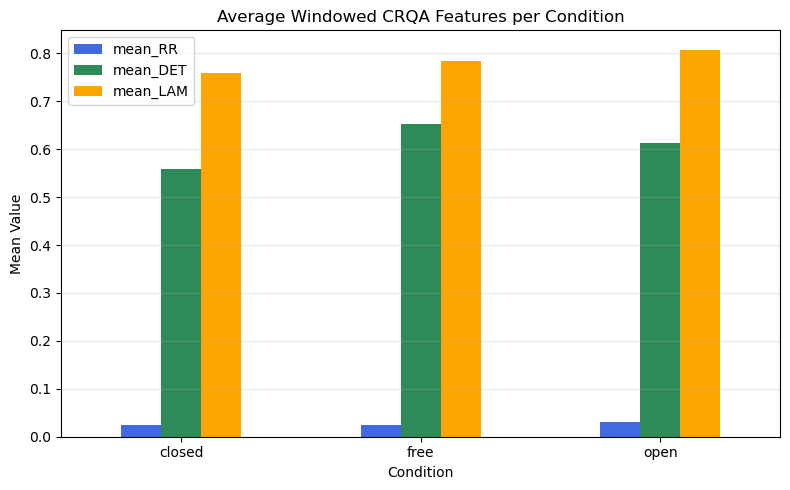

In [36]:
summary = results_df.groupby("Condition")[["mean_RR", "mean_DET", "mean_LAM"]].mean()
summary.plot(kind="bar", figsize=(8,5), color=["royalblue", "seagreen", "orange"])
plt.ylabel("Mean Value")
plt.title("Average Windowed CRQA Features per Condition")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

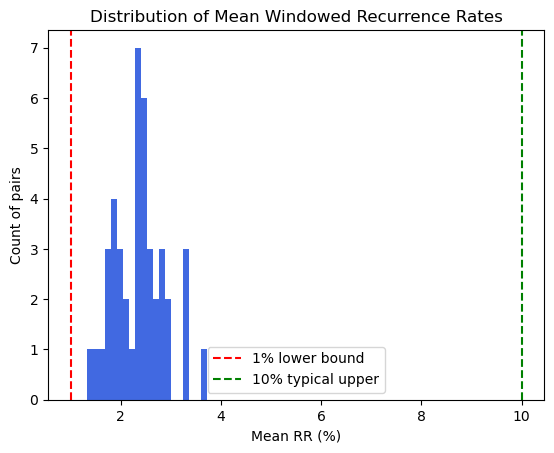

In [27]:
import matplotlib.pyplot as plt
plt.hist(results_df['mean_RR']*100, bins=20, color='royalblue')
plt.xlabel('Mean RR (%)')
plt.ylabel('Count of pairs')
plt.title('Distribution of Mean Windowed Recurrence Rates')
plt.axvline(1, color='red', linestyle='--', label='1% lower bound')
plt.axvline(10, color='green', linestyle='--', label='10% typical upper')
plt.legend()
plt.show()

# Check window and step sizes

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Cross
from pyrqa.metric import EuclideanMetric
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation

# ============================================================
# CONFIGURATION
# ============================================================
data_folder = "preprocessed_signals_10Hz"
save_root = "Windowed_CRQA_10Hz_ParamSearch"
os.makedirs(save_root, exist_ok=True)

fs = 10.0
max_duration = 55.0
max_samples = int(max_duration * fs)
conditions = ["closed", "open"]

# --- fixed CRQA parameters ---
τ_lead = 2
τ_follow = 2
m = 2
ε = 0.8
metric = EuclideanMetric()

# --- parameters to test ---
window_sizes = [10, 20, 40]   # samples (1s, 2s, 4s)
step_sizes = [5, 10]     # samples

# ============================================================
# FILE LIST
# ============================================================
files = sorted([
    f for f in os.listdir(data_folder)
    if f.endswith("trimmed_preprocessed_10Hz.csv")
])

# ============================================================
# PARAMETER SEARCH
# ============================================================
param_summary = []

for window_size, step_size in product(window_sizes, step_sizes):

    print("\n====================================")
    print(f"Testing window={window_size}, step={step_size}")
    print("====================================")

    results_summary = []
    total_skipped_windows = 0
    total_pairs = 0
    total_pairs_skipped = 0

    # --------------------------------------------------------
    # Iterate through files (pairs × conditions)
    # --------------------------------------------------------
    for fname in files:

        parts = fname.replace(".csv", "").split("_")
        pair_id = parts[1]
        condition = parts[2]

        if condition not in conditions:
            continue

        file_path = os.path.join(data_folder, fname)
        df = pd.read_csv(file_path).iloc[:max_samples]

        lead = df["Lead_Y"].to_numpy()
        follow = df["Follow_Y"].to_numpy()
        n = len(lead)

        results_windowed = []
        skipped_windows = 0

        for start in range(0, n - window_size, step_size):
            end = start + window_size

            lead_seg = lead[start:end]
            follow_seg = follow[start:end]

            if np.isnan(lead_seg).any() or np.isnan(follow_seg).any():
                skipped_windows += 1
                continue

            ts_lead = TimeSeries(
                lead_seg,
                embedding_dimension=m,
                time_delay=τ_lead
            )
            ts_follow = TimeSeries(
                follow_seg,
                embedding_dimension=m,
                time_delay=τ_follow
            )

            settings = Settings(
                time_series=[ts_lead, ts_follow],
                analysis_type=Cross,
                neighbourhood=FixedRadius(ε),
                similarity_measure=metric,
                theiler_corrector=1
            )

            comp = RQAComputation.create(settings, verbose=False)
            result = comp.run()

            if np.isnan(result.recurrence_rate) or np.isnan(result.determinism):
                skipped_windows += 1
                continue

            results_windowed.append({
                "RR": result.recurrence_rate,
                "DET": result.determinism,
                "LAM": result.laminarity,
                "L_max": result.longest_diagonal_line,
                "V_max": result.longest_vertical_line
            })

        total_pairs += 1
        total_skipped_windows += skipped_windows

        if len(results_windowed) == 0:
            total_pairs_skipped += 1
            continue

        df_w = pd.DataFrame(results_windowed)

        results_summary.append({
            "Pair": pair_id,
            "Condition": condition,
            "mean_RR": df_w["RR"].mean(),
            "mean_DET": df_w["DET"].mean(),
            "mean_LAM": df_w["LAM"].mean(),
            "mean_L_max": df_w["L_max"].mean(),
            "mean_V_max": df_w["V_max"].mean(),
            "skipped_windows": skipped_windows
        })

    # --------------------------------------------------------
    # Save per-parameter summary
    # --------------------------------------------------------
    df_results = pd.DataFrame(results_summary)

    param_dir = os.path.join(
        save_root, f"w{window_size}_s{step_size}"
    )
    os.makedirs(param_dir, exist_ok=True)

    df_results.to_csv(
        os.path.join(param_dir, "Windowed_CRQA_Summary.csv"),
        index=False
    )

    # --------------------------------------------------------
    # Meta-summary across all pairs
    # --------------------------------------------------------
    param_summary.append({
        "window_size": window_size,
        "step_size": step_size,
        "total_pairs": total_pairs,
        "pairs_with_no_valid_windows": total_pairs_skipped,
        "skipped_windows_total": total_skipped_windows,
        "mean_skipped_windows_per_pair": (
            total_skipped_windows / max(total_pairs, 1)
        ),
        "mean_RR": df_results["mean_RR"].mean()
            if not df_results.empty else np.nan,
        "mean_DET": df_results["mean_DET"].mean()
            if not df_results.empty else np.nan,
        "mean_LAM": df_results["mean_LAM"].mean()
            if not df_results.empty else np.nan
    })

# ============================================================
# FINAL PARAMETER COMPARISON
# ============================================================
param_summary_df = pd.DataFrame(param_summary)
param_summary_path = os.path.join(
    save_root, "ParamSearch_Summary_10Hz.csv"
)
param_summary_df.to_csv(param_summary_path, index=False)

print("\n========= PARAMETER COMPARISON SUMMARY =========")
print(param_summary_df.to_string(index=False))
print(f"\nAll summaries saved in: {save_root}")



Testing window=10, step=5

Testing window=10, step=10

Testing window=20, step=5

Testing window=20, step=10

Testing window=40, step=5

Testing window=40, step=10

========= PARAMETER COMPARISON SUMMARY =========
 window_size  step_size  total_pairs  pairs_with_no_valid_windows  skipped_windows_total  mean_skipped_windows_per_pair  mean_RR  mean_DET  mean_LAM
          10          5           42                            0                   2366                      56.333333 0.348046  0.623844  0.827319
          10         10           42                            0                   1186                      28.238095 0.351427  0.630129  0.832922
          20          5           42                            0                    998                      23.761905 0.229091  0.769077  0.893229
          20         10           42                            0                    498                      11.857143 0.229907  0.767708  0.894002
          40          5           42    

#### Df for regression

In [141]:
CRQA_Windowed_Summary_AllPairs_10Hz = CRQA_Windowed_Summary_AllPairs_10Hz.rename(columns={"Pair": "Pair_ID"})


In [143]:
CRQA_Windowed_Summary_AllPairs_10Hz["Lead_ID"] = CRQA_Windowed_Summary_AllPairs_10Hz["Pair_ID"].str.extract(r"(L\d+)")
CRQA_Windowed_Summary_AllPairs_10Hz["Follow_ID"] = CRQA_Windowed_Summary_AllPairs_10Hz["Pair_ID"].str.extract(r"(F\d+)")


In [144]:
long_df = CRQA_Windowed_Summary_AllPairs_10Hz.melt(
    id_vars=["Pair_ID", "Condition", "mean_RR", "std_RR", "max_RR", "mean_DET", "mean_LAM"],
    value_vars=["Lead_ID", "Follow_ID"],
    var_name="Role_temp",
    value_name="Participant_ID"
)


In [145]:
long_df["Role"] = long_df["Participant_ID"].apply(
    lambda x: "Lead" if x.startswith("L") else "Follow"
)


In [146]:
print(long_df)

   Pair_ID Condition   mean_RR    std_RR    max_RR  mean_DET  mean_LAM  \
0   L10F10    closed  0.028838  0.017350  0.070312  0.491386  0.614129   
1   L10F10      open  0.021332  0.014313  0.063368  0.539947  0.684387   
2    L10F9    closed  0.020569  0.017348  0.071615  0.463365  0.655682   
3    L10F9      open  0.022953  0.014108  0.060330  0.544087  0.757532   
4   L11F11    closed  0.016642  0.011777  0.046875  0.585916  0.769181   
5   L11F11      open  0.027995  0.019730  0.064236  0.617921  0.792091   
6   L11F12    closed  0.024068  0.026118  0.087674  0.505782  0.710545   
7   L11F12      open  0.031973  0.029950  0.128472  0.678359  0.901454   
8   L12F11    closed  0.041884  0.036993  0.137587  0.488904  0.696759   
9   L12F11      open  0.030585  0.029938  0.134549  0.562083  0.713927   
10  L12F12    closed  0.023645  0.016364  0.080295  0.619988  0.834606   
11  L12F12      open  0.026254  0.020508  0.095486  0.606476  0.882965   
12    L1F1    closed  0.015516  0.0122

In [147]:
# remove a helper column
long_df = long_df.drop(columns=["Role_temp"])

# reorder columns
long_df = long_df[
    [
        "Pair_ID",
        "Participant_ID",
        "Role",
        "Condition",
        "mean_RR",
        "std_RR",
        "max_RR",
        "mean_DET",
        "mean_LAM",
    ]
]


In [148]:
print(long_df)

   Pair_ID Participant_ID    Role Condition   mean_RR    std_RR    max_RR  \
0   L10F10            L10    Lead    closed  0.028838  0.017350  0.070312   
1   L10F10            L10    Lead      open  0.021332  0.014313  0.063368   
2    L10F9            L10    Lead    closed  0.020569  0.017348  0.071615   
3    L10F9            L10    Lead      open  0.022953  0.014108  0.060330   
4   L11F11            L11    Lead    closed  0.016642  0.011777  0.046875   
5   L11F11            L11    Lead      open  0.027995  0.019730  0.064236   
6   L11F12            L11    Lead    closed  0.024068  0.026118  0.087674   
7   L11F12            L11    Lead      open  0.031973  0.029950  0.128472   
8   L12F11            L12    Lead    closed  0.041884  0.036993  0.137587   
9   L12F11            L12    Lead      open  0.030585  0.029938  0.134549   
10  L12F12            L12    Lead    closed  0.023645  0.016364  0.080295   
11  L12F12            L12    Lead      open  0.026254  0.020508  0.095486   

In [149]:
# z-score

crqa_vars = [
    "mean_RR",
    "std_RR",
    "max_RR",
    "mean_DET",
    "mean_LAM"
]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
long_df[[f"{v}_z" for v in crqa_vars]] = scaler.fit_transform(long_df[crqa_vars])

# check
long_df[[f"{v}_z" for v in crqa_vars]].describe()


mean_RR_z      std_RR_z      max_RR_z    mean_DET_z    mean_LAM_z
count  8.600000e+01  8.600000e+01  8.600000e+01  8.600000e+01  8.600000e+01
mean   6.099772e-16  1.169930e-16 -1.484601e-16 -6.854982e-16  1.356150e-15
std    1.005865e+00  1.005865e+00  1.005865e+00  1.005865e+00  1.005865e+00
min   -1.478806e+00 -7.720548e-01 -9.101831e-01 -1.700632e+00 -2.367642e+00
25%   -6.384833e-01 -5.371687e-01 -5.603178e-01 -7.749382e-01 -4.653816e-01
50%   -1.954618e-01 -2.792205e-01 -3.104140e-01 -8.643007e-02  1.067394e-01
75%    2.759085e-01  5.564398e-02  1.893936e-01  7.001641e-01  8.624499e-01
max    2.996959e+00  4.334085e+00  4.869944e+00  2.296834e+00  1.664323e+00

In [154]:
# remove "free" condition (one pair had also data available for this condition) due to not having other pairs' results in this condition
long_df = long_df[long_df["Condition"] != "free"]


In [155]:
long_df.shape[0]

84

In [156]:
long_df.to_csv("Bounce_wCRQA_Regression_Ready.csv", index=False)

### Summary and Plots

In [10]:
# Load the CSV files
df = pd.read_csv('Bounce_wCRQA_Regression_Ready.csv')

### Facet wrap

##### LAM and DET


C:\Users\au605619\AppData\Local\Temp\ipykernel_13380\3204661301.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


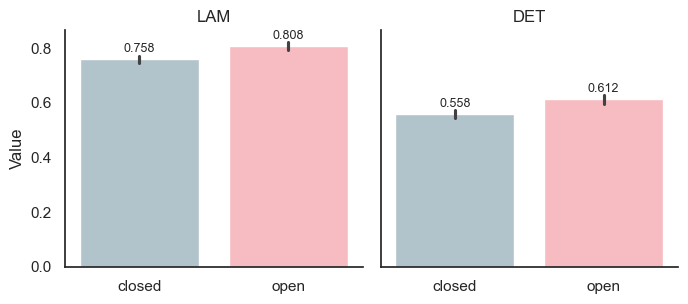

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Use pair-level rows (drop duplicated Role/Participant rows) ---
pair_df = df.drop_duplicates(subset=["Pair_ID", "Condition"]).copy()

# --- Select metrics: LAM, DET ---
metric_map = {"LAM": "mean_LAM", "DET": "mean_DET"}
metric_map = {k: v for k, v in metric_map.items() if v in pair_df.columns}

selected = ["LAM", "DET"]
selected = [m for m in selected if m in metric_map]

if not selected:
    raise ValueError("None of the selected metric columns were found in df (mean_LAM / mean_DET).")

# --- Long/tidy for seaborn facet (NO Role) ---
dfm = pair_df.melt(
    id_vars=["Pair_ID", "Condition"],
    value_vars=[metric_map[m] for m in selected],
    var_name="metric_col",
    value_name="value"
)
dfm["Metric"] = dfm["metric_col"].map({v: k for k, v in metric_map.items()})

# Optional: enforce condition order
condition_order = ["closed", "open"]
dfm["Condition"] = pd.Categorical(dfm["Condition"], categories=condition_order, ordered=True)

# Pastel colors
palette = {"closed": "#AEC6CF", "open": "#FFB3BA"}

sns.set_theme(style="white")  


g = sns.catplot(
    data=dfm,
    kind="bar",
    x="Condition", y="value",
    col="Metric",
    col_wrap=2,
    errorbar="se",
    palette=palette,
    height=3.2, aspect=1.1
)

g.set_axis_labels("", "Value")
g.set_titles("{col_name}")


for ax in g.axes.flatten():
    ax.grid(False)


for ax in g.axes.flatten():
    for container in ax.containers:
        labels = []
        for bar in container:
            h = bar.get_height()
            labels.append("" if (h is None or np.isnan(h)) else f"{h:.3f}")
        ax.bar_label(container, labels=labels, padding=3, fontsize=9)

g.tight_layout()
plt.show()


##### RR

C:\Users\au605619\AppData\Local\Temp\ipykernel_13380\1412048069.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


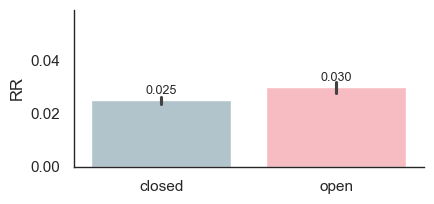

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Use pair-level rows (drop duplicated Role/Participant rows) ---
pair_df = df.drop_duplicates(subset=["Pair_ID", "Condition"]).copy()

# --- Select metric: RR ---
metric_col = "mean_RR"
if metric_col not in pair_df.columns:
    raise ValueError("Column mean_RR was not found in df.")

condition_order = ["closed", "open"]
pair_df["Condition"] = pd.Categorical(pair_df["Condition"], categories=condition_order, ordered=True)

# Pastel colors
palette = {"closed": "#AEC6CF", "open": "#FFB3BA"}

sns.set_theme(style="white")  # no grid by default

# --- Single bar plot: RR by Condition ---
fig, ax = plt.subplots(figsize=(4.5, 2.2))

sns.barplot(
    data=pair_df,
    x="Condition", y=metric_col,
    errorbar="se",
    palette=palette,
    ax=ax
)

ax.set_xlabel("")
ax.set_ylabel("RR")
ax.set_title("")  
ax.grid(False)


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)


ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)


ymax = pair_df[metric_col].max(skipna=True)
ax.set_ylim(0, ymax * 1.15)


y0, y1 = ax.get_ylim()
offset = 0.02 * (y1 - y0)

for container in ax.containers:
    for bar in container:
        h = bar.get_height()
        if h is None or np.isnan(h):
            continue
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + offset,
            f"{h:.3f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.tight_layout()
plt.show()


#### T-tests

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats


# ----------------------------
# 2) Paired open vs closed tests (PAIR-LEVEL, conditions only)
# ----------------------------

def paired_open_closed_conditions_only(
    df_in: pd.DataFrame,
    metric_col: str,
    pair_id_col: str = "Pair_ID",
    condition_col: str = "Condition",
    condition_order=("closed", "open"),
):
    """
    Paired-samples t test: open vs closed at the dyad (pair) level.

    Returns descriptives (M, SD, SE) per condition, paired t test,
    Cohen's dz, mean difference (open-closed) with 95% CI.
    """
    # Safety checks
    needed = {pair_id_col, condition_col, metric_col}
    missing = needed - set(df_in.columns)
    if missing:
        return None

    # One row per Pair_ID x Condition (prevents Lead/Follow duplication)
    pair_df = df_in.drop_duplicates(subset=[pair_id_col, condition_col]).copy()

    # Wide format: index = Pair_ID, columns = Condition
    wide = (
        pair_df.pivot_table(index=pair_id_col, columns=condition_col, values=metric_col, aggfunc="mean")
        .reindex(columns=list(condition_order))
    )

   
    if not all(c in wide.columns for c in condition_order):
        return None

    wide = wide.dropna(subset=list(condition_order))
    n = len(wide)
    if n < 2:
        return None

    x_closed = wide[condition_order[0]].to_numpy(dtype=float)
    x_open = wide[condition_order[1]].to_numpy(dtype=float)

    # Descriptives per condition
    def desc(x):
        n_ = len(x)
        m = float(np.mean(x))
        sd = float(np.std(x, ddof=1)) if n_ > 1 else np.nan
        se = sd / np.sqrt(n_) if n_ > 1 else np.nan
        return m, sd, se

    m_closed, sd_closed, se_closed = desc(x_closed)
    m_open, sd_open, se_open = desc(x_open)

    # Paired t test
    t, p = stats.ttest_rel(x_open, x_closed)

    # Differences
    diff = x_open - x_closed
    mdiff = float(np.mean(diff))
    sd_diff = float(np.std(diff, ddof=1)) if n > 1 else np.nan
    se_diff = sd_diff / np.sqrt(n) if n > 1 else np.nan

    # Effect size: Cohen's dz = mean(diff) / sd(diff)
    dz = mdiff / sd_diff if (n > 1 and sd_diff != 0 and np.isfinite(sd_diff)) else np.nan

    # 95% CI for mean difference (t-based)
    if n > 1 and np.isfinite(se_diff):
        tcrit = stats.t.ppf(0.975, df=n - 1)
        ci_low = mdiff - tcrit * se_diff
        ci_high = mdiff + tcrit * se_diff
    else:
        ci_low, ci_high = np.nan, np.nan

    return {
        "metric": metric_col,
        "n_pairs": int(n),
        "closed_M": m_closed,
        "closed_SD": sd_closed,
        "closed_SE": se_closed,
        "open_M": m_open,
        "open_SD": sd_open,
        "open_SE": se_open,
        "mean_diff_open_minus_closed": mdiff,
        "diff_ci95_low": float(ci_low),
        "diff_ci95_high": float(ci_high),
        "t": float(t),
        "df": int(n - 1),
        "p": float(p),
        "cohens_dz": float(dz),
    }


def fmt_p(p):
    if p < 0.001:
        return "< .001"
    return f"= {p:.3f}".replace("0.", ".")

def apa_line(res, label=None, use_sd=True, decimals=3):
    """
    Make a compact APA-style line.
    use_sd=True -> report M, SD; else report M, SE.
    """
    if res is None:
        return "Not enough paired data."

    lab = label or res["metric"]
    if use_sd:
        a1 = f"M = {res['closed_M']:.{decimals}f}, SD = {res['closed_SD']:.{decimals}f}"
        a2 = f"M = {res['open_M']:.{decimals}f}, SD = {res['open_SD']:.{decimals}f}"
    else:
        a1 = f"M = {res['closed_M']:.{decimals}f}, SE = {res['closed_SE']:.{decimals}f}"
        a2 = f"M = {res['open_M']:.{decimals}f}, SE = {res['open_SE']:.{decimals}f}"

    return (
        f"{lab}: closed ({a1}), open ({a2}); "
        f"Δ(open−closed) = {res['mean_diff_open_minus_closed']:.{decimals}f}, "
        f"95% CI [{res['diff_ci95_low']:.{decimals}f}, {res['diff_ci95_high']:.{decimals}f}]; "
        f"t({res['df']}) = {res['t']:.{decimals}f}, p {fmt_p(res['p'])}, dz = {res['cohens_dz']:.{decimals}f} "
        f"(n = {res['n_pairs']})."
    )

# ----------------------------
# Run paired tests for all metrics (conditions only)
# ----------------------------
print("\n=== PAIRED OPEN vs CLOSED (PAIR-LEVEL; conditions only) ===")
results = {}

for label, col in METRICS.items():
    res = paired_open_closed_conditions_only(
        df_in=df,
        metric_col=col,
        pair_id_col="Pair_ID",
        condition_col="Condition",
        condition_order=tuple(condition_order),
    )
    results[label] = res

    if res is None:
        print(f"{label}: not enough paired data for a paired test.")
    else:
        # Print full dict (optional)
        # print(f"{label}: {res}")
        # Print APA-style summary line (M & SD)
        print(apa_line(res, label=label, use_sd=True, decimals=3))

# A tidy table of results:
results_df = pd.DataFrame([v for v in results.values() if v is not None])
display(results_df) 
# results_df.to_csv("paired_tests_conditions_only.csv", index=False)



=== PAIRED OPEN vs CLOSED (PAIR-LEVEL; conditions only) ===
RR: closed (M = 0.025, SD = 0.006), open (M = 0.030, SD = 0.010); Δ(open−closed) = 0.005, 95% CI [-0.000, 0.010]; t(20) = 2.005, p = .059, dz = 0.438 (n = 21).
LAM: closed (M = 0.758, SD = 0.066), open (M = 0.808, SD = 0.073); Δ(open−closed) = 0.050, 95% CI [0.018, 0.081]; t(20) = 3.264, p = .004, dz = 0.712 (n = 21).
DET: closed (M = 0.558, SD = 0.068), open (M = 0.612, SD = 0.072); Δ(open−closed) = 0.054, 95% CI [0.018, 0.090]; t(20) = 3.148, p = .005, dz = 0.687 (n = 21).


metric  n_pairs  closed_M  closed_SD  closed_SE    open_M   open_SD  \
0   mean_RR       21  0.024959   0.005784   0.001262  0.029765  0.009503   
1  mean_LAM       21  0.758020   0.065757   0.014349  0.807587  0.072830   
2  mean_DET       21  0.558312   0.067562   0.014743  0.612325  0.072350   

    open_SE  mean_diff_open_minus_closed  diff_ci95_low  diff_ci95_high  \
0  0.002074                     0.004806      -0.000193        0.009805   
1  0.015893                     0.049567       0.017887        0.081247   
2  0.015788                     0.054013       0.018219        0.089808   

          t  df         p  cohens_dz  
0  2.005313  20  0.058651   0.437595  
1  3.263734  20  0.003886   0.712205  
2  3.147675  20  0.005066   0.686879

# RUN Global CRQA and produce recurrence plots 

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Cross
from pyrqa.metric import EuclideanMetric
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation

# ============================================================
# CONFIGURATION
# ============================================================
data_folder = "preprocessed_signals"
save_root = "Global_CRQA"
os.makedirs(save_root, exist_ok=True)

fs = 5.0                     # Hz (downsampled)
max_duration = 60.0          # seconds
max_samples = int(max_duration * fs)  # 300 samples
conditions = ["closed", "open"]

# --- Fixed CRQA parameters ---
τ_lead = 5
τ_follow = 5
m = 3
ε = 0.6
metric = EuclideanMetric()

results_summary = []  # to store results

# ============================================================
# MAIN LOOP
# ============================================================
files = sorted([f for f in os.listdir(data_folder) if f.endswith("_preprocessed.csv")])

for fname in files:
    # Extract info from filename
    parts = fname.replace(".csv", "").split("_")
    pair_id = parts[1]
    condition = parts[2]
    file_path = os.path.join(data_folder, fname)

    print(f"\n=== Running GLOBAL CRQA for {pair_id} ({condition}) ===")

    # --------------------------------------------------------
    # 1. Load and trim to first 60 s
    # --------------------------------------------------------
    df = pd.read_csv(file_path)
    df = df.iloc[:max_samples]
    if len(df) < max_samples:
        print(f"⚠️ {pair_id} ({condition}) shorter than 60 s ({len(df)/fs:.1f}s).")

    lead = df["Lead_Y"].to_numpy()
    follow = df["Follow_Y"].to_numpy()

    # Skip if NaNs
    if np.isnan(lead).any() or np.isnan(follow).any():
        print(f"Skipping {pair_id} ({condition}) due to NaNs.")
        continue

    # --------------------------------------------------------
    # 2. Run Global CRQA
    # --------------------------------------------------------
    ts_lead = TimeSeries(lead, embedding_dimension=m, time_delay=τ_lead)
    ts_follow = TimeSeries(follow, embedding_dimension=m, time_delay=τ_follow)

    settings = Settings(
        time_series=[ts_lead, ts_follow],
        analysis_type=Cross,
        neighbourhood=FixedRadius(ε),
        similarity_measure=metric,
        theiler_corrector=1
    )

    comp = RQAComputation.create(settings, verbose=False)
    result = comp.run()

    # --------------------------------------------------------
    # 3. Extract and store CRQA metrics
    # --------------------------------------------------------
    features = {
        "Pair": pair_id,
        "Condition": condition,
        "RR": result.recurrence_rate,
        "DET": result.determinism,
        "LAM": result.laminarity,
        "L_max": result.longest_diagonal_line,
        "V_max": result.longest_vertical_line,
        "ENTR": result.entropy_diagonal_lines
    }
    results_summary.append(features)

    # --------------------------------------------------------
    # 4. Generate recurrence plot
    # --------------------------------------------------------
    def embed(x, m, τ):
        N = len(x) - (m - 1) * τ
        return np.column_stack([x[i:i + N] for i in range(0, m * τ, τ)])

    X = embed(lead, m, τ_lead)
    Y = embed(follow, m, τ_follow)
    DM = np.sqrt(((X[:, None, :] - Y[None, :, :]) ** 2).sum(axis=2))
    RP = (DM <= ε).astype(int)

    plt.figure(figsize=(5, 5))
    plt.imshow(RP, origin="lower", cmap="binary", aspect="auto")
    plt.title(f"Recurrence Plot\n{pair_id} ({condition}) | m={m}, τL={τ_lead}, τF={τ_follow}, ε={ε}")
    plt.xlabel("Follow (states)")
    plt.ylabel("Lead (states)")
    plt.tight_layout()

    pair_save_dir = os.path.join(save_root, pair_id)
    os.makedirs(pair_save_dir, exist_ok=True)
    plot_path = os.path.join(pair_save_dir, f"{pair_id}_{condition}_RecurrencePlot.png")
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    plt.close()

    # --------------------------------------------------------
    # 5. Save individual results
    # --------------------------------------------------------
    results_path = os.path.join(pair_save_dir, f"{pair_id}_{condition}_Global_CRQA_Results.csv")
    pd.DataFrame([features]).to_csv(results_path, index=False)
    print(f" Saved Global CRQA for {pair_id} ({condition})")

# ============================================================
# 6. Save combined summary
# ============================================================
results_df = pd.DataFrame(results_summary)
summary_path = os.path.join(save_root, "CRQA_Global_Summary_AllPairs.csv")
results_df.to_csv(summary_path, index=False)

print("\n======= GLOBAL CRQA SUMMARY =======")
print(results_df.to_string(index=False))
print(f"\nAll plots and results saved in: {save_root}")



=== Running GLOBAL CRQA for L10F10 (closed) ===
✅ Saved Global CRQA for L10F10 (closed)

=== Running GLOBAL CRQA for L10F10 (open) ===
✅ Saved Global CRQA for L10F10 (open)

=== Running GLOBAL CRQA for L10F9 (closed) ===
✅ Saved Global CRQA for L10F9 (closed)

=== Running GLOBAL CRQA for L10F9 (open) ===
✅ Saved Global CRQA for L10F9 (open)

=== Running GLOBAL CRQA for L11F11 (closed) ===
✅ Saved Global CRQA for L11F11 (closed)

=== Running GLOBAL CRQA for L11F11 (open) ===
✅ Saved Global CRQA for L11F11 (open)

=== Running GLOBAL CRQA for L11F12 (closed) ===
✅ Saved Global CRQA for L11F12 (closed)

=== Running GLOBAL CRQA for L11F12 (open) ===
✅ Saved Global CRQA for L11F12 (open)

=== Running GLOBAL CRQA for L12F11 (closed) ===
✅ Saved Global CRQA for L12F11 (closed)

=== Running GLOBAL CRQA for L12F11 (open) ===
✅ Saved Global CRQA for L12F11 (open)

=== Running GLOBAL CRQA for L12F12 (closed) ===
✅ Saved Global CRQA for L12F12 (closed)

=== Running GLOBAL CRQA for L12F12 (open) ==

### Facet-wrapped recurrence plots (crqa)

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import math

# ============================================================
# CONFIGURATION
# ============================================================
plots_root = "Global_CRQA"   # folder containing subfolders per pair
save_root = os.path.join(plots_root, "Faceted_Plots")
os.makedirs(save_root, exist_ok=True)


ncols = 3  
nrows = 3  

output_format = "png"  # or "pdf"
dpi = 300

# ============================================================
# COLLECT ALL PLOTS
# ============================================================
plot_files = []
for root, _, files in os.walk(plots_root):
    for f in files:
        if f.endswith("_RecurrencePlot.png"):
            plot_files.append(os.path.join(root, f))

plot_files = sorted(plot_files)
print(f"Found {len(plot_files)} recurrence plots.")

# ============================================================
# CREATE FACETED CANVASES
# ============================================================
plots_per_page = nrows * ncols
num_pages = math.ceil(len(plot_files) / plots_per_page)

for page in range(num_pages):
    start = page * plots_per_page
    end = start + plots_per_page
    subset = plot_files[start:end]

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
    axes = axes.flatten()

    for ax, file_path in zip(axes, subset):
        img = mpimg.imread(file_path)
        ax.imshow(img)
        ax.axis("off")

        # Extract a clean title from filename
        title = os.path.basename(file_path).replace("_RecurrencePlot.png", "")
        ax.set_title(title, fontsize=9)

  
    for ax in axes[len(subset):]:
        ax.axis("off")

    plt.tight_layout()
    out_path = os.path.join(save_root, f"RecurrencePlots_Page_{page+1}.{output_format}")
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)

    print(f"Saved: {out_path}")

print("\n✅ All facet-wrapped recurrence plots saved!")


Found 43 recurrence plots.
Saved: Global_CRQA\Faceted_Plots\RecurrencePlots_Page_1.png
Saved: Global_CRQA\Faceted_Plots\RecurrencePlots_Page_2.png
Saved: Global_CRQA\Faceted_Plots\RecurrencePlots_Page_3.png
Saved: Global_CRQA\Faceted_Plots\RecurrencePlots_Page_4.png
Saved: Global_CRQA\Faceted_Plots\RecurrencePlots_Page_5.png

✅ All facet-wrapped recurrence plots saved!


# Dataset for further regression analysis

### Questionnaire data


Adding:  
- Familiarity as dummy variable 1-5 (strangers to family) from Per Dance Q  
- BFI-10: Agreeableness & BFI-10:Extraversion. Calculated means and z-scored. From General Q  
- Gold-DSI: Social Dancing & Gold-DSI:Body Awareness. Calculated means and z-scored. From General Q  
- "What mattered to feeling together" & "Other reflections" for qualitative insight from Follow up Q

#### Per dance

familiarity with the partner


In [37]:
# Load the CSV files
Per_dance_survey_clean = pd.read_csv('Questionnaires/Per_dance_survey_clean.csv')
print(Per_dance_survey_clean)

     Unnamed: 0                    Timestamp Participant_ID Pair_ID  \
0             1  2023/05/21 3:31:04 pm EEST,             L1    L1F1   
1             2  2023/05/21 3:31:46 pm EEST,             F1    L1F1   
2             3  2023/05/21 3:33:57 pm EEST,             L1    L1F1   
3             4  2023/05/21 3:39:09 pm EEST,             F1    L1F1   
4             5  2023/05/21 3:41:46 pm EEST,             L1    L1F1   
..          ...                          ...            ...     ...   
121         122  2023/05/28 7:48:39 pm EEST,            L12  L12F11   
122         123  2023/05/28 7:54:10 pm EEST,            L12  L12F11   
123         124  2023/05/28 8:10:22 pm EEST,            F11  L12F11   
124         125  2023/05/28 8:15:32 pm EEST,            F11  L12F11   
125         126  2023/05/28 8:20:44 pm EEST,            F11  L12F11   

          Condition How familiar are you with your dance partner?  \
0    Closed Leading      Friends (we meet and interact regularly)   
1        

Familiarity

In [87]:
# Select columns
pd.set_option('display.max_colwidth', None)

Familiarity = Per_dance_survey_clean[["Participant_ID", "Pair_ID", "Condition", "How familiar are you with your dance partner?"]]
print(Familiarity)

    Participant_ID Pair_ID       Condition  \
0               L1    L1F1  Closed Leading   
1               F1    L1F1      Free Dance   
2               L1    L1F1      Free Dance   
3               F1    L1F1  Closed Leading   
4               L1    L1F1    Open Leading   
5               F1    L1F1    Open Leading   
6               L2    L2F2      Free Dance   
7               L2    L2F2  Closed Leading   
8               L2    L2F2    Open Leading   
9               F2    L2F2      Free Dance   
10              F2    L2F2  Closed Leading   
11              F2    L2F2    Open Leading   
12              F2    L1F2      Free Dance   
13              F2    L1F2  Closed Leading   
14              F2    L1F2    Open Leading   
15              L1    L1F2      Free Dance   
16              L1    L1F2  Closed Leading   
17              L1    L1F2    Open Leading   
18              L3    L3F3      Free Dance   
19              F3    L3F3      Free Dance   
20              F3    L3F3  Closed

Create dummy vars

In [88]:
mapping = {
    "Strangers (we just met)": 1,
    "Colleagues (we know each other but rarely interact)": 2,
    "Friends (we meet and interact regularly)": 3,
    "Close friends (we have a close relationship)": 4,
    "Partners, close family members or similar (we interact daily, spend a lot of time together and/or live together)": 5
}

Familiarity["Familiarity_num"] = Familiarity["How familiar are you with your dance partner?"].map(mapping)



C:\Users\au605619\AppData\Local\Temp\ipykernel_33880\3162049419.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Familiarity["Familiarity_num"] = Familiarity["How familiar are you with your dance partner?"].map(mapping)


In [89]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

print(Familiarity)

    Participant_ID Pair_ID       Condition  \
0               L1    L1F1  Closed Leading   
1               F1    L1F1      Free Dance   
2               L1    L1F1      Free Dance   
3               F1    L1F1  Closed Leading   
4               L1    L1F1    Open Leading   
5               F1    L1F1    Open Leading   
6               L2    L2F2      Free Dance   
7               L2    L2F2  Closed Leading   
8               L2    L2F2    Open Leading   
9               F2    L2F2      Free Dance   
10              F2    L2F2  Closed Leading   
11              F2    L2F2    Open Leading   
12              F2    L1F2      Free Dance   
13              F2    L1F2  Closed Leading   
14              F2    L1F2    Open Leading   
15              L1    L1F2      Free Dance   
16              L1    L1F2  Closed Leading   
17              L1    L1F2    Open Leading   
18              L3    L3F3      Free Dance   
19              F3    L3F3      Free Dance   
20              F3    L3F3  Closed

In [90]:
# exclude free dance condition
Familiarity = Familiarity[Familiarity["Condition"] != "Free Dance"]
print(Familiarity)


    Participant_ID Pair_ID       Condition  \
0               L1    L1F1  Closed Leading   
3               F1    L1F1  Closed Leading   
4               L1    L1F1    Open Leading   
5               F1    L1F1    Open Leading   
7               L2    L2F2  Closed Leading   
8               L2    L2F2    Open Leading   
10              F2    L2F2  Closed Leading   
11              F2    L2F2    Open Leading   
13              F2    L1F2  Closed Leading   
14              F2    L1F2    Open Leading   
16              L1    L1F2  Closed Leading   
17              L1    L1F2    Open Leading   
20              F3    L3F3  Closed Leading   
21              L3    L3F3  Closed Leading   
23              L4    L4F4  Closed Leading   
24              L4    L4F4    Open Leading   
25              L3    L3F4  Closed Leading   
27              L3    L3F4    Open Leading   
28              F4    L4F4  Closed Leading   
29              F4    L4F4    Open Leading   
30              F3    L3F3    Open

In [127]:
# select only relevant columns
Familiarity = Familiarity[["Participant_ID","Pair_ID", "Condition", "Familiarity_num"]]
print(Familiarity)

    Participant_ID Pair_ID       Condition  Familiarity_num
0               L1    L1F1  Closed Leading                3
3               F1    L1F1  Closed Leading                3
4               L1    L1F1    Open Leading                3
5               F1    L1F1    Open Leading                3
7               L2    L2F2  Closed Leading                5
8               L2    L2F2    Open Leading                5
10              F2    L2F2  Closed Leading                5
11              F2    L2F2    Open Leading                5
13              F2    L1F2  Closed Leading                1
14              F2    L1F2    Open Leading                1
16              L1    L1F2  Closed Leading                1
17              L1    L1F2    Open Leading                1
20              F3    L3F3  Closed Leading                5
21              L3    L3F3  Closed Leading                5
23              L4    L4F4  Closed Leading                1
24              L4    L4F4    Open Leadi

#### General survey

personality  
experience level

In [44]:
# Load the CSV files
General_survey_clean = pd.read_csv('Questionnaires/General_survey_clean.csv')
print(General_survey_clean)

    Unnamed: 0                     Timestamp Participant_ID  \
0            1   2023/05/21 4:34:48 pm EEST,             L2   
1            2   2023/05/21 4:50:05 pm EEST,             F1   
2            3   2023/05/21 4:59:21 pm EEST,             L1   
3            4   2023/05/21 7:51:32 pm EEST,             L3   
4            5   2023/05/21 8:46:30 pm EEST,             F3   
5            6   2023/05/21 9:07:53 pm EEST,             F4   
6            7  2023/05/21 10:08:37 pm EEST,             L6   
7            8  2023/05/21 10:17:10 pm EEST,             F6   
8            9  2023/05/27 11:43:06 am EEST,             F5   
9           10   2023/05/27 1:02:11 pm EEST,             L5   
10          11   2023/05/27 3:21:26 pm EEST,             L7   
11          12   2023/05/27 3:22:54 pm EEST,             F7   
12          13   2023/05/27 5:09:55 pm EEST,             L8   
13          14   2023/05/27 5:41:46 pm EEST,             F8   
14          15   2023/05/27 6:36:20 pm EEST,           

In [45]:
# min, max, mean, SD for Age
age_desc = (
    General_survey_clean["Age"]
    .astype(float)              # in case it's stored as strings
    .dropna()
    .agg(["min", "max", "mean", "std"])
)

print(age_desc)

min     24.000000
max     57.000000
mean    34.041667
std      7.333539
Name: Age, dtype: float64


#### BFI-10 Agreeableness

About the scale: https://researchswinger.org/teaching/data_science_big5_scoring.html

In [62]:
# Select columns
pd.set_option('display.max_colwidth', None)
print(General_survey_clean[["Participant_ID", "I see myself as someone who is generally trusting","I see myself as someone who tends to find fault with others" ]])
Agreeableness = General_survey_clean[["Participant_ID", "I see myself as someone who is generally trusting","I see myself as someone who tends to find fault with others" ]]

   Participant_ID  I see myself as someone who is generally trusting  \
0              L2                                                  5   
1              F1                                                  4   
2              L1                                                  4   
3              L3                                                  5   
4              F3                                                  5   
5              F4                                                  1   
6              L6                                                  5   
7              F6                                                  4   
8              F5                                                  3   
9              L5                                                  5   
10             L7                                                  3   
11             F7                                                  4   
12             L8                                               

In [63]:
# Reverse the scoring
Agreeableness["Agr_rev"] = 6 - Agreeableness["I see myself as someone who tends to find fault with others"]
# Rename the column
Agreeableness = Agreeableness.rename(columns={"I see myself as someone who is generally trusting": "Agr_pos"})
print(Agreeableness)

   Participant_ID  Agr_pos  \
0              L2        5   
1              F1        4   
2              L1        4   
3              L3        5   
4              F3        5   
5              F4        1   
6              L6        5   
7              F6        4   
8              F5        3   
9              L5        5   
10             L7        3   
11             F7        4   
12             L8        5   
13             F8        5   
14             F9        5   
15            L10        3   
16            F10        4   
17             L9        4   
18             L4        5   
19            L11        5   
20            L12        4   
21            F12        4   
22            F11        3   
23             F2        4   

    I see myself as someone who tends to find fault with others  Agr_rev  
0                                                             1        5  
1                                                             4        2  
2                       

C:\Users\au605619\AppData\Local\Temp\ipykernel_33880\3903141735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Agreeableness["Agr_rev"] = 6 - Agreeableness["I see myself as someone who tends to find fault with others"]


In [64]:
# Calculate mean
Agreeableness["Agr_mean"] = Agreeableness[["Agr_pos", "Agr_rev"]].mean(axis=1)
print(Agreeableness) # Note: Higher scores indicate a stronger presence of that trait.

   Participant_ID  Agr_pos  \
0              L2        5   
1              F1        4   
2              L1        4   
3              L3        5   
4              F3        5   
5              F4        1   
6              L6        5   
7              F6        4   
8              F5        3   
9              L5        5   
10             L7        3   
11             F7        4   
12             L8        5   
13             F8        5   
14             F9        5   
15            L10        3   
16            F10        4   
17             L9        4   
18             L4        5   
19            L11        5   
20            L12        4   
21            F12        4   
22            F11        3   
23             F2        4   

    I see myself as someone who tends to find fault with others  Agr_rev  \
0                                                             1        5   
1                                                             4        2   
2                    

In [ ]:
# standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Agreeableness[["MeanAgr_z"]] = scaler.fit_transform(
    Agreeableness[["Agr_mean"]]
)


In [66]:
print(Agreeableness)

   Participant_ID  Agr_pos  \
0              L2        5   
1              F1        4   
2              L1        4   
3              L3        5   
4              F3        5   
5              F4        1   
6              L6        5   
7              F6        4   
8              F5        3   
9              L5        5   
10             L7        3   
11             F7        4   
12             L8        5   
13             F8        5   
14             F9        5   
15            L10        3   
16            F10        4   
17             L9        4   
18             L4        5   
19            L11        5   
20            L12        4   
21            F12        4   
22            F11        3   
23             F2        4   

    I see myself as someone who tends to find fault with others  Agr_rev  \
0                                                             1        5   
1                                                             4        2   
2                    

In [126]:
# select only relevant columns
Agreeableness = Agreeableness[["Participant_ID", "Agr_mean", "MeanAgr_z"]]
print(Agreeableness)

   Participant_ID  Agr_mean  MeanAgr_z
0              L2       5.0   1.635559
1              F1       3.0  -0.938436
2              L1       4.0   0.348562
3              L3       4.5   0.992061
4              F3       4.0   0.348562
5              F4       1.5  -2.868932
6              L6       4.5   0.992061
7              F6       4.0   0.348562
8              F5       3.0  -0.938436
9              L5       4.0   0.348562
10             L7       3.0  -0.938436
11             F7       3.5  -0.294937
12             L8       4.0   0.348562
13             F8       3.5  -0.294937
14             F9       4.0   0.348562
15            L10       2.0  -2.225433
16            F10       4.0   0.348562
17             L9       4.5   0.992061
18             L4       4.0   0.348562
19            L11       4.0   0.348562
20            L12       4.0   0.348562
21            F12       3.5  -0.294937
22            F11       3.5  -0.294937
23             F2       4.5   0.992061


#### BFI-10 Extraversion

In [67]:
# Select columns
pd.set_option('display.max_colwidth', None)
Extraversion = General_survey_clean[["Participant_ID", "I see myself as someone who is reserved","I see myself as someone who is outgoing, sociable" ]]

In [68]:
print(Extraversion)

   Participant_ID  I see myself as someone who is reserved  \
0              L2                                        2   
1              F1                                        4   
2              L1                                        5   
3              L3                                        1   
4              F3                                        3   
5              F4                                        2   
6              L6                                        5   
7              F6                                        4   
8              F5                                        2   
9              L5                                        5   
10             L7                                        4   
11             F7                                        1   
12             L8                                        5   
13             F8                                        2   
14             F9                                        4   
15      

In [69]:
# Reverse the scoring
Extraversion["Ext_rev"] = 6 - Extraversion["I see myself as someone who is reserved"]
# Rename the column
Extraversion = Extraversion.rename(columns={"I see myself as someone who is outgoing, sociable": "Ext_pos"})
print(Extraversion)

   Participant_ID  I see myself as someone who is reserved  Ext_pos  Ext_rev
0              L2                                        2        5        4
1              F1                                        4        3        2
2              L1                                        5        2        1
3              L3                                        1        5        5
4              F3                                        3        4        3
5              F4                                        2        4        4
6              L6                                        5        3        1
7              F6                                        4        4        2
8              F5                                        2        5        4
9              L5                                        5        1        1
10             L7                                        4        1        2
11             F7                                        1        5        5

C:\Users\au605619\AppData\Local\Temp\ipykernel_33880\3393938945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Extraversion["Ext_rev"] = 6 - Extraversion["I see myself as someone who is reserved"]


In [70]:
# Calculate mean
Extraversion["Ext_mean"] = Extraversion[["Ext_pos", "Ext_rev"]].mean(axis=1)
print(Extraversion) # Note: Higher scores indicate a stronger presence of that trait.

   Participant_ID  I see myself as someone who is reserved  Ext_pos  Ext_rev  \
0              L2                                        2        5        4   
1              F1                                        4        3        2   
2              L1                                        5        2        1   
3              L3                                        1        5        5   
4              F3                                        3        4        3   
5              F4                                        2        4        4   
6              L6                                        5        3        1   
7              F6                                        4        4        2   
8              F5                                        2        5        4   
9              L5                                        5        1        1   
10             L7                                        4        1        2   
11             F7                       

In [71]:
# standardize
Extraversion[["MeanExt_z"]] = scaler.fit_transform(
    Extraversion[["Ext_mean"]]
)


In [72]:
print(Extraversion)

   Participant_ID  I see myself as someone who is reserved  Ext_pos  Ext_rev  \
0              L2                                        2        5        4   
1              F1                                        4        3        2   
2              L1                                        5        2        1   
3              L3                                        1        5        5   
4              F3                                        3        4        3   
5              F4                                        2        4        4   
6              L6                                        5        3        1   
7              F6                                        4        4        2   
8              F5                                        2        5        4   
9              L5                                        5        1        1   
10             L7                                        4        1        2   
11             F7                       

In [125]:
# select only relevant columns
Extraversion = Extraversion[["Participant_ID", "Ext_mean", "MeanExt_z"]]
print(Extraversion)

   Participant_ID  Ext_mean  MeanExt_z
0              L2       4.5   1.083657
1              F1       2.5  -0.541828
2              L1       1.5  -1.354571
3              L3       5.0   1.490028
4              F3       3.5   0.270914
5              F4       4.0   0.677285
6              L6       2.0  -0.948200
7              F6       3.0  -0.135457
8              F5       4.5   1.083657
9              L5       1.0  -1.760942
10             L7       1.5  -1.354571
11             F7       5.0   1.490028
12             L8       1.5  -1.354571
13             F8       4.0   0.677285
14             F9       3.0  -0.135457
15            L10       2.0  -0.948200
16            F10       5.0   1.490028
17             L9       2.5  -0.541828
18             L4       3.5   0.270914
19            L11       3.5   0.270914
20            L12       3.0  -0.135457
21            F12       2.5  -0.541828
22            F11       2.5  -0.541828
23             F2       5.0   1.490028


#### Gold-DSI: Social Dancing

In [91]:
print(General_survey_clean)

    Unnamed: 0                     Timestamp Participant_ID  \
0            1   2023/05/21 4:34:48 pm EEST,             L2   
1            2   2023/05/21 4:50:05 pm EEST,             F1   
2            3   2023/05/21 4:59:21 pm EEST,             L1   
3            4   2023/05/21 7:51:32 pm EEST,             L3   
4            5   2023/05/21 8:46:30 pm EEST,             F3   
5            6   2023/05/21 9:07:53 pm EEST,             F4   
6            7  2023/05/21 10:08:37 pm EEST,             L6   
7            8  2023/05/21 10:17:10 pm EEST,             F6   
8            9  2023/05/27 11:43:06 am EEST,             F5   
9           10   2023/05/27 1:02:11 pm EEST,             L5   
10          11   2023/05/27 3:21:26 pm EEST,             L7   
11          12   2023/05/27 3:22:54 pm EEST,             F7   
12          13   2023/05/27 5:09:55 pm EEST,             L8   
13          14   2023/05/27 5:41:46 pm EEST,             F8   
14          15   2023/05/27 6:36:20 pm EEST,           

In [ ]:
# Select columns
pd.set_option('display.max_colwidth', None)
Gold_DSI_Social_Dancing = General_survey_clean[["Participant_ID",
                                                "If someone asks me to dance, I usually say yes",
                                                "I would rather go to a pub than a club so that I do not have to dance",
                                                "I like dancing in front of people",
                                                "I find dancing really embarrassing",
                                                "Dancing with other people is a great night out as far as I´m concerned",
                                                "You normally have to drag me onto the dance floor because I’m not really sure what to do"]]

In [105]:
# Reverse the scoring
Gold_DSI_Social_Dancing["SD1_rev"] = 8 - Gold_DSI_Social_Dancing["I would rather go to a pub than a club so that I do not have to dance"]
Gold_DSI_Social_Dancing["SD2_rev"] = 8 - Gold_DSI_Social_Dancing["I find dancing really embarrassing"]
Gold_DSI_Social_Dancing["SD3_rev"] = 8 - Gold_DSI_Social_Dancing["You normally have to drag me onto the dance floor because I’m not really sure what to do"]

# Rename the column
Gold_DSI_Social_Dancing = Gold_DSI_Social_Dancing.rename(columns={"If someone asks me to dance, I usually say yes": "SD1_pos"})
Gold_DSI_Social_Dancing = Gold_DSI_Social_Dancing.rename(columns={"I like dancing in front of people": "SD2_pos"})
Gold_DSI_Social_Dancing = Gold_DSI_Social_Dancing.rename(columns={"Dancing with other people is a great night out as far as I´m concerned": "SD3_pos"})


print(Gold_DSI_Social_Dancing)

   Participant_ID  SD1_pos  \
0              L2        7   
1              F1        6   
2              L1        7   
3              L3        7   
4              F3        6   
5              F4        6   
6              L6        7   
7              F6        7   
8              F5        7   
9              L5        7   
10             L7        6   
11             F7        7   
12             L8        3   
13             F8        7   
14             F9        7   
15            L10        7   
16            F10        7   
17             L9        7   
18             L4        7   
19            L11        7   
20            L12        6   
21            F12        7   
22            F11        7   
23             F2        7   

    I would rather go to a pub than a club so that I do not have to dance  \
0                                                                       3   
1                                                                       2   
2                 

In [106]:
# Calculate mean
Gold_DSI_Social_Dancing["SD_mean"] = Gold_DSI_Social_Dancing[["SD1_rev", "SD2_rev", "SD3_rev", "SD1_pos", "SD2_pos", "SD3_pos"]].mean(axis=1)
print(Gold_DSI_Social_Dancing) # Note: Higher scores indicate a stronger presence of that trait.

   Participant_ID  SD1_pos  \
0              L2        7   
1              F1        6   
2              L1        7   
3              L3        7   
4              F3        6   
5              F4        6   
6              L6        7   
7              F6        7   
8              F5        7   
9              L5        7   
10             L7        6   
11             F7        7   
12             L8        3   
13             F8        7   
14             F9        7   
15            L10        7   
16            F10        7   
17             L9        7   
18             L4        7   
19            L11        7   
20            L12        6   
21            F12        7   
22            F11        7   
23             F2        7   

    I would rather go to a pub than a club so that I do not have to dance  \
0                                                                       3   
1                                                                       2   
2                 

In [107]:
# standardize
Gold_DSI_Social_Dancing[["MeanSD_z"]] = scaler.fit_transform(
    Gold_DSI_Social_Dancing[["SD_mean"]]
)

print(Gold_DSI_Social_Dancing)

   Participant_ID  SD1_pos  \
0              L2        7   
1              F1        6   
2              L1        7   
3              L3        7   
4              F3        6   
5              F4        6   
6              L6        7   
7              F6        7   
8              F5        7   
9              L5        7   
10             L7        6   
11             F7        7   
12             L8        3   
13             F8        7   
14             F9        7   
15            L10        7   
16            F10        7   
17             L9        7   
18             L4        7   
19            L11        7   
20            L12        6   
21            F12        7   
22            F11        7   
23             F2        7   

    I would rather go to a pub than a club so that I do not have to dance  \
0                                                                       3   
1                                                                       2   
2                 

In [124]:
# select only relevant columns
Gold_DSI_Social_Dancing = Gold_DSI_Social_Dancing[["Participant_ID", "SD_mean", "MeanSD_z"]]
print(Gold_DSI_Social_Dancing)

   Participant_ID   SD_mean  MeanSD_z
0              L2  6.000000 -0.011120
1              F1  5.666667 -0.544882
2              L1  6.500000  0.789523
3              L3  6.000000 -0.011120
4              F3  5.833333 -0.278001
5              F4  6.333333  0.522642
6              L6  5.500000 -0.811763
7              F6  6.500000  0.789523
8              F5  6.500000  0.789523
9              L5  6.000000 -0.011120
10             L7  5.333333 -1.078644
11             F7  6.833333  1.323285
12             L8  5.333333 -1.078644
13             F8  7.000000  1.590165
14             F9  6.333333  0.522642
15            L10  5.166667 -1.345525
16            F10  6.833333  1.323285
17             L9  5.500000 -0.811763
18             L4  5.500000 -0.811763
19            L11  6.666667  1.056404
20            L12  4.833333 -1.879286
21            F12  5.166667 -1.345525
22            F11  5.833333 -0.278001
23             F2  7.000000  1.590165


#### Gold-DSI: Body Awareness

In [108]:
print(General_survey_clean)

    Unnamed: 0                     Timestamp Participant_ID  \
0            1   2023/05/21 4:34:48 pm EEST,             L2   
1            2   2023/05/21 4:50:05 pm EEST,             F1   
2            3   2023/05/21 4:59:21 pm EEST,             L1   
3            4   2023/05/21 7:51:32 pm EEST,             L3   
4            5   2023/05/21 8:46:30 pm EEST,             F3   
5            6   2023/05/21 9:07:53 pm EEST,             F4   
6            7  2023/05/21 10:08:37 pm EEST,             L6   
7            8  2023/05/21 10:17:10 pm EEST,             F6   
8            9  2023/05/27 11:43:06 am EEST,             F5   
9           10   2023/05/27 1:02:11 pm EEST,             L5   
10          11   2023/05/27 3:21:26 pm EEST,             L7   
11          12   2023/05/27 3:22:54 pm EEST,             F7   
12          13   2023/05/27 5:09:55 pm EEST,             L8   
13          14   2023/05/27 5:41:46 pm EEST,             F8   
14          15   2023/05/27 6:36:20 pm EEST,           

In [118]:
# Select columns
pd.set_option('display.max_colwidth', None)
Gold_DSI_Body_Awareness = General_survey_clean[["Participant_ID", 
                                                "I find it easy to learn new movements",
                                                "I feel like I have two left feet",
                                                "I find it easy to control my movements",
                                                "I am not very coordinated",
                                                "I am aware of my body and how I hold myself",
                                                "I find it easy to learn or imitate other people’s movements"]]

In [119]:
# Reverse the scoring
Gold_DSI_Body_Awareness["BA1_rev"] = 8 - Gold_DSI_Body_Awareness["I feel like I have two left feet"]
Gold_DSI_Body_Awareness["BA2_rev"] = 8 - Gold_DSI_Body_Awareness["I am not very coordinated"]


# Rename the column
Gold_DSI_Body_Awareness = Gold_DSI_Body_Awareness.rename(columns={"I find it easy to learn new movements": "BA1_pos"})
Gold_DSI_Body_Awareness = Gold_DSI_Body_Awareness.rename(columns={"I find it easy to control my movements": "BA2_pos"})
Gold_DSI_Body_Awareness = Gold_DSI_Body_Awareness.rename(columns={"I am aware of my body and how I hold myself": "BA3_pos"})
Gold_DSI_Body_Awareness = Gold_DSI_Body_Awareness.rename(columns={"I find it easy to learn or imitate other people’s movements": "BA4_pos"})


print(Gold_DSI_Body_Awareness)

   Participant_ID  BA1_pos  I feel like I have two left feet  BA2_pos  \
0              L2        6                                 3        5   
1              F1        5                                 3        4   
2              L1        6                                 3        5   
3              L3        6                                 3        5   
4              F3        5                                 1        4   
5              F4        7                                 1        6   
6              L6        6                                 2        5   
7              F6        5                                 3        5   
8              F5        5                                 1        6   
9              L5        7                                 1        7   
10             L7        5                                 2        5   
11             F7        3                                 5        4   
12             L8        6                         

C:\Users\au605619\AppData\Local\Temp\ipykernel_33880\354621963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Gold_DSI_Body_Awareness["BA1_rev"] = 8 - Gold_DSI_Body_Awareness["I feel like I have two left feet"]
C:\Users\au605619\AppData\Local\Temp\ipykernel_33880\354621963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Gold_DSI_Body_Awareness["BA2_rev"] = 8 - Gold_DSI_Body_Awareness["I am not very coordinated"]


In [120]:
# Calculate mean
Gold_DSI_Body_Awareness["BA_mean"] = Gold_DSI_Body_Awareness[["BA1_rev", "BA2_rev", "BA1_pos", "BA2_pos", "BA3_pos", "BA4_pos"]].mean(axis=1)
print(Gold_DSI_Body_Awareness) # Note: Higher scores indicate a stronger presence of that trait.

   Participant_ID  BA1_pos  I feel like I have two left feet  BA2_pos  \
0              L2        6                                 3        5   
1              F1        5                                 3        4   
2              L1        6                                 3        5   
3              L3        6                                 3        5   
4              F3        5                                 1        4   
5              F4        7                                 1        6   
6              L6        6                                 2        5   
7              F6        5                                 3        5   
8              F5        5                                 1        6   
9              L5        7                                 1        7   
10             L7        5                                 2        5   
11             F7        3                                 5        4   
12             L8        6                         

In [121]:
# standardize
Gold_DSI_Body_Awareness[["MeanBA_z"]] = scaler.fit_transform(
    Gold_DSI_Body_Awareness[["BA_mean"]]
)

print(Gold_DSI_Body_Awareness)

   Participant_ID  BA1_pos  I feel like I have two left feet  BA2_pos  \
0              L2        6                                 3        5   
1              F1        5                                 3        4   
2              L1        6                                 3        5   
3              L3        6                                 3        5   
4              F3        5                                 1        4   
5              F4        7                                 1        6   
6              L6        6                                 2        5   
7              F6        5                                 3        5   
8              F5        5                                 1        6   
9              L5        7                                 1        7   
10             L7        5                                 2        5   
11             F7        3                                 5        4   
12             L8        6                         

In [ ]:
# select only relevant columns
Gold_DSI_Body_Awareness = Gold_DSI_Body_Awareness[["Participant_ID", "BA_mean", "MeanBA_z"]]
print(Gold_DSI_Body_Awareness)


   Participant_ID   BA_mean  MeanBA_z
0              L2  5.500000  0.181041
1              F1  4.500000 -1.060384
2              L1  4.666667 -0.853480
3              L3  5.333333 -0.025863
4              F3  5.166667 -0.232767
5              F4  6.500000  1.422467
6              L6  5.333333 -0.025863
7              F6  5.333333 -0.025863
8              F5  5.833333  0.594850
9              L5  6.500000  1.422467
10             L7  5.000000 -0.439672
11             F7  3.666667 -2.094905
12             L8  6.833333  1.836275
13             F8  4.500000 -1.060384
14             F9  4.500000 -1.060384
15            L10  4.666667 -0.853480
16            F10  5.500000  0.181041
17             L9  5.666667  0.387945
18             L4  5.833333  0.594850
19            L11  5.166667 -0.232767
20            L12  5.000000 -0.439672
21            F12  6.000000  0.801754
22            F11  4.500000 -1.060384
23             F2  7.000000  2.043179


#### Follow up


only 18 respondets  
there are some nice open question answers giving more explanation about togetherness

In [ ]:
# Load the CSV files
Follow_up_survey_clean = pd.read_csv('Questionnaires/Follow_up_survey_clean.csv')
print(Follow_up_survey_clean)

    Unnamed: 0                      Timestamp Participant_ID  \
0            1   2023/06/08 3:00:39 pm GMT+3,             L6   
1            2   2023/06/08 3:59:12 pm GMT+3,             F5   
2            3   2023/06/08 6:25:25 pm GMT+3,             F3   
3            4   2023/06/11 6:32:42 pm GMT+3,             F8   
4            5  2023/06/11 10:14:53 pm GMT+3,            F11   
5            6  2023/06/11 10:56:43 pm GMT+3,            L10   
6            7  2023/06/11 11:02:37 pm GMT+3,             F2   
7            8  2023/06/12 12:40:20 am GMT+3,             L7   
8            9   2023/06/12 3:08:46 pm GMT+3,             F6   
9           10   2023/06/12 8:27:50 pm GMT+3,            L11   
10          11   2023/06/13 1:37:05 pm GMT+3,             F1   
11          12   2023/06/17 7:40:43 am GMT+3,             L5   
12          13  2023/06/17 10:27:12 pm GMT+3,            L12   
13          14   2023/06/21 7:24:09 pm GMT+3,             L2   
14          15  2023/06/22 11:56:36 am G

In [42]:

pd.set_option('display.max_colwidth', None)
print(Follow_up_survey_clean[["Participant_ID", "What do you think mattered to feeling together in general, and in this experiment? Which strategy did you use to do the  togetherness  rating?", "Other thoughts and reflections you think might be relevant for the study"]])

   Participant_ID  \
0              L6   
1              F5   
2              F3   
3              F8   
4             F11   
5             L10   
6              F2   
7              L7   
8              F6   
9             L11   
10             F1   
11             L5   
12            L12   
13             L2   
14             F9   
15            F10   
16             L3   
17             L4   
18             L8   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  What do you think mattered to feeling together in general, and in this experiment

#### Merge Final questionnaire dataset

Familiarity, Agreeableness, Extraversion, Gold_DSI_Social_Dancing, Gold_DSI_Body_Awareness by Participant ID


In [131]:
Questionnaire_df = Familiarity.merge(Agreeableness, on="Participant_ID", how="outer") \
                    .merge(Extraversion, on="Participant_ID", how="outer") \
                    .merge(Gold_DSI_Social_Dancing, on="Participant_ID", how="outer") \
                    .merge(Gold_DSI_Body_Awareness, on="Participant_ID", how="outer")


In [132]:
print(Questionnaire_df)

   Participant_ID Pair_ID       Condition  Familiarity_num  Agr_mean  \
0              F1    L1F1  Closed Leading                3       3.0   
1              F1    L1F1    Open Leading                3       3.0   
2             F10  L10F10  Closed Leading                1       4.0   
3             F10  L10F10    Open Leading                1       4.0   
4             F10   L9F10  Closed Leading                1       4.0   
5             F10   L9F10    Open Leading                1       4.0   
6             F11  L11F11  Closed Leading                2       3.5   
7             F11  L11F11    Open Leading                2       3.5   
8             F11  L12F11  Closed Leading                1       3.5   
9             F11  L12F11    Open Leading                1       3.5   
10            F12  L12F12  Closed Leading                2       3.5   
11            F12  L12F12    Open Leading                2       3.5   
12            F12  L11F12  Closed Leading                3      

In [134]:
# Add 'Role' column based on Participant_ID
Questionnaire_df = Questionnaire_df[
    ["Participant_ID", "Role"] + 
    [col for col in Questionnaire_df.columns if col not in ["Participant_ID", "Role"]]
]


In [135]:
print(Questionnaire_df)

   Participant_ID    Role Pair_ID       Condition  Familiarity_num  Agr_mean  \
0              F1  Follow    L1F1  Closed Leading                3       3.0   
1              F1  Follow    L1F1    Open Leading                3       3.0   
2             F10  Follow  L10F10  Closed Leading                1       4.0   
3             F10  Follow  L10F10    Open Leading                1       4.0   
4             F10  Follow   L9F10  Closed Leading                1       4.0   
5             F10  Follow   L9F10    Open Leading                1       4.0   
6             F11  Follow  L11F11  Closed Leading                2       3.5   
7             F11  Follow  L11F11    Open Leading                2       3.5   
8             F11  Follow  L12F11  Closed Leading                1       3.5   
9             F11  Follow  L12F11    Open Leading                1       3.5   
10            F12  Follow  L12F12  Closed Leading                2       3.5   
11            F12  Follow  L12F12    Ope

In [136]:
Questionnaire_df.to_csv("Questionnaire_df_analysis_ready.csv", index=False)

In [140]:
Questionnaire_df.shape[0]


84

### Within-trial correlation: windowed DET and windowed togetherness

In [49]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
from scipy import stats

# -----------------------
# Paths (you provided)
# -----------------------
WCRQA_ROOT = Path("Windowed_CRQA_10Hz")
TOG_ROOT   = Path("Togetherness/Preprocessed_Signals_Clean")

# -----------------------
# Windowing params (match your WCRQA setup)
# -----------------------
FS = 10
WIN_S = 6
WIN = WIN_S * FS  # 60 samples

# -----------------------
# Helpers
# -----------------------
def read_table(path: Path) -> pd.DataFrame:
    return pd.read_csv(path, comment="#")

def parse_pair_and_condition(filename: str):
    name = Path(filename).stem
    m_pair = re.search(r"(L\d+F\d+)", name)
    m_cond = re.search(r"(closed|open)", name, flags=re.IGNORECASE)
    pair_id = m_pair.group(1) if m_pair else None
    cond = m_cond.group(1).lower() if m_cond else None
    return pair_id, cond

def build_tog_index(tog_root: Path):
    idx = {}
    for p in tog_root.rglob("*"):
        if p.is_file() and p.suffix.lower() in {".csv", ".fcsv"}:
            pair_id, cond = parse_pair_and_condition(p.name)
            if pair_id and cond:
                idx[(pair_id, cond)] = p
    return idx

def window_means_from_start_samples(rating_df: pd.DataFrame, start_samples: np.ndarray, win: int):
    lead_col = "Lead_Rating"
    follow_col = "Follow_Rating"
    if lead_col not in rating_df.columns or follow_col not in rating_df.columns:
        raise ValueError(f"Expected columns '{lead_col}' and '{follow_col}' in ratings file.")

    lead = rating_df[lead_col].to_numpy(dtype=float)
    foll = rating_df[follow_col].to_numpy(dtype=float)

    lead_m = np.full(len(start_samples), np.nan, dtype=float)
    foll_m = np.full(len(start_samples), np.nan, dtype=float)

    n = len(rating_df)
    for i, s in enumerate(start_samples.astype(int)):
        e = s + win
        if 0 <= s and e <= n:
            lead_m[i] = np.nanmean(lead[s:e])
            foll_m[i] = np.nanmean(foll[s:e])

    return lead_m, foll_m

def safe_pearsonr(x, y):
    """Pearson r on finite pairs only; returns (r,p,n_used) or (nan,nan,0)."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    x2, y2 = x[m], y[m]
    n = len(x2)
    if n < 3:
        return np.nan, np.nan, n
    r, p = stats.pearsonr(x2, y2)
    return float(r), float(p), int(n)

# -----------------------
# Build indices
# -----------------------
tog_idx = build_tog_index(TOG_ROOT)

merged_rows = []
trial_corr_rows = []  # <- correlations per Pair_ID x Condition file

missing_pairs = []
missing_cols = []

# -----------------------
# Main loop
# -----------------------
for wpath in WCRQA_ROOT.rglob("*"):
    if not (wpath.is_file() and wpath.suffix.lower() in {".csv", ".fcsv"}):
        continue

    pair_id, cond = parse_pair_and_condition(wpath.name)
    if not pair_id or not cond:
        continue

    tpath = tog_idx.get((pair_id, cond))
    if tpath is None:
        missing_pairs.append((pair_id, cond, str(wpath)))
        continue

    w = read_table(wpath)
    t = read_table(tpath)

    # Required WCRQA columns
    required_w = {"start_sample", "center_time", "RR", "DET", "LAM"}
    if not required_w.issubset(w.columns):
        missing_cols.append((str(wpath), sorted(required_w - set(w.columns))))
        continue

    # Compute rating means per WCRQA window
    start_samples = w["start_sample"].to_numpy(dtype=int)
    lead_m, foll_m = window_means_from_start_samples(t, start_samples, WIN)

    dyad_m = np.nanmean(np.vstack([lead_m, foll_m]), axis=0)

    # Merge into one per-window dataframe
    merged = w.copy()
    merged["Pair_ID"] = pair_id
    merged["Condition"] = cond
    merged["Lead_Rating_win_mean"] = lead_m
    merged["Follow_Rating_win_mean"] = foll_m
    merged["Dyad_Rating_win_mean"] = dyad_m
    merged["wcrqa_file"] = str(wpath)
    merged["tog_file"] = str(tpath)

    merged_rows.append(merged)

    # -----------------------
    # Correlations within this trial (window series correlation)
    # DET/LAM/RR vs ratings (Lead / Follow / Dyad)
    # -----------------------
    det = merged["DET"].to_numpy(dtype=float)
    lam = merged["LAM"].to_numpy(dtype=float)
    rr  = merged["RR"].to_numpy(dtype=float)

    # DET correlations
    r_det_lead,  p_det_lead,  n_det_lead  = safe_pearsonr(det, lead_m)
    r_det_foll,  p_det_foll,  n_det_foll  = safe_pearsonr(det, foll_m)
    r_det_dyad,  p_det_dyad,  n_det_dyad  = safe_pearsonr(det, dyad_m)

    # LAM correlations
    r_lam_lead,  p_lam_lead,  n_lam_lead  = safe_pearsonr(lam, lead_m)
    r_lam_foll,  p_lam_foll,  n_lam_foll  = safe_pearsonr(lam, foll_m)
    r_lam_dyad,  p_lam_dyad,  n_lam_dyad  = safe_pearsonr(lam, dyad_m)

    # RR correlations
    r_rr_lead,   p_rr_lead,   n_rr_lead   = safe_pearsonr(rr, lead_m)
    r_rr_foll,   p_rr_foll,   n_rr_foll   = safe_pearsonr(rr, foll_m)
    r_rr_dyad,   p_rr_dyad,   n_rr_dyad   = safe_pearsonr(rr, dyad_m)

    trial_corr_rows.append({
        "Pair_ID": pair_id,
        "Condition": cond,
        "n_windows_used_DET_lead": n_det_lead,
        "r_DET_lead": r_det_lead, "p_DET_lead": p_det_lead,
        "r_DET_follow": r_det_foll, "p_DET_follow": p_det_foll,
        "r_DET_dyad": r_det_dyad, "p_DET_dyad": p_det_dyad,

        "r_LAM_lead": r_lam_lead, "p_LAM_lead": p_lam_lead,
        "r_LAM_follow": r_lam_foll, "p_LAM_follow": p_lam_foll,
        "r_LAM_dyad": r_lam_dyad, "p_LAM_dyad": p_lam_dyad,

        "r_RR_lead": r_rr_lead, "p_RR_lead": p_rr_lead,
        "r_RR_follow": r_rr_foll, "p_RR_follow": p_rr_foll,
        "r_RR_dyad": r_rr_dyad, "p_RR_dyad": p_rr_dyad,

        "wcrqa_file": str(wpath),
        "tog_file": str(tpath),
    })

# -----------------------
# Outputs
# -----------------------
merged_all = pd.concat(merged_rows, ignore_index=True) if merged_rows else pd.DataFrame()
trial_corr_df = pd.DataFrame(trial_corr_rows)

print(f"Merged per-window rows: {len(merged_all):,}")
if not merged_all.empty:
    print(f"Unique dyads: {merged_all['Pair_ID'].nunique()}")
    print("Rows per condition:", merged_all["Condition"].value_counts().to_dict())

print(f"\nPer-trial correlation rows (Pair_ID x Condition): {len(trial_corr_df):,}")
if not trial_corr_df.empty:
    print("Trials per condition:", trial_corr_df["Condition"].value_counts().to_dict())

# Quick summaries: mean r by condition (example: DET vs follower rating)
if not trial_corr_df.empty:
    print("\n=== Mean within-trial correlation (DET vs FOLLOW rating) by condition ===")
    print(trial_corr_df.groupby("Condition")["r_DET_lead"].agg(["count", "mean", "std"]))

# Optional: save
# merged_all.to_csv("merged_wcrqa_togetherness_windows.csv", index=False)
# trial_corr_df.to_csv("within_trial_correlations.csv", index=False)

# Debug info
if missing_pairs:
    print("\nMissing togetherness files for these WCRQA files (Pair_ID, Condition, wcrqa_path):")
    for x in missing_pairs[:10]:
        print("  ", x)
    if len(missing_pairs) > 10:
        print(f"  ... ({len(missing_pairs)-10} more)")

if missing_cols:
    print("\nWCRQA files missing required columns:")
    for f, cols in missing_cols[:10]:
        print("  ", f, "missing:", cols)
    if len(missing_cols) > 10:
        print(f"  ... ({len(missing_cols)-10} more)")


C:\Users\au605619\AppData\Local\Temp\ipykernel_13380\1426803401.py:116: RuntimeWarning: Mean of empty slice
  dyad_m = np.nanmean(np.vstack([lead_m, foll_m]), axis=0)
C:\Users\au605619\AppData\Local\Temp\ipykernel_13380\1426803401.py:73: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = stats.pearsonr(x2, y2)


Merged per-window rows: 1,782
Unique dyads: 21
Rows per condition: {'open': 896, 'closed': 886}

Per-trial correlation rows (Pair_ID x Condition): 42
Trials per condition: {'closed': 21, 'open': 21}

=== Mean within-trial correlation (DET vs FOLLOW rating) by condition ===
           count      mean       std
Condition                           
closed        21  0.082756  0.258275
open          20  0.014752  0.242389

WCRQA files missing required columns:
   Windowed_CRQA_10Hz\L10F10\L10F10_closed_CRQA_Summary_10Hz.csv missing: ['DET', 'LAM', 'RR', 'center_time', 'start_sample']
   Windowed_CRQA_10Hz\L10F10\L10F10_open_CRQA_Summary_10Hz.csv missing: ['DET', 'LAM', 'RR', 'center_time', 'start_sample']
   Windowed_CRQA_10Hz\L10F9\L10F9_closed_CRQA_Summary_10Hz.csv missing: ['DET', 'LAM', 'RR', 'center_time', 'start_sample']
   Windowed_CRQA_10Hz\L10F9\L10F9_open_CRQA_Summary_10Hz.csv missing: ['DET', 'LAM', 'RR', 'center_time', 'start_sample']
   Windowed_CRQA_10Hz\L11F11\L11F11_closed_

In [48]:
print(trial_corr_df )

   Pair_ID Condition  n_windows_used_DET_lead  r_DET_lead  p_DET_lead  \
0   L10F10    closed                       43   -0.042168    0.788328   
1   L10F10      open                       47   -0.042559    0.776380   
2    L10F9    closed                       41   -0.244405    0.123555   
3    L10F9      open                       43   -0.034329    0.827010   
4   L11F11    closed                       38    0.232628    0.159880   
5   L11F11      open                       36   -0.186270    0.276715   
6   L11F12    closed                       31    0.126563    0.497484   
7   L11F12      open                       42    0.032015    0.840486   
8   L12F11    closed                       46    0.204827    0.172097   
9   L12F11      open                       47    0.027736    0.853181   
10  L12F12    closed                       48   -0.023691    0.873013   
11  L12F12      open                       45    0.332956    0.025425   
12    L1F1    closed                       40    0.